# COVID-19 gene-environment interaction analysis summaries

## Preliminaries and function definitions

The purpose of this notebook is to import, wrangle, post-process, and visualize the results of our COVID-19 risk factor genome-wide interaction study.

In [1]:
library(tidyverse)
if (!require(data.table)) install.packages("data.table")
if (!require(cowplot)) install.packages("cowplot")
if (!require(reticulate)) install.packages("reticulate")
if (!require(bgenR)) devtools::install_github("https://github.com/duytpm16/bgenR")

fapi <- import("firecloud.api")

ws_namespace <- Sys.getenv('WORKSPACE_NAMESPACE')
ws_name <- Sys.getenv('WORKSPACE_NAME')
ws_bucket <- Sys.getenv('WORKSPACE_BUCKET')  # References workspace bucket ("gs://fc-secure-...")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: cowplot

Loading required package: reticulate

Loading required package: bgenR



A set of base summary functions were retrieved from the summarize_GWIS.Rmd script (housed in our GitHub repository: https://github.com/large-scale-gxe-methods/gxe-utils).

In [2]:
make_manhattan <- function(data, pval_col, varID="RSID", chr_col="CHR", pos_col="POS", main="") {
  mh_data <- data %>%
    dplyr::rename(all_of(c(SNP=varID, CHR=chr_col, POS=pos_col, P=pval_col))) %>%
    filter(!is.na(P)) %>%
    mutate(P = ifelse(P == 0, min(1e-300, min(P[P != 0], na.rm=TRUE)), P),  # Remove P = 0
           nlp = -log10(P))
  # Trim points in crowded regions (credit to RaMWAS package for code snippet)
  yfac = as.integer(mh_data$nlp * 100) + 1L
  yorder = sort.list(yfac)
  yfac <- factor(yfac, levels=as.character(seq_len(max(yfac))))
  ygroup <- split(seq_along(yfac), yfac)
  for (i in seq_along(ygroup)) {
    if (length(ygroup[[i]]) > 300) {
      ygroup[[i]] <- sample(ygroup[[i]], size=300, replace=FALSE)
    }
  }
  keep <- unlist(ygroup, use.names=FALSE)
  mh_data <- mh_data %>%
    select(SNP, CHR, POS, nlp) %>%
    dplyr::slice(keep) %>%
    mutate(POS = as.numeric(as.character(POS)),
           CHR = factor(CHR, levels=c(1:22, "X"))) %>%
    arrange(CHR, POS) %>%
    mutate(pos_idx = seq(1, nrow(.)))
  chr_lengths <- sapply(c(1:22, "X"), function(chr) with(mh_data, max(POS[CHR == chr])))
  chr_lengths <- ifelse(is.infinite(chr_lengths), 0, chr_lengths)
  chr_start_pos <- cumsum(chr_lengths) - chr_lengths
  mh_data <- mh_data %>%
    mutate(x_coord = chr_start_pos[CHR] + POS,
           color = CHR,
    ) %>%
    arrange(as.integer(color), nlp) %>%
    distinct(SNP, .keep_all=TRUE)
  lims <- mh_data %>%
    group_by(CHR) %>%
    summarise(avg_coord = (min(x_coord) + max(x_coord)) / 2)
  newcols <- setNames(
    rep(x=c("#AAAAAA", "#8A8A8A"), length.out=nrow(lims)),  # Gray/dark gray for alternating chromosomes
    levels(factor(lims$CHR))
  )
  plt <- ggplot() +
    geom_point(data=mh_data, 
               aes(x=x_coord, y=nlp, color=factor(color)), 
               size=0.75, alpha=1) +
    geom_hline(yintercept=-log10(5e-8), linetype="dashed", color="black") + 
    scale_x_continuous(breaks=lims$avg_coord[c(1:16, 18, 20, 20, 22, 23)], 
                       labels=c(1:16, 18, 20, 20, 22, "X"), 
                       expand=c(0,0)) +
    scale_y_continuous(name=expression(-log[10](italic(p)))) +
    scale_colour_manual(values=newcols, guide=FALSE) +
    scale_fill_manual(name="Color", values=newcols) +
    labs(title=main, x="Chromosome") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(vjust = -1.5),
          panel.grid.minor=element_blank(),
          panel.grid.major.x=element_blank())
  plt
}
                        
calc_lambda <- function(x, p=0.5){
  # Calculate genomic inflation lambda value
  x = x[!is.na(x)]
  x.quantile <- quantile(x, p)
  round(qchisq(1 - x.quantile, 1) / qchisq(p, 1), 2)
}
                        
make_qq <- function(data, pval_col, main=""){
  # Make a quantile-quantile plot
  data <- filter(data, data[[pval_col]] > 0)  # In case extremely low p-values are stored as zero
  
  # Process p-values
  y_vals <- sort(-log10(data[[pval_col]]))
  x_vals <- -log10(rev(ppoints(length(y_vals))))  # ppoints generates a uniform probability distribution
  
  # Trim points at higher p-values (credit to RaMWAS package for code snippet)
  levels = as.integer((x_vals - x_vals[1]) / (tail(x_vals, 1) - x_vals[1]) * 2000)
  keep = c(TRUE, diff(levels) != 0)
  levels = as.integer((y_vals - y_vals[1])/(tail(y_vals, 1) - y_vals[1]) * 2000)
  keep = keep | c(TRUE, diff(levels) != 0)
  keep = which(keep)
  
  par(ps=18)
  plot(x=x_vals[keep], y=y_vals[keep], 
       xlab=expression(-log[10](italic(p)) * " (Expected)"), 
       ylab=expression(-log[10](italic(p)) * " (Observed)"),
       main=main, cex=0.8, 
       cex.lab=0.8, cex.main=0.9, 
       pch=16, ylim=c(0, ceiling(max(y_vals))))
  abline(0, 1, lty=2)
  legend(x='topleft', y='topleft',
         bquote(lambda == .(calc_lambda(data[[pval_col]]))), 
         cex=0.9, bty="n")
}

In [3]:
options(repr.plot.width=10, repr.plot.height=5)

## Read in summary statistic datasets

For each analysis, we grab the Google Cloud link to the GEM results from the associated Terra data table, copy the file into this virtual machine, read the summary stats, and subset to MAF > 5%.

In [4]:
# sex_res_tsv <- as.character(fapi$get_entities_tsv(
#     ws_namespace, ws_name, "sex_runs", model="flexible"
# )$content)
# sex_res_tbl <- read.table(text=sex_res_tsv, sep="\t", header=T)
# sex_res_file <- sex_res_tbl$gem_results[sex_res_tbl$entity.sex_runs_id == "sex_full"]
# system(paste0("gsutil cp ", sex_res_file, " sex_res_full"))
# sex_res <- fread("sex_res_full", data.table=FALSE, stringsAsFactors=FALSE) %>%
#   filter(pmin(AF, 1 - AF) > 0.01) %>%
#   mutate(CHR = as.character(CHR))
# saveRDS(sex_res, "sex_res.rds")

In [5]:
# cm_res_tsv <- as.character(fapi$get_entities_tsv(
#     ws_namespace, ws_name, "cardiometabolic_runs", model="flexible"
# )$content)
# cm_res_tbl <- read.table(text=cm_res_tsv, sep="\t", header=T)
# cm_res_file <- cm_res_tbl$gem_results[cm_res_tbl$entity.cardiometabolic_runs_id == "joint_bmit2d_full"]
#  system(paste0("gsutil cp ", cm_res_file, " cm_res_full"))
# cm_res <- fread("cm_res_full", data.table=F, stringsAsFactors=F) %>%
#   filter(pmin(AF, 1 - AF) > 0.01) %>%
#   mutate(CHR = as.character(CHR))
# saveRDS(cm_res, "cm_res.rds")

In [6]:
# mdi_res_tsv <- as.character(fapi$get_entities_tsv(
#     ws_namespace, ws_name, "mdi_runs", model="flexible"
# )$content)
# mdi_res_tbl <- read.table(text=mdi_res_tsv, sep="\t", header=T)
# mdi_res_file <- mdi_res_tbl$gem_results[mdi_res_tbl$entity.mdi_runs_id == "mdi_full"]
# system(paste0("gsutil cp ", mdi_res_file, " mdi_res_full"))
# mdi_res <- fread("mdi_res_full", data.table=F, stringsAsFactors=F) %>%
#   filter(pmin(AF, 1 - AF) > 0.01) %>%
#   mutate(CHR = as.character(CHR))
# saveRDS(mdi_res, "mdi_res.rds")

In [7]:
# chrX_res_tsv <- as.character(fapi$get_entities_tsv(
#     ws_namespace, ws_name, "chrX_runs", model="flexible"
# )$content)
# chrX_res_tbl <- read.table(text=chrX_res_tsv, sep="\t", header=T)
# chrX_sex_res_file <- chrX_res_tbl$gem_results[chrX_res_tbl$entity.chrX_runs_id == "sex_full"]
# system(paste0("gsutil cp ", chrX_sex_res_file, " chrX_sex_res_full"))
# chrX_sex_res <- fread("chrX_sex_res_full", data.table=F, stringsAsFactors=F) %>%
#   filter(pmin(AF, 1 - AF) > 0.01)
# chrX_cm_res_file <- chrX_res_tbl$gem_results[chrX_res_tbl$entity.chrX_runs_id == "joint_bmit2d_full"]
# system(paste0("gsutil cp ", chrX_cm_res_file, " chrX_cm_res_full"))
# chrX_cm_res <- fread("chrX_cm_res_full", data.table=F, stringsAsFactors=F) %>%
#   filter(pmin(AF, 1 - AF) > 0.01)
# chrX_mdi_res_file <- chrX_res_tbl$gem_results[chrX_res_tbl$entity.chrX_runs_id == "mdi_full"]
# system(paste0("gsutil cp ", chrX_mdi_res_file, " chrX_mdi_res_full"))
# chrX_mdi_res <- fread("chrX_mdi_res_full", data.table=F, stringsAsFactors=F) %>%
#   filter(pmin(AF, 1 - AF) > 0.01)
# save("chrX_sex_res", "chrX_cm_res", "chrX_mdi_res", file="chrX_res.RData")

In [8]:
sex_res <- readRDS("sex_res.rds")
cm_res <- readRDS("cm_res.rds")
mdi_res <- readRDS("mdi_res.rds")
load("chrX_res.RData")
sex_res <- bind_rows(sex_res, chrX_sex_res)
cm_res <- bind_rows(cm_res, chrX_cm_res)
mdi_res <- bind_rows(mdi_res, chrX_mdi_res)

In [9]:
# test_pooled_mdi_res_file <- mdi_res_tbl$gem_results[mdi_res_tbl$entity.mdi_runs_id == "mdi_pooled_test"]
# system(paste0("gsutil cp ", test_pooled_mdi_res_file, " mdi_pooled_test"))
# mdi_pooled_res <- fread("mdi_pooled_test", data.table=F, stringsAsFactors=F) %>%
#   filter(pmin(AF, 1 - AF) > 0.01)

In [10]:
# arrange(filter(mdi_res, CHR == 22), P_Value_Joint) %>% head()
# arrange(mdi_pooled_res, P_Value_Joint) %>% head()

In [11]:
# par(mfrow=c(1, 2))
# make_qq(filter(mdi_res, CHR == 22), "P_Value_Interaction", "Interaction - EUR")
# make_qq(mdi_pooled_res, "P_Value_Interaction", "Interaction - pooled")
# make_qq(filter(mdi_res, CHR == 22), "P_Value_Joint", "Joint - EUR")
# make_qq(mdi_pooled_res, "P_Value_Joint", "Joint - pooled")

## Initial summary plots

In [12]:
options(repr.plot.res = 300)

### Sex interactions

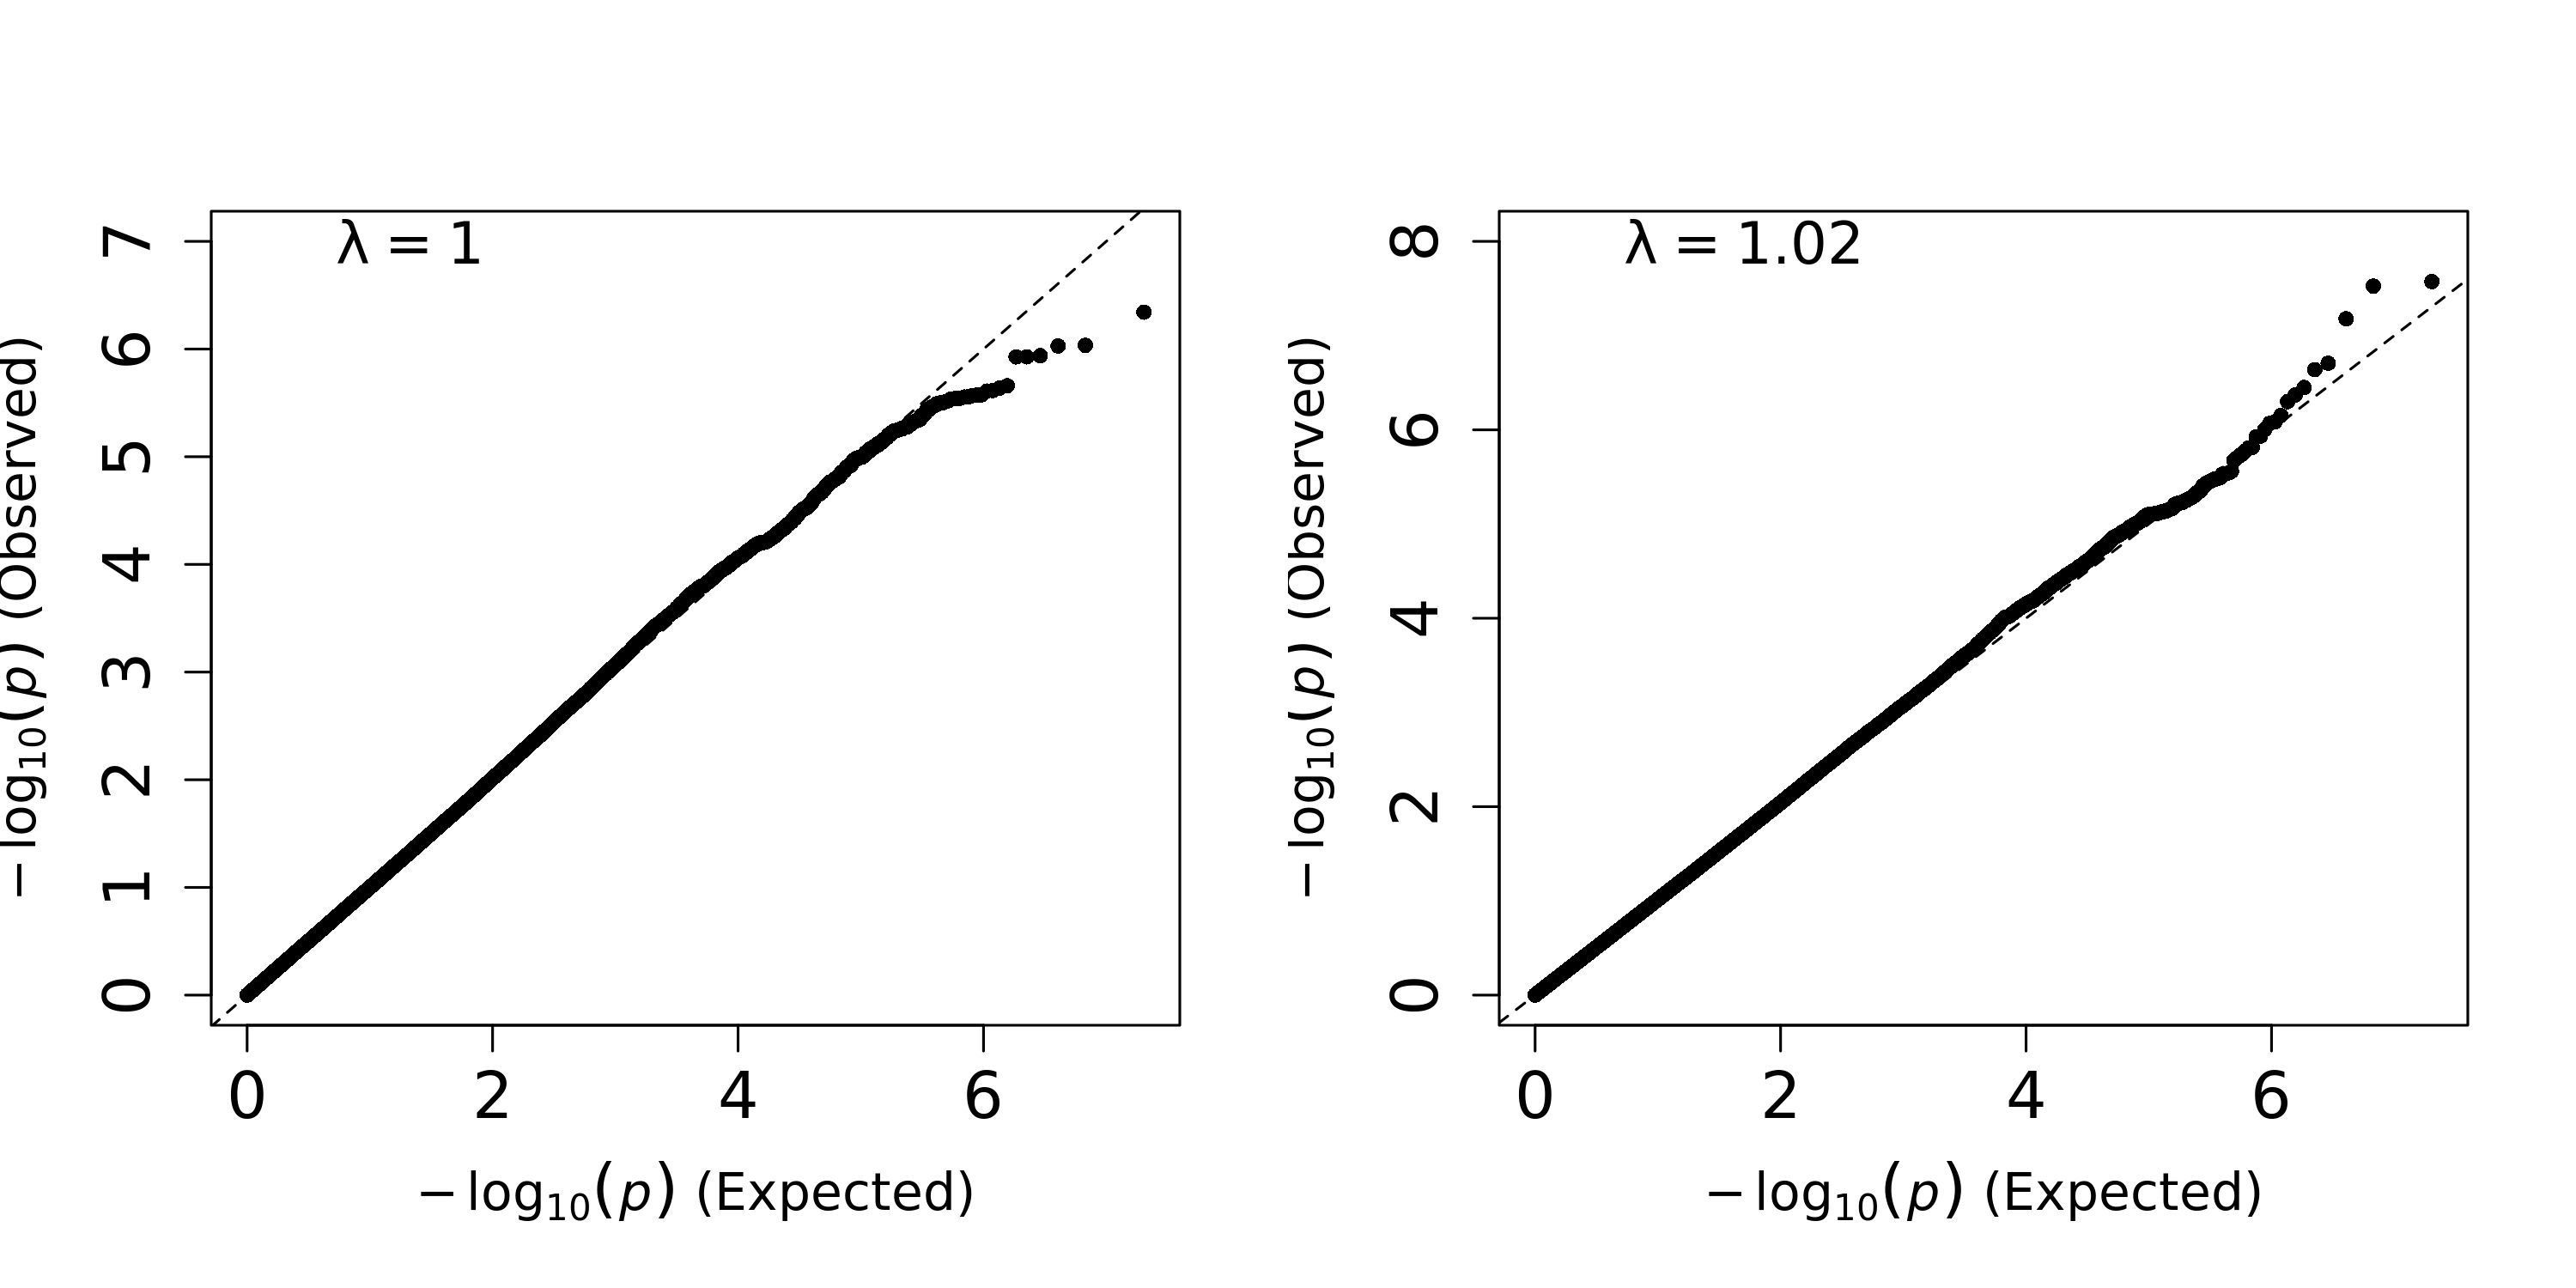

In [13]:
par(mfrow=c(1, 2))
make_qq(sex_res, "P_Value_Interaction")
make_qq(sex_res, "P_Value_Joint")

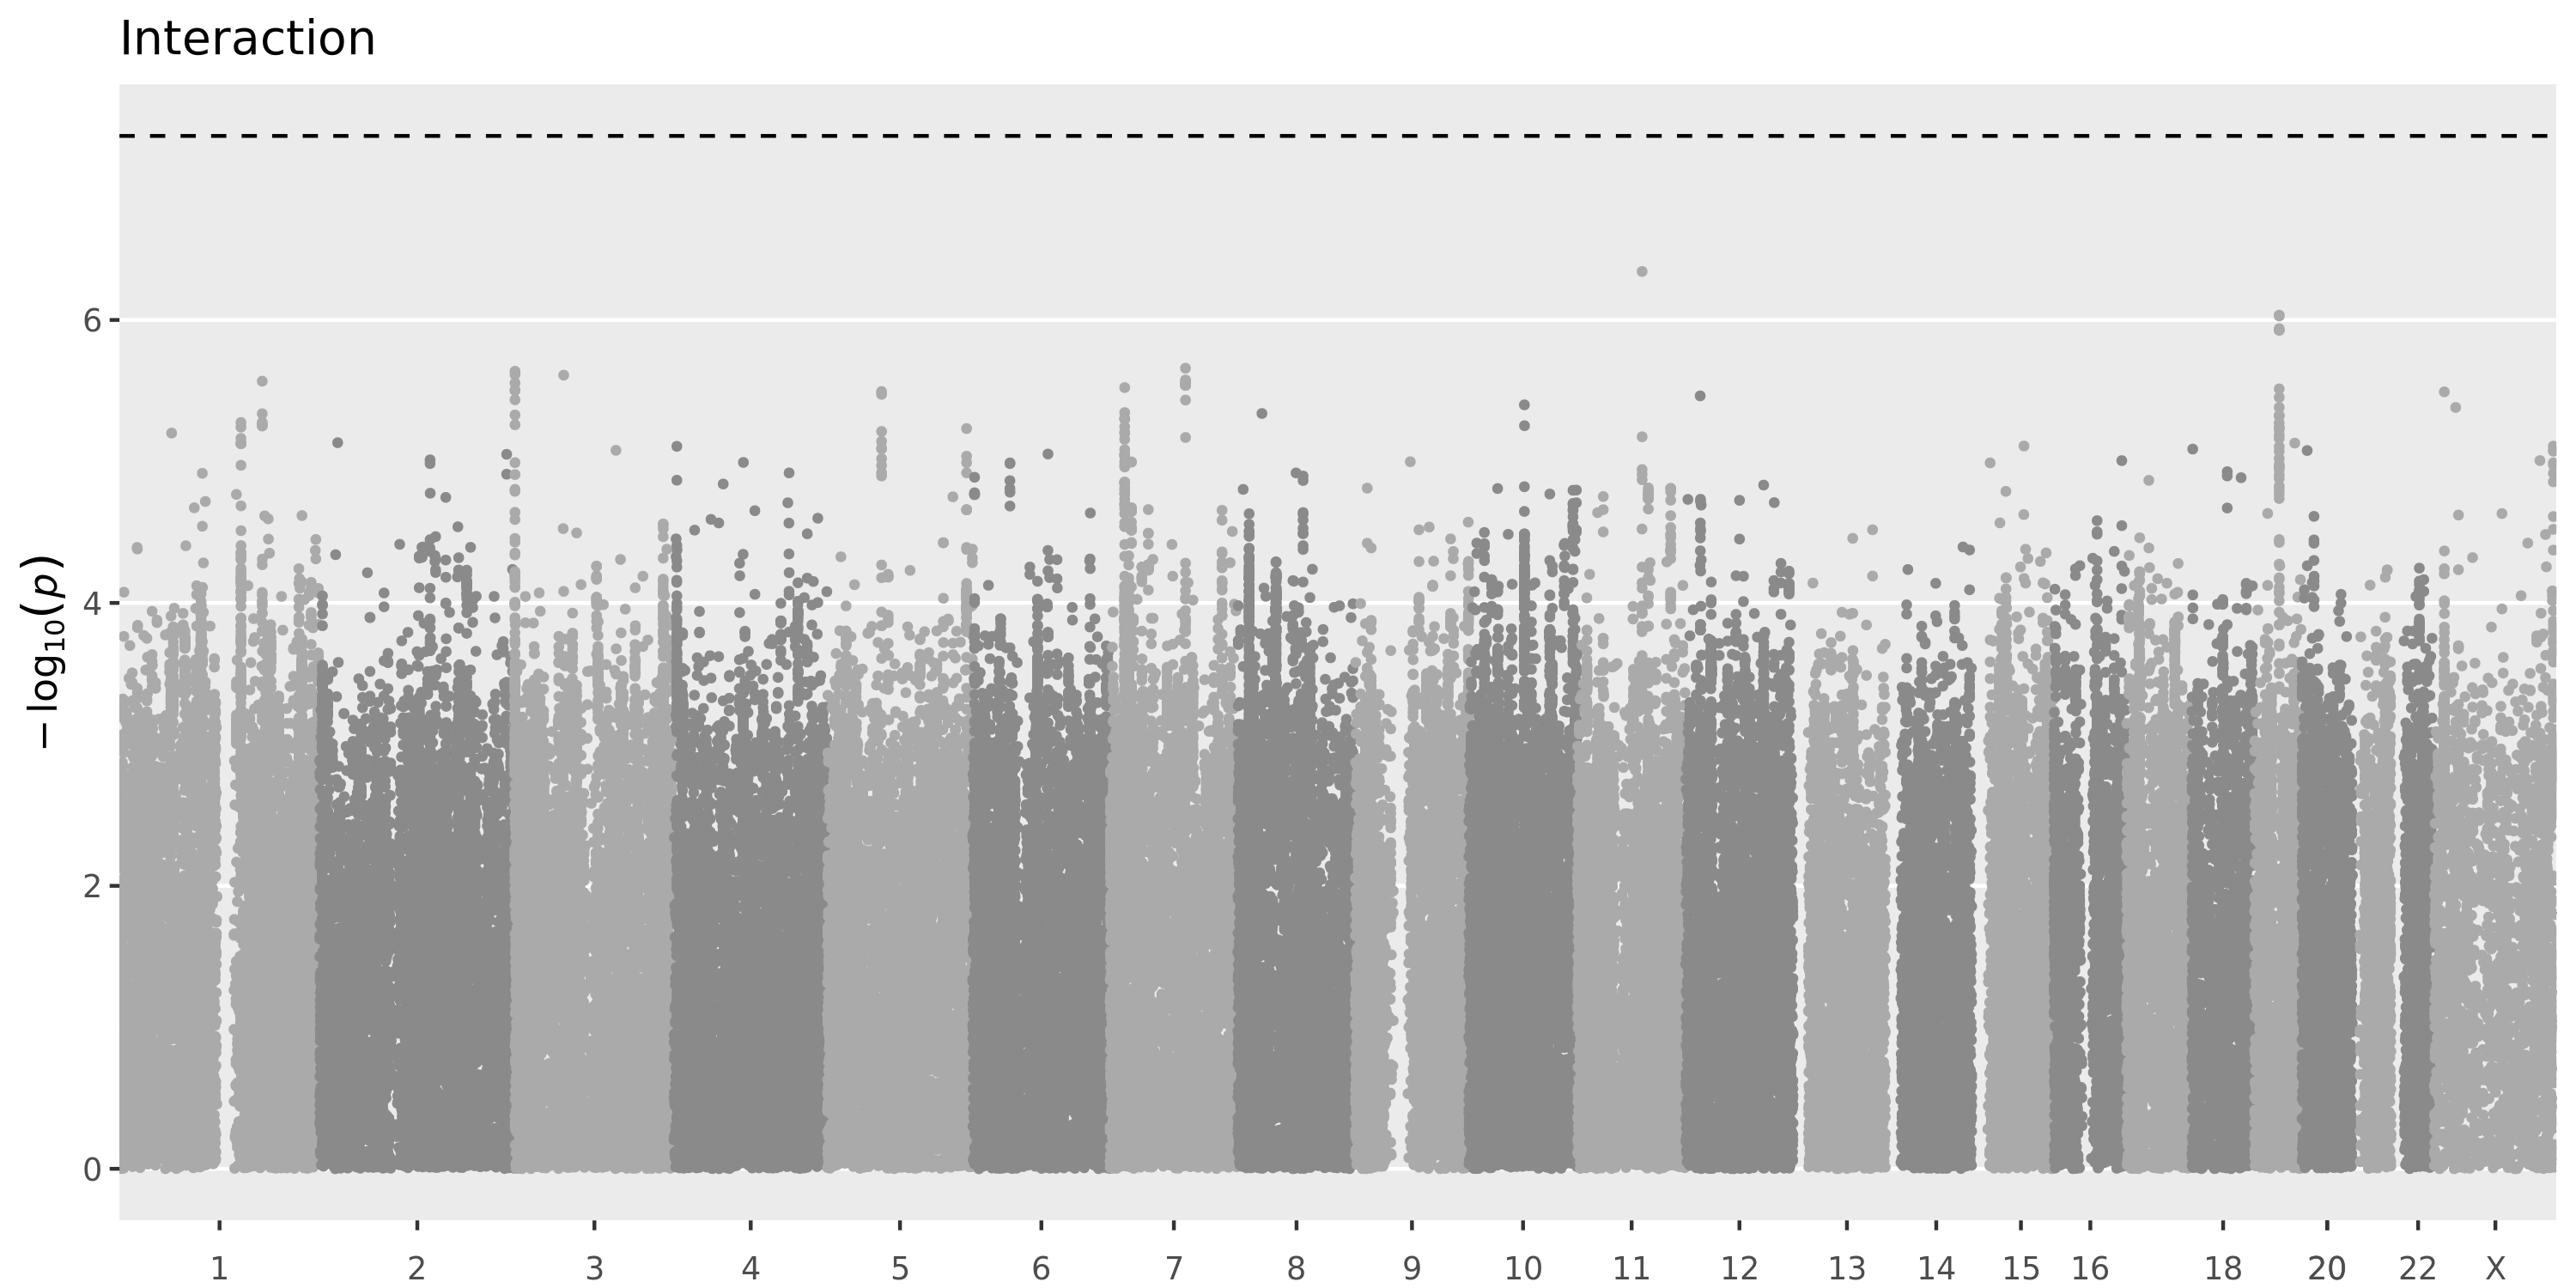

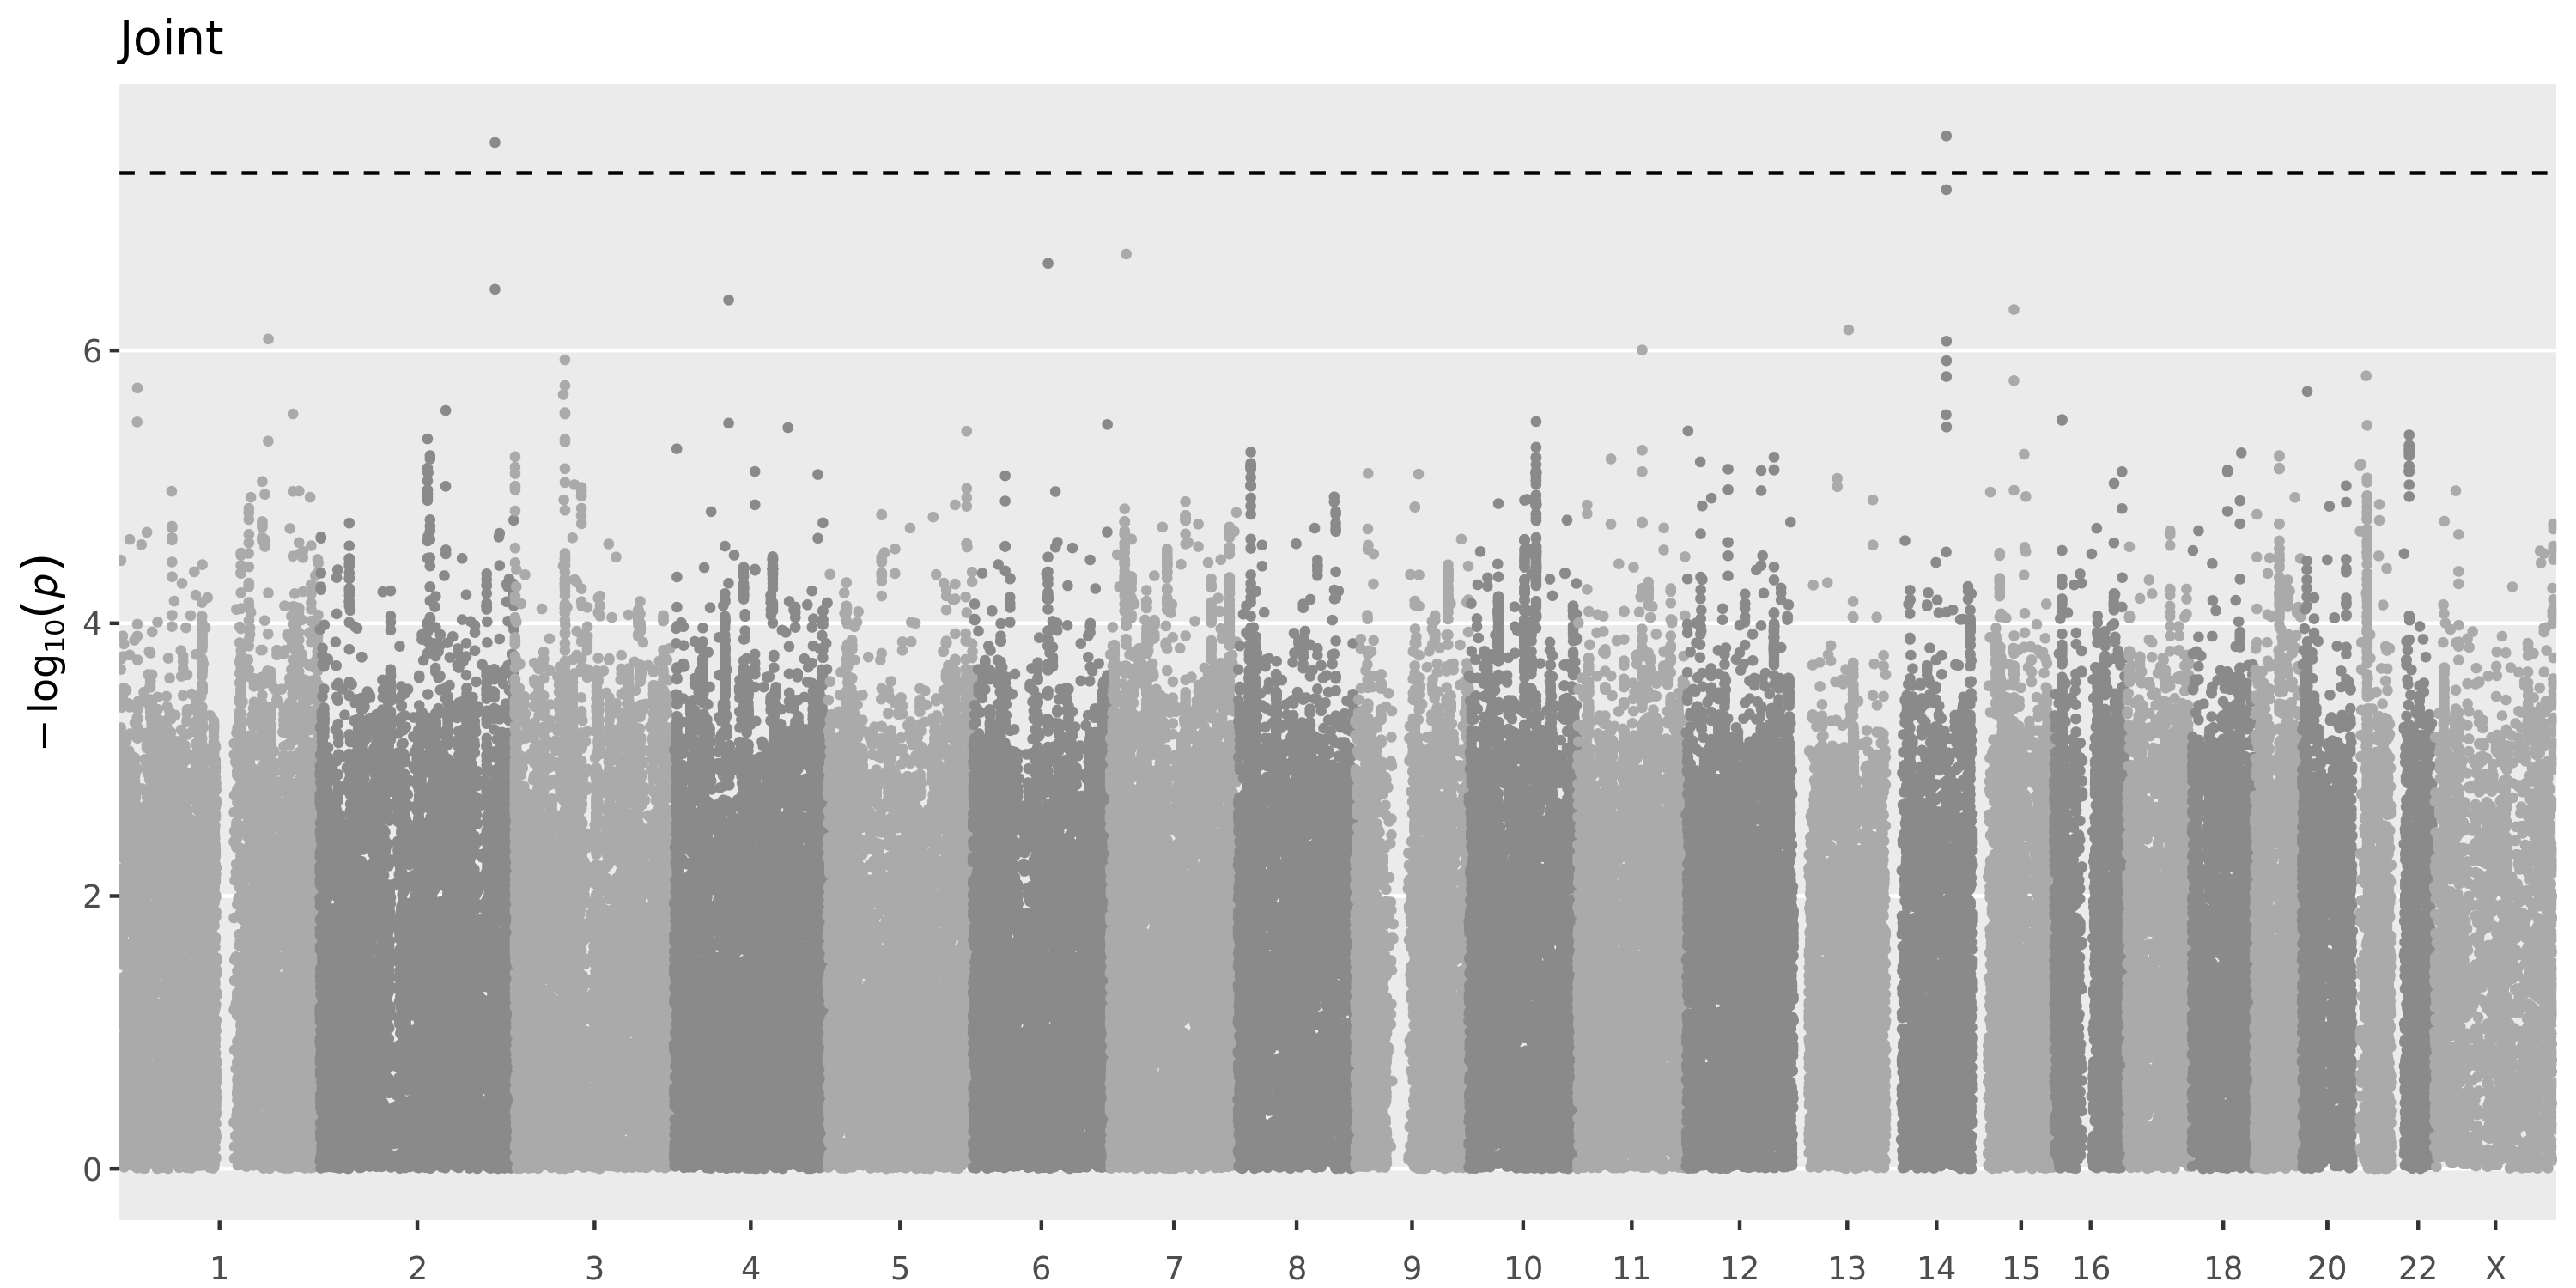

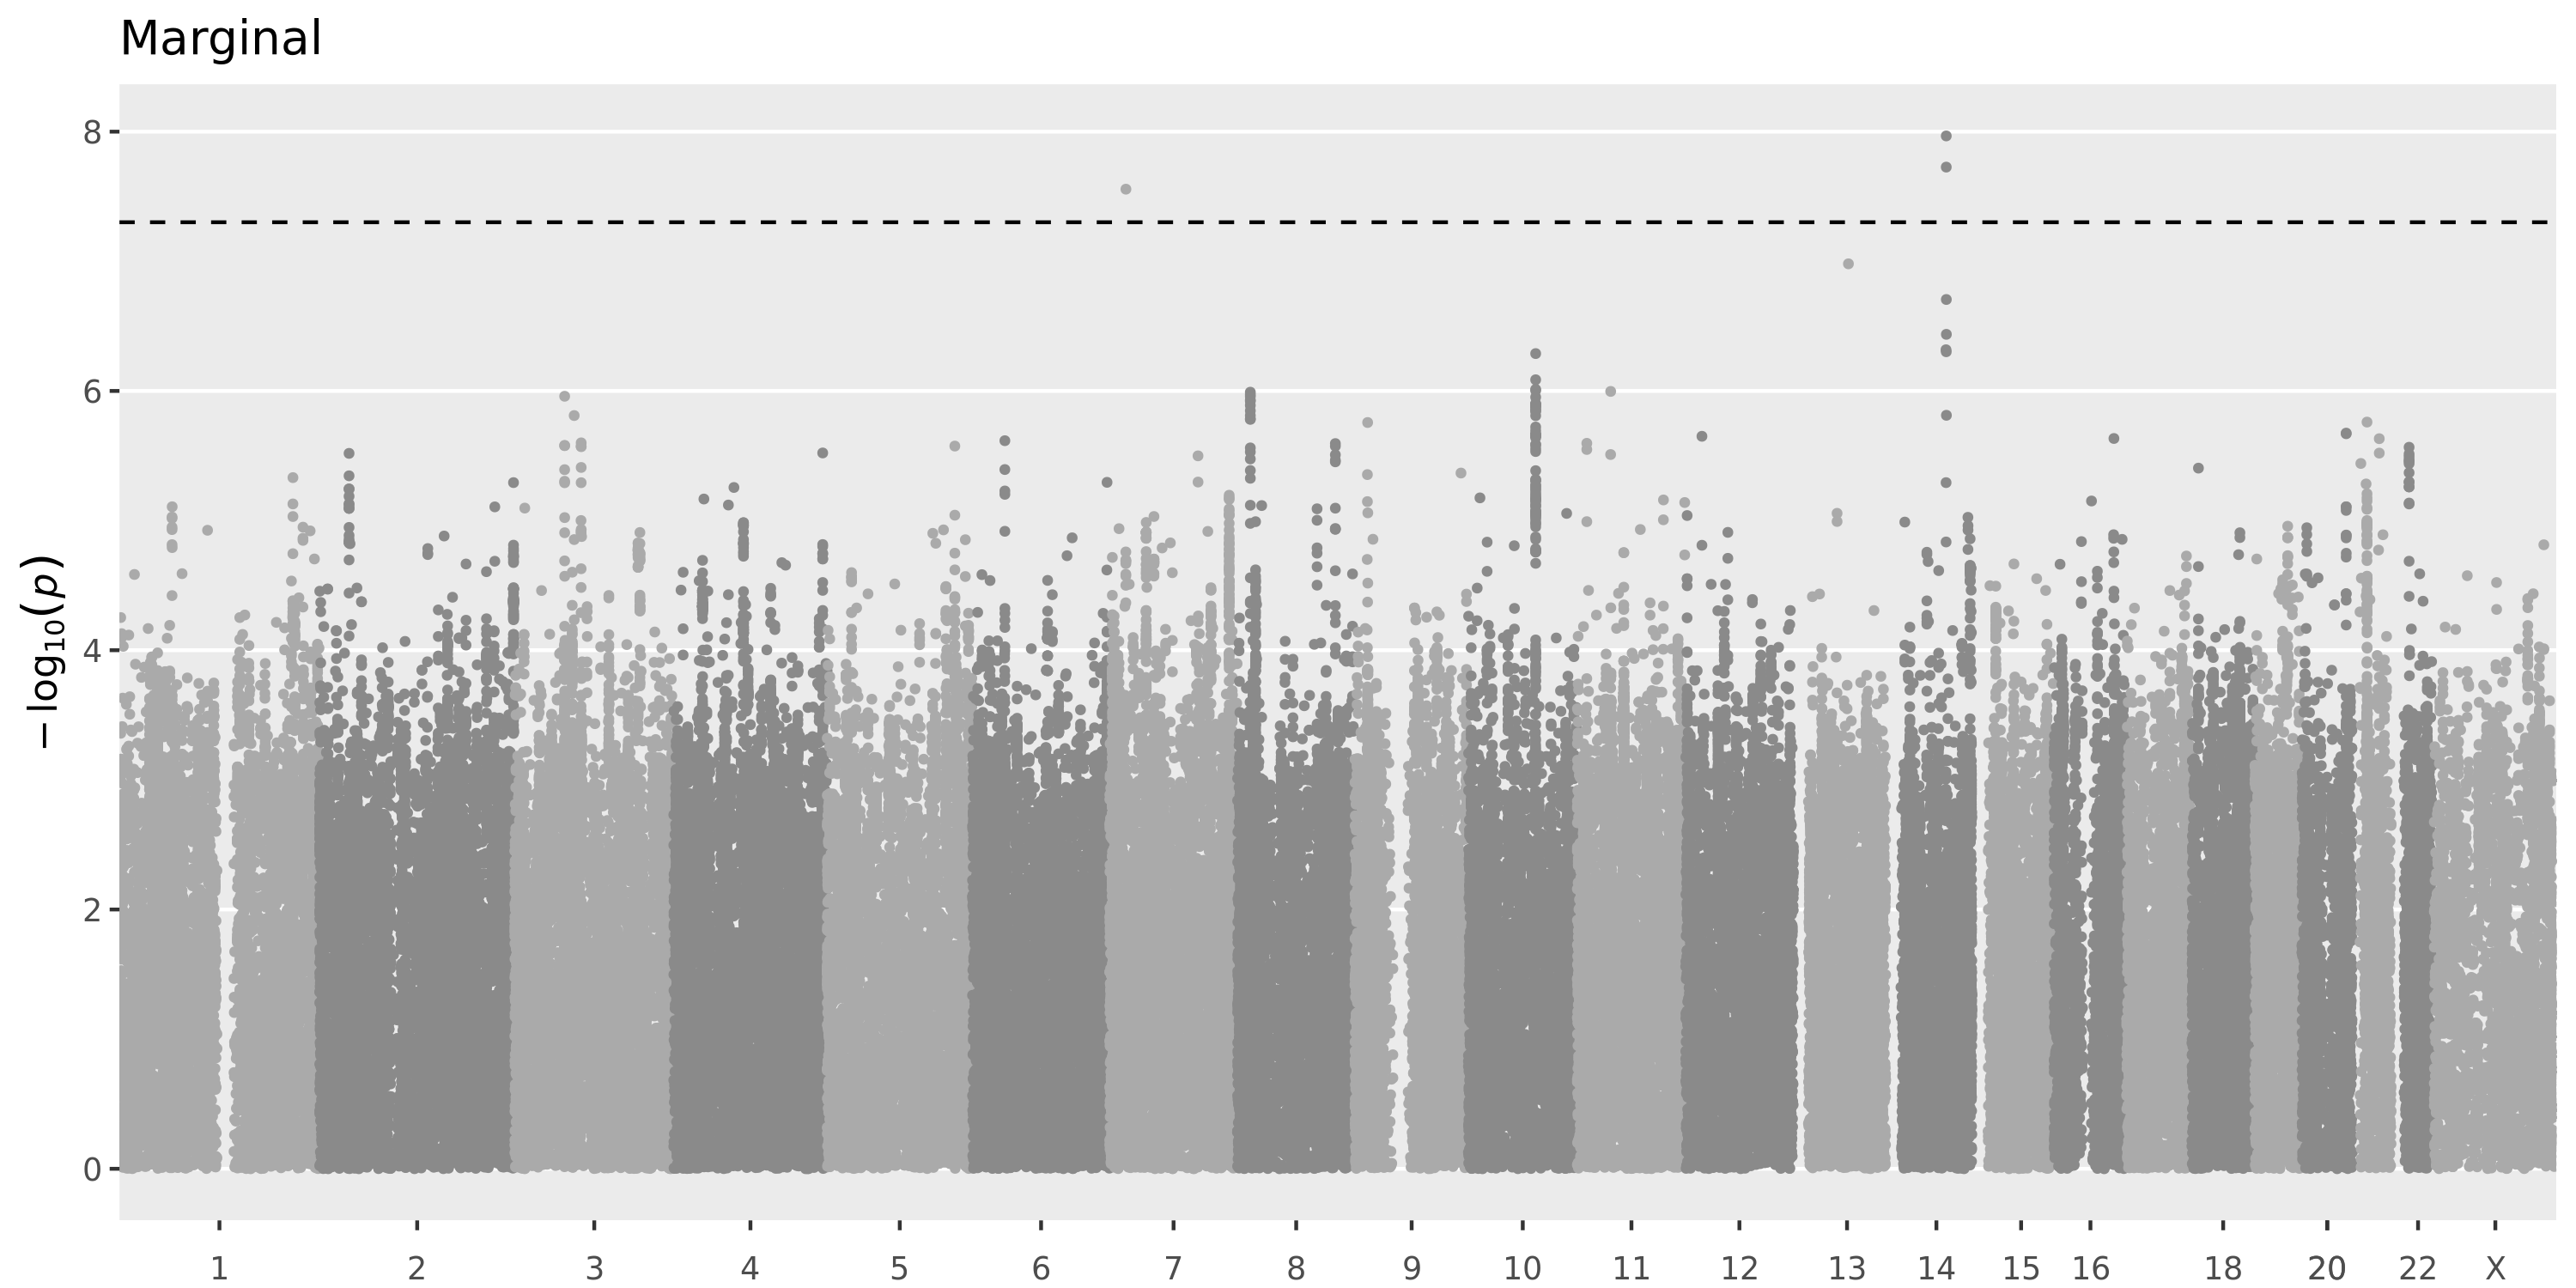

In [14]:
make_manhattan(sex_res, "P_Value_Interaction", main="Interaction")
make_manhattan(sex_res, "P_Value_Joint", main="Joint")
make_manhattan(sex_res, "P_Value_Marginal", main="Marginal")

### Cardiometabolic trait interactions

Joint interaction test with BMI (continuous) and T2D (binary).

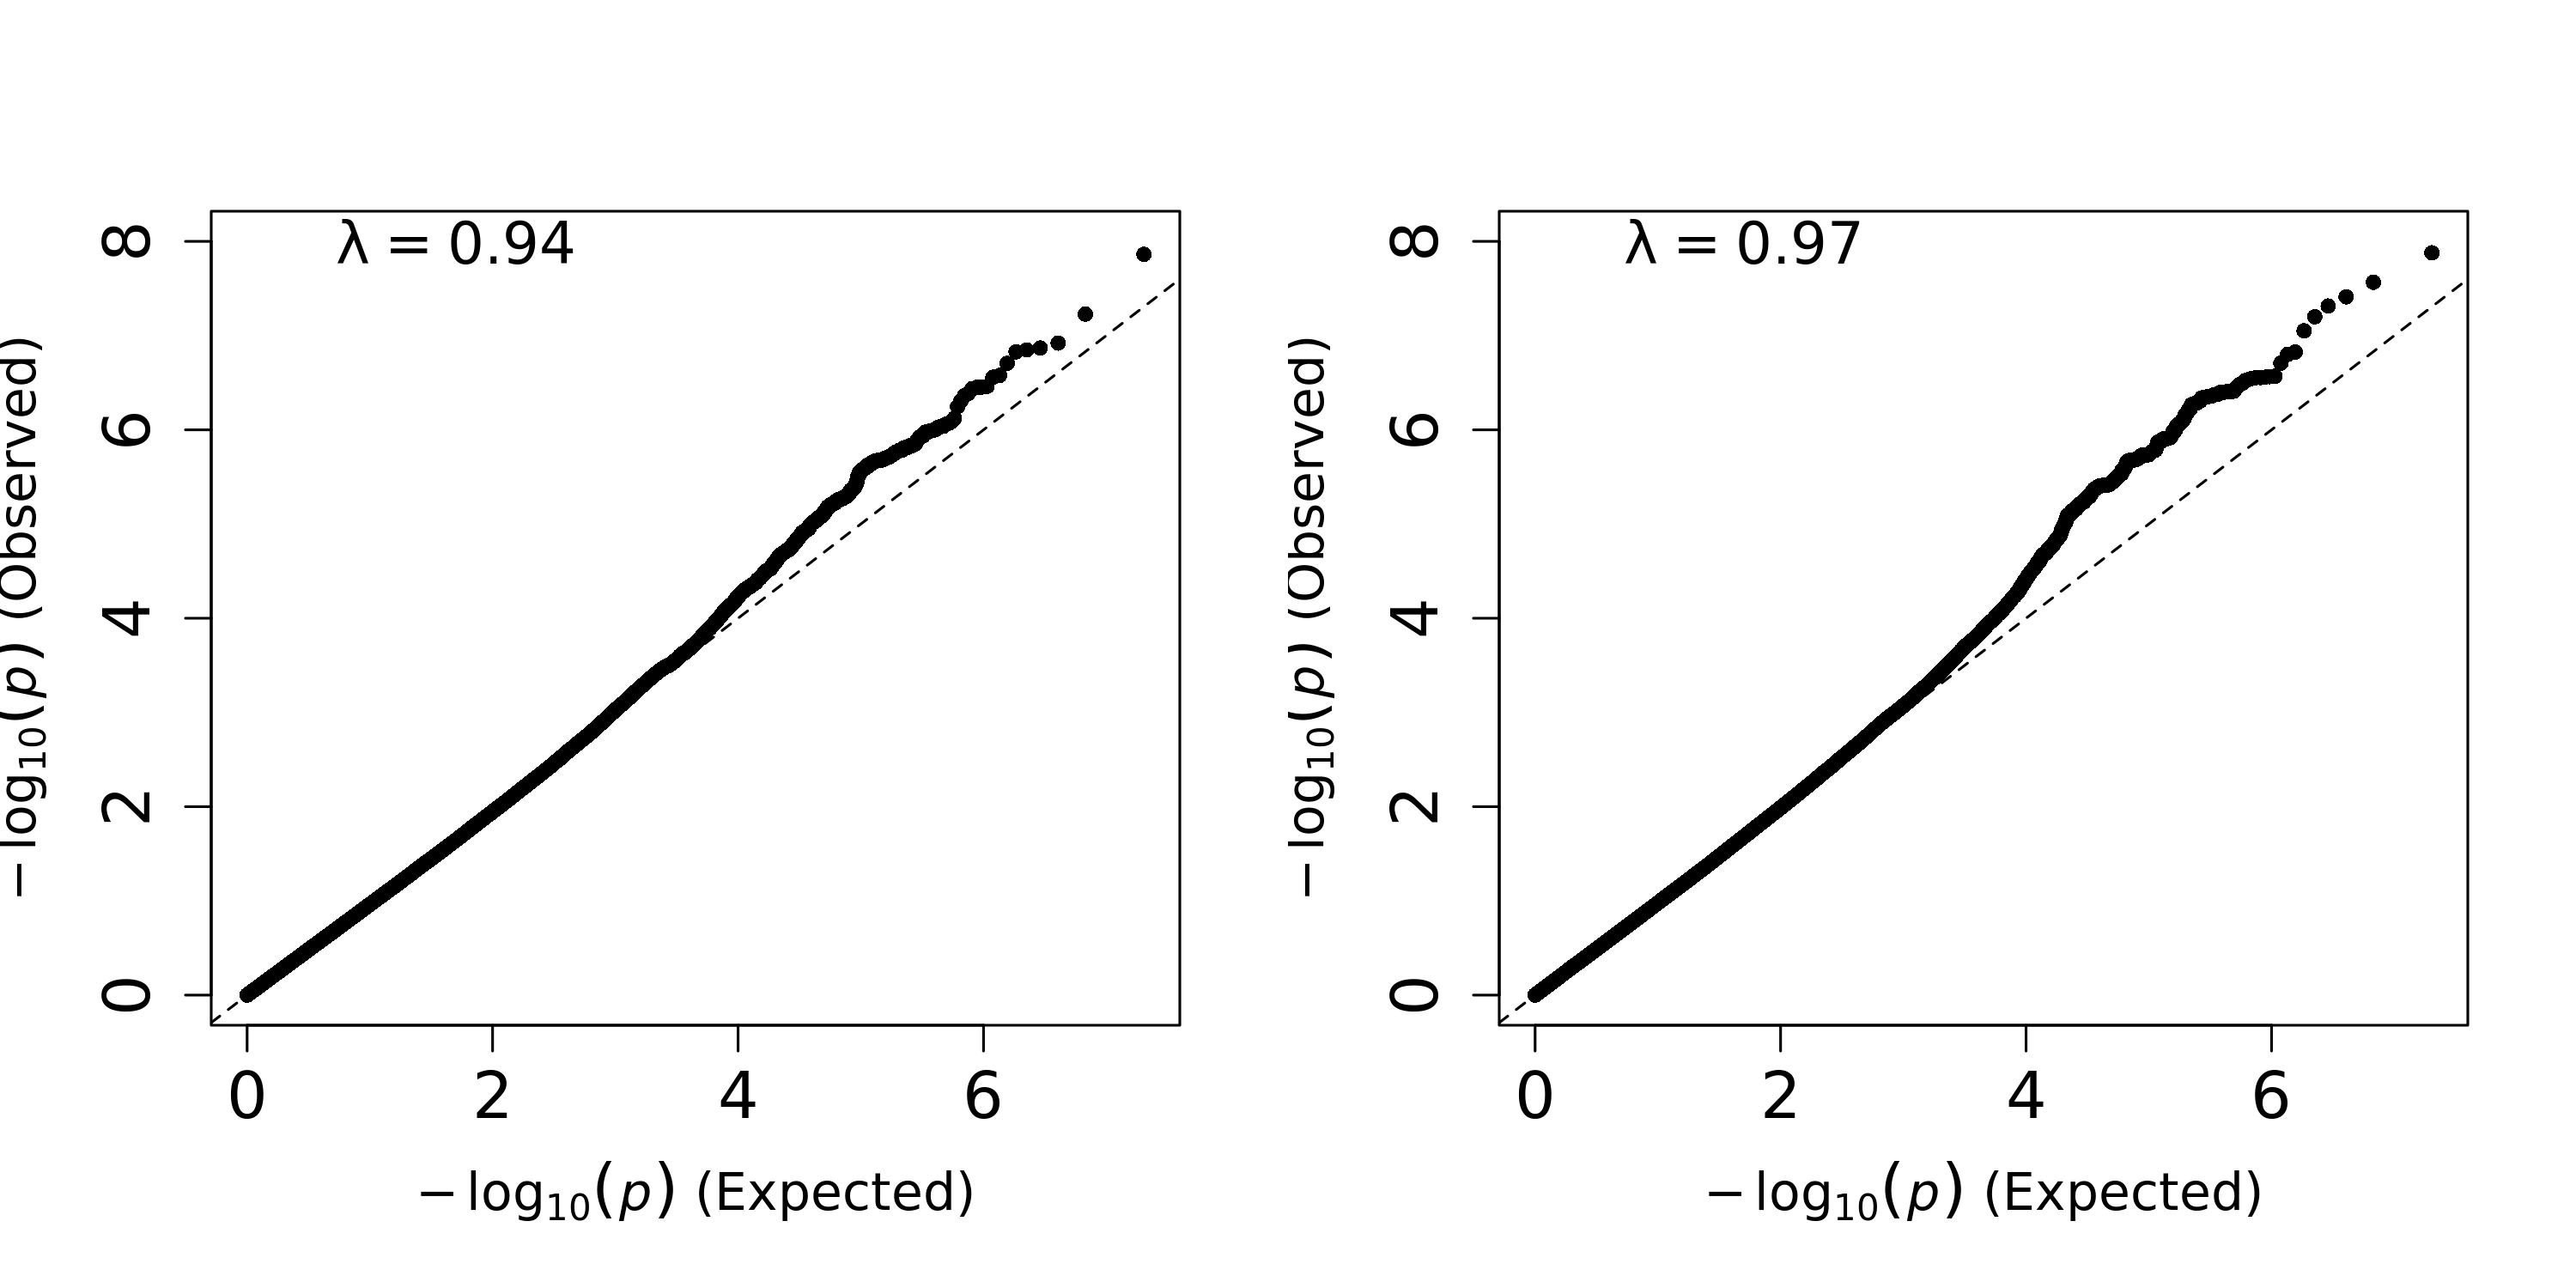

In [15]:
par(mfrow=c(1, 2))
make_qq(cm_res, "P_Value_Interaction")
make_qq(cm_res, "P_Value_Joint")

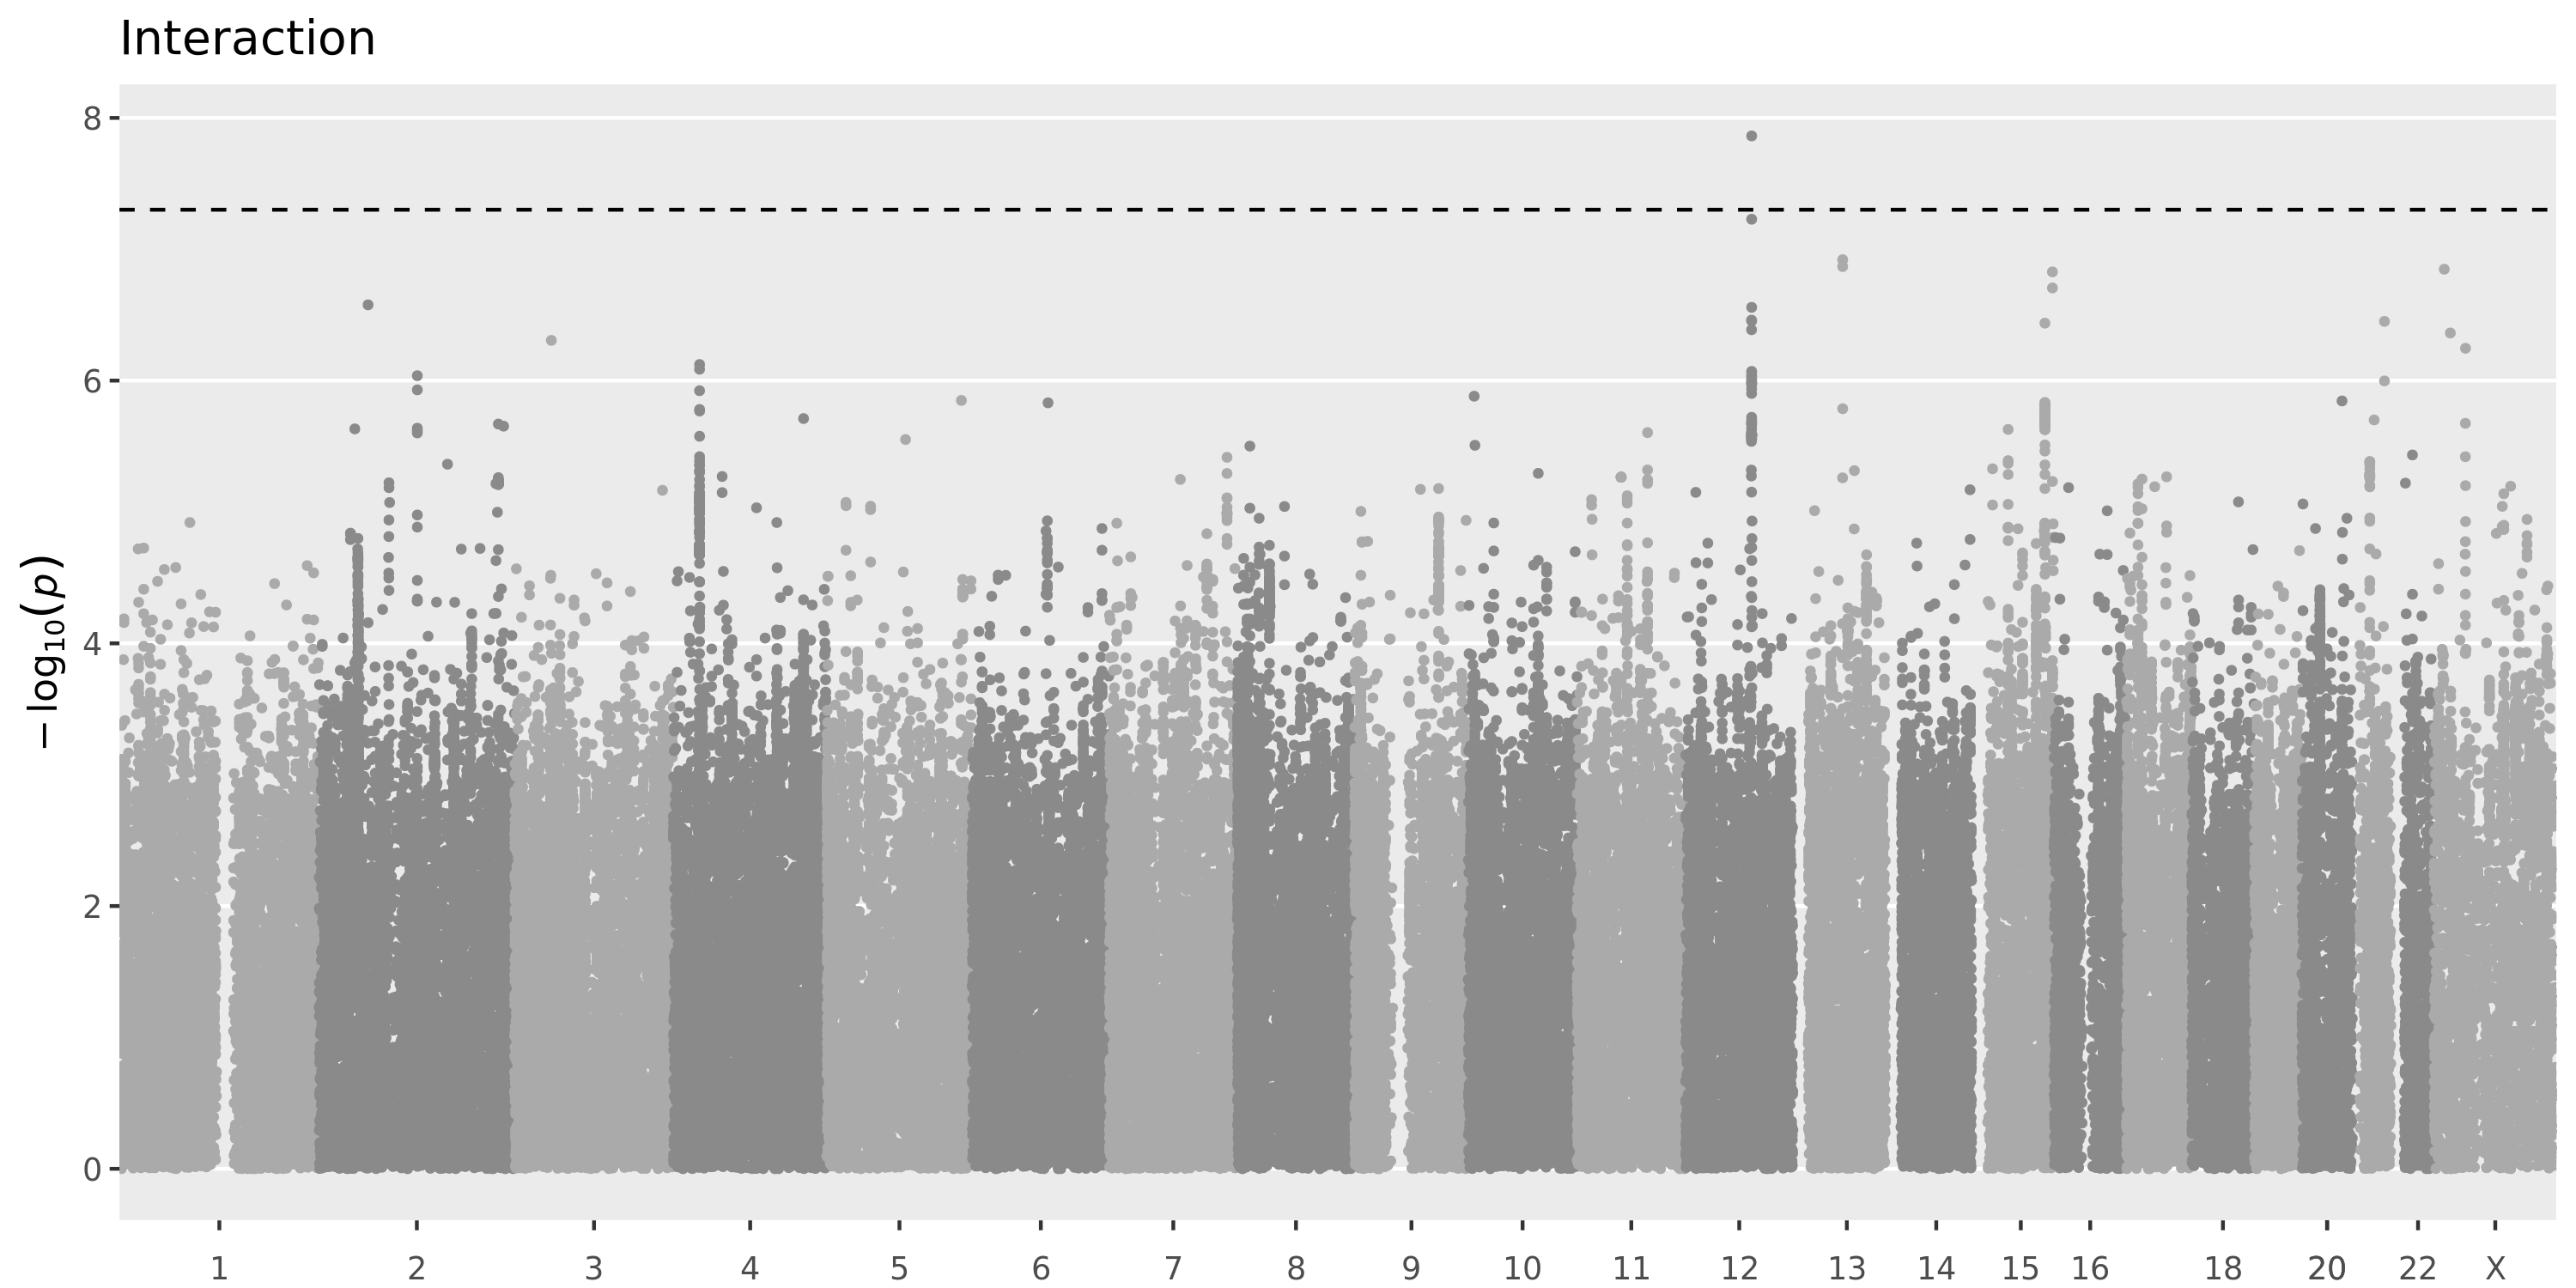

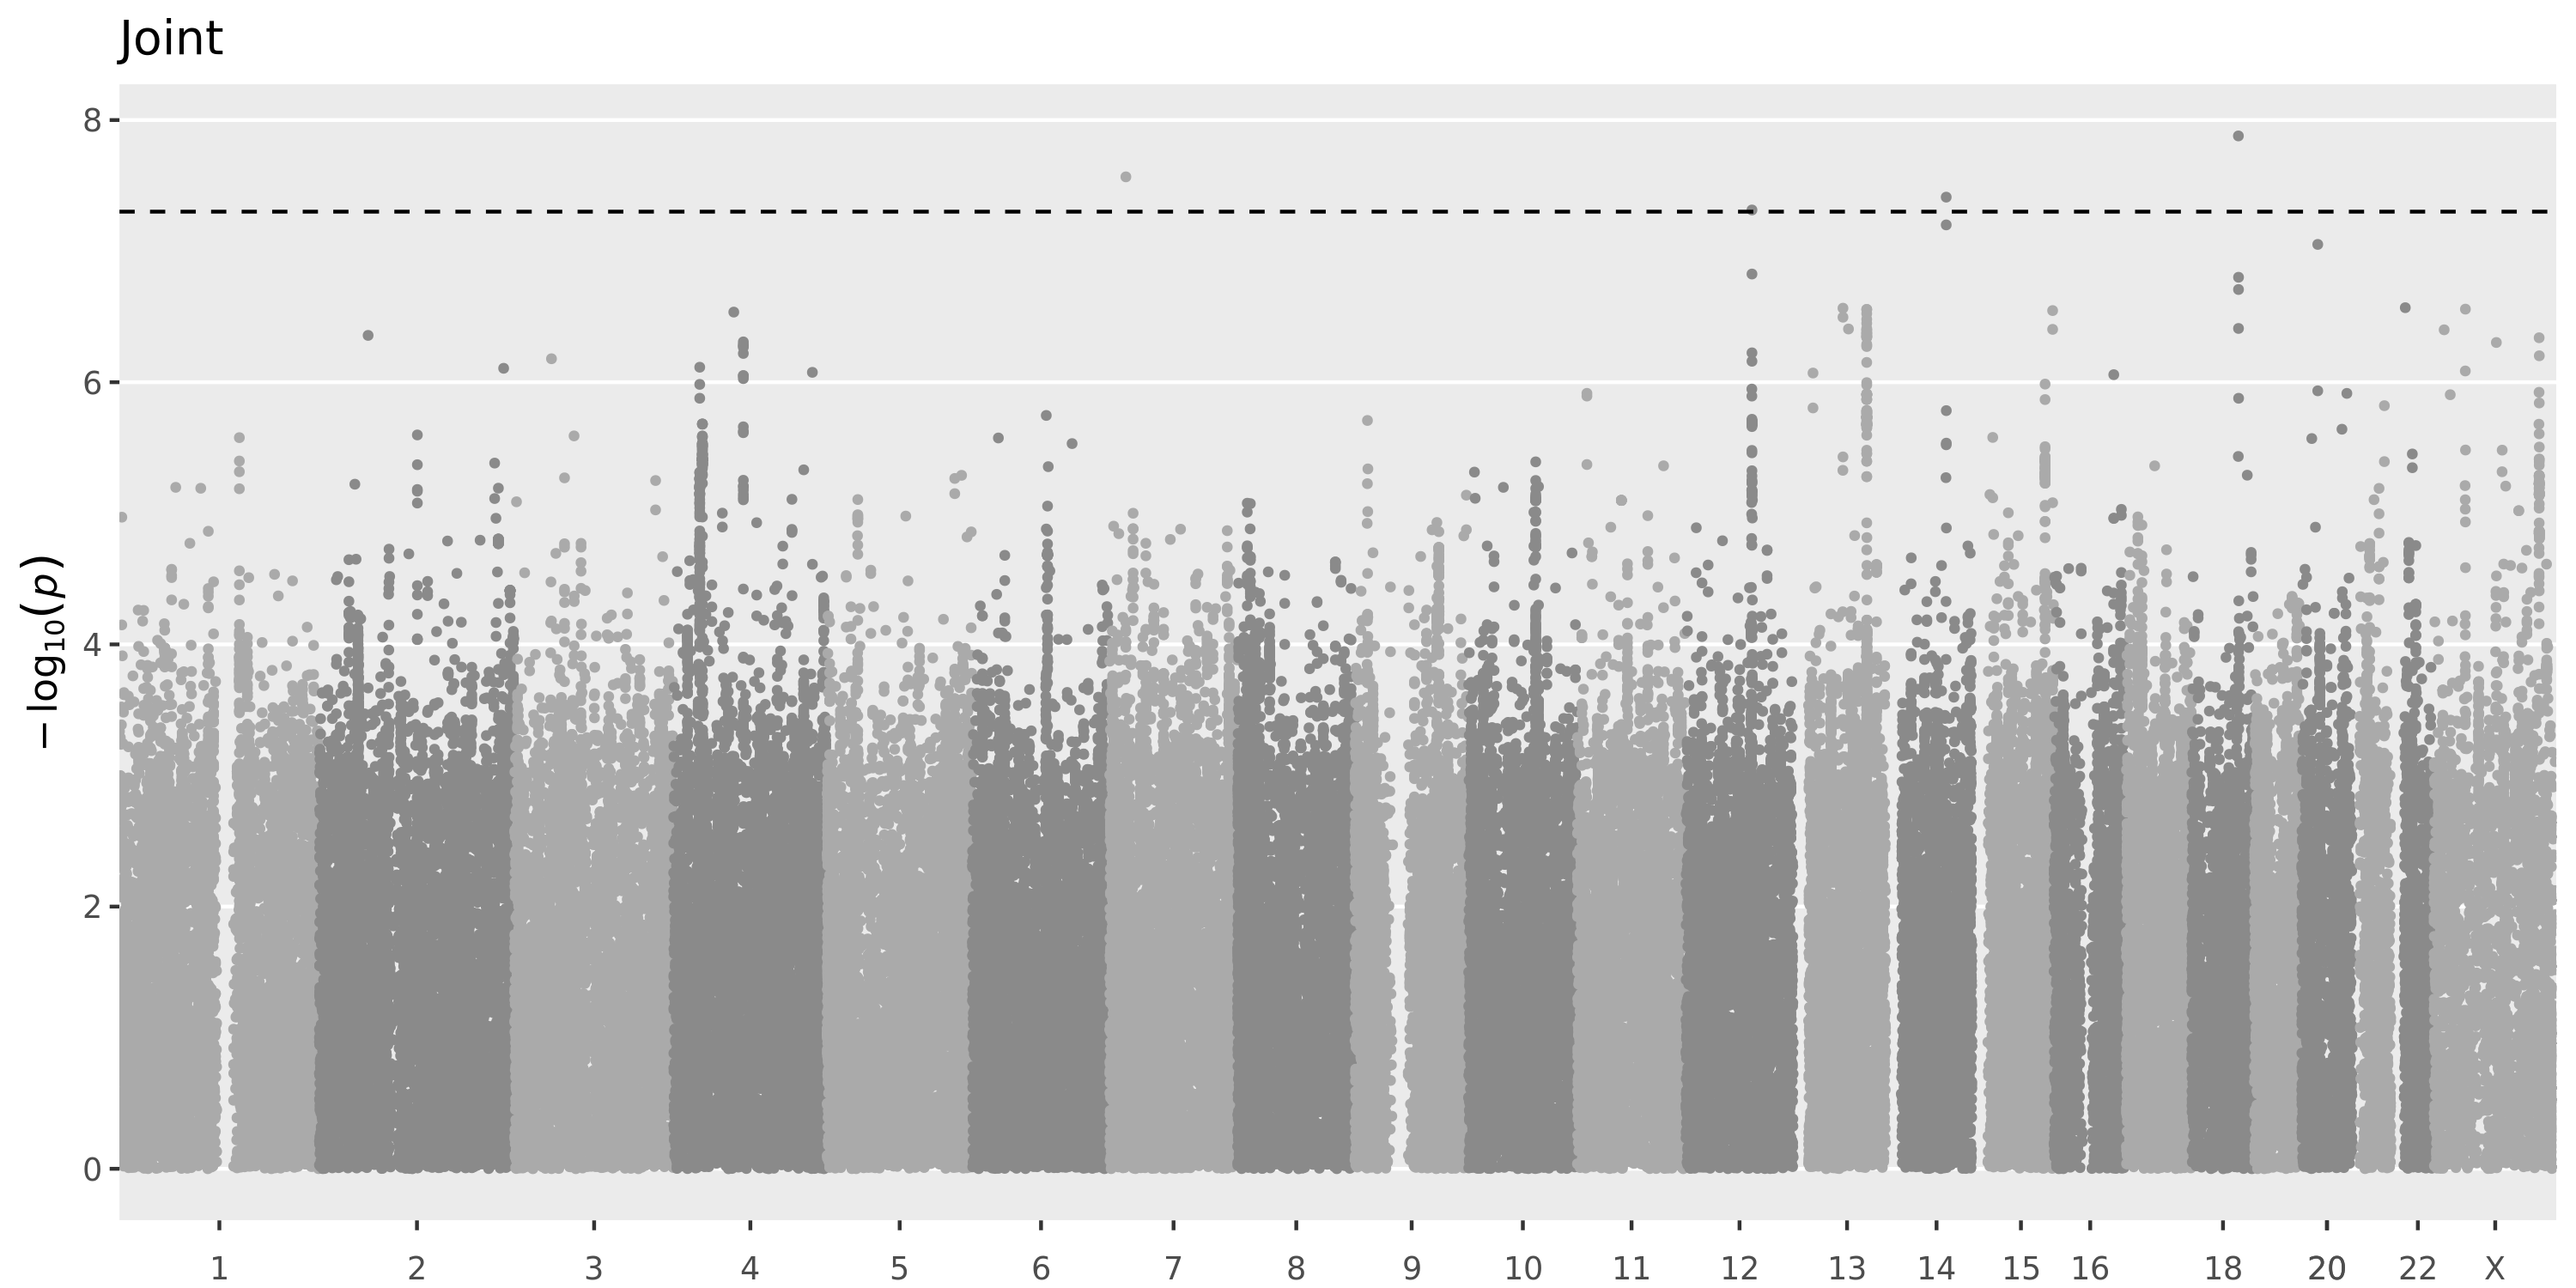

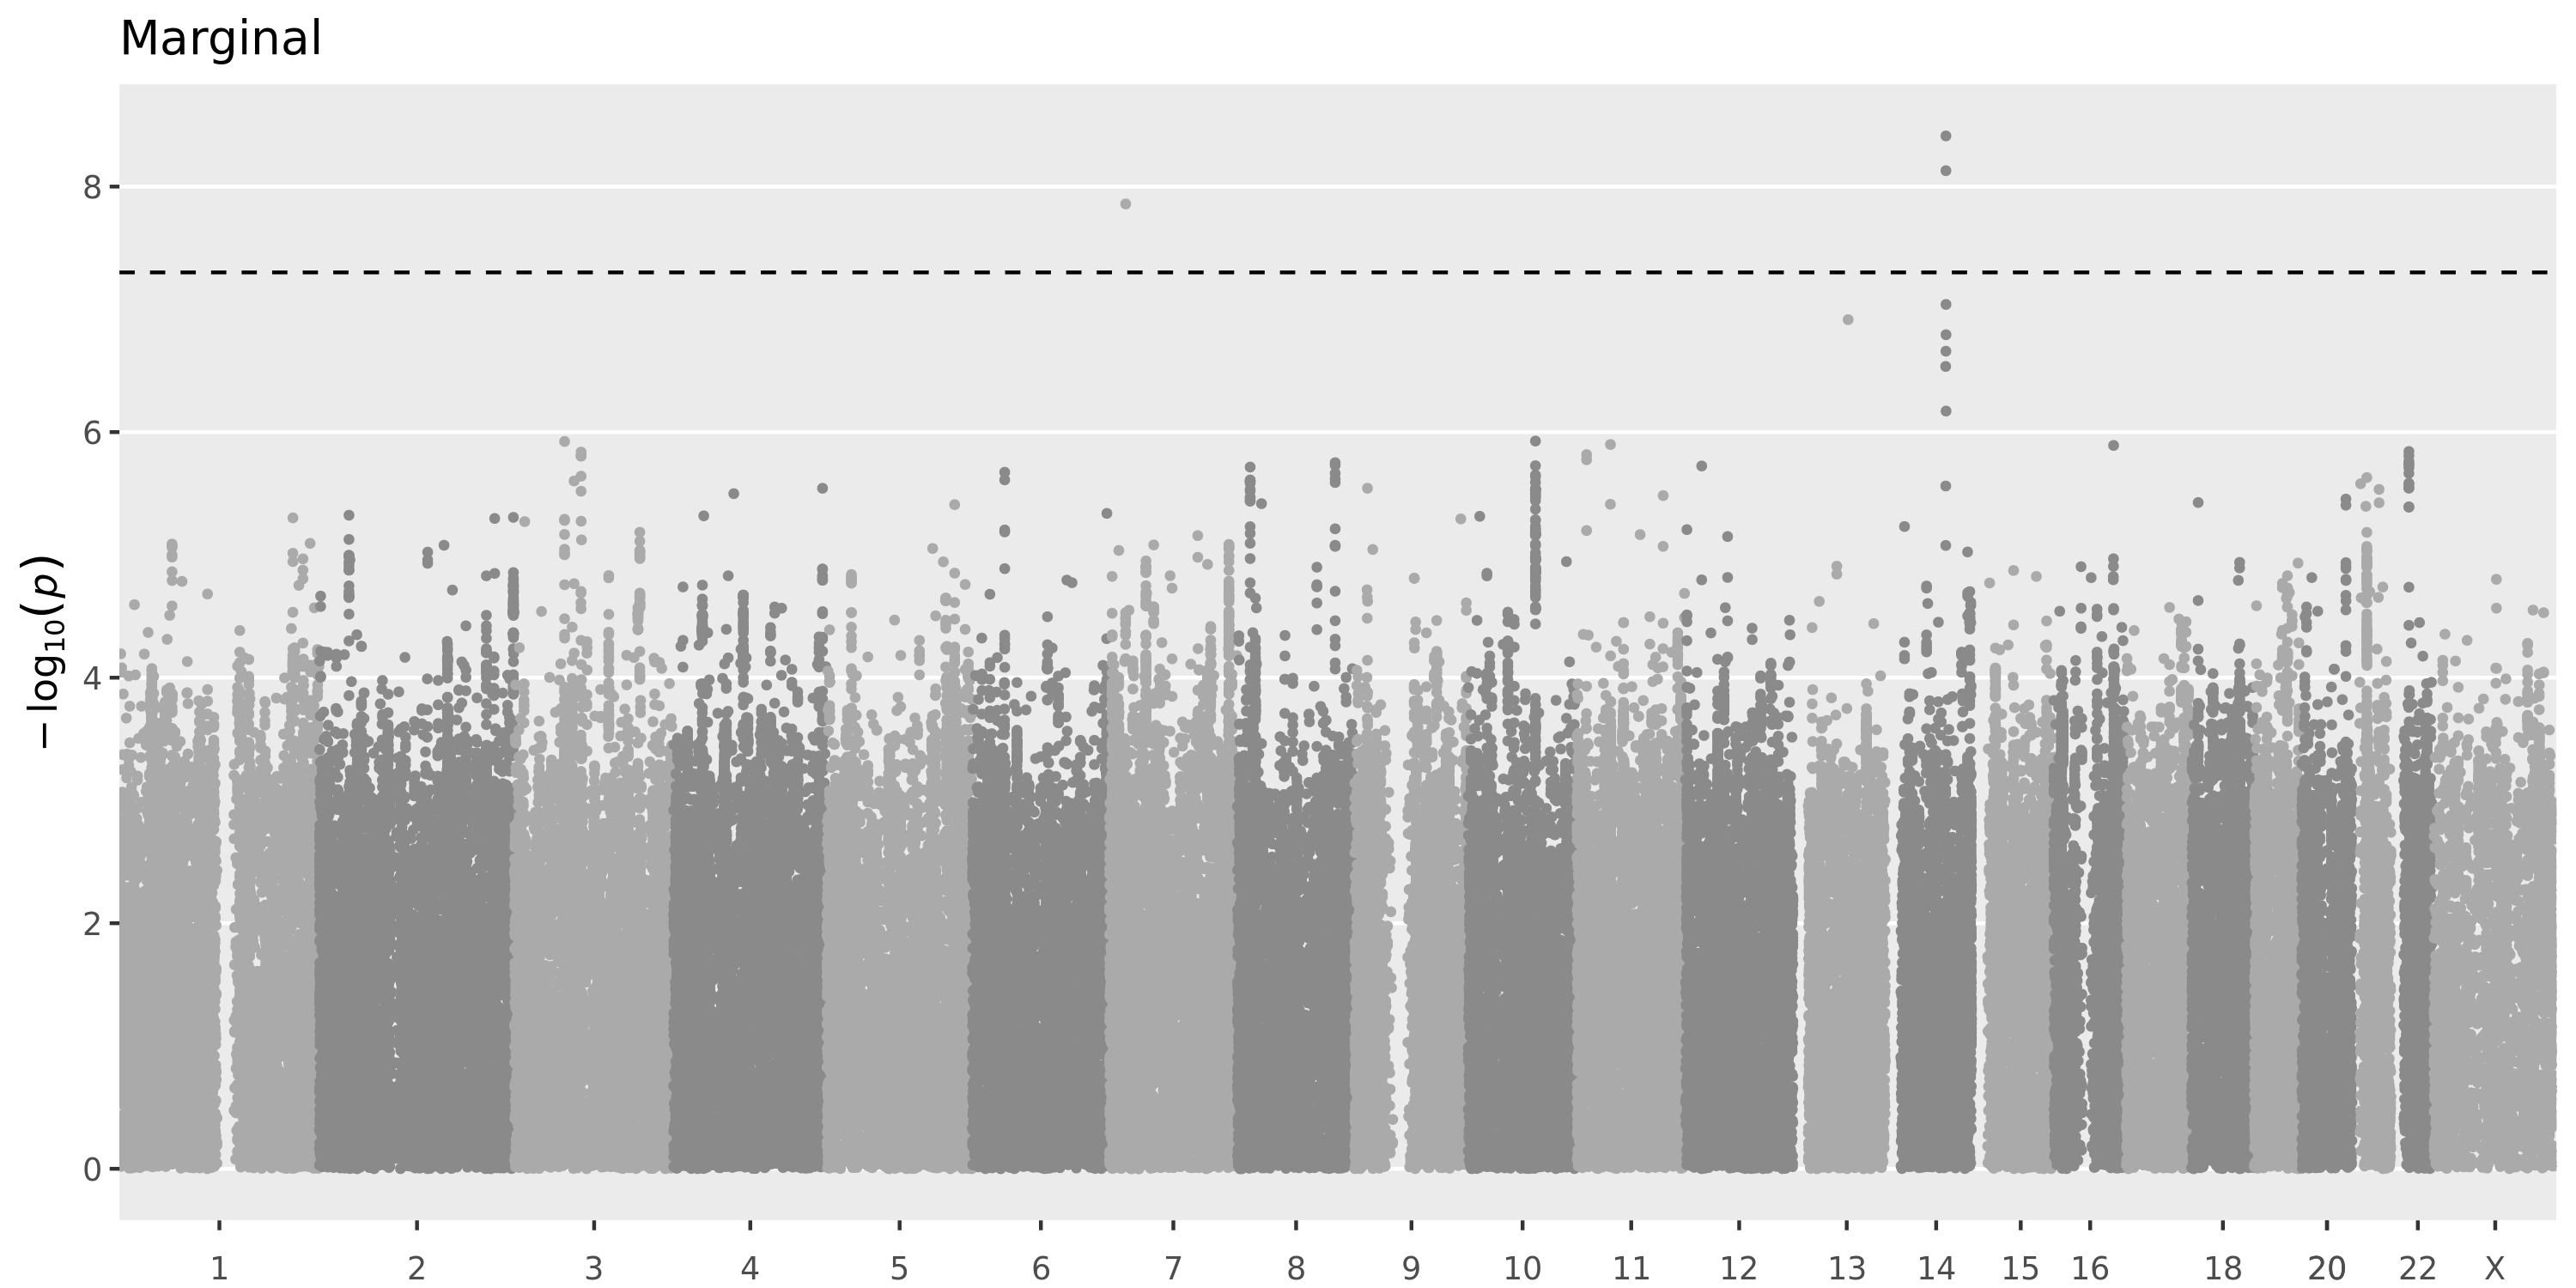

In [16]:
make_manhattan(cm_res, "P_Value_Interaction", main="Interaction")
make_manhattan(cm_res, "P_Value_Joint", main="Joint")
make_manhattan(cm_res, "P_Value_Marginal", main="Marginal")

### Social determinants of health interactions

Multiple deprivation index (MDI) as a continuous variable summarizing SDH (England only to allow for reasonable homogeneity).

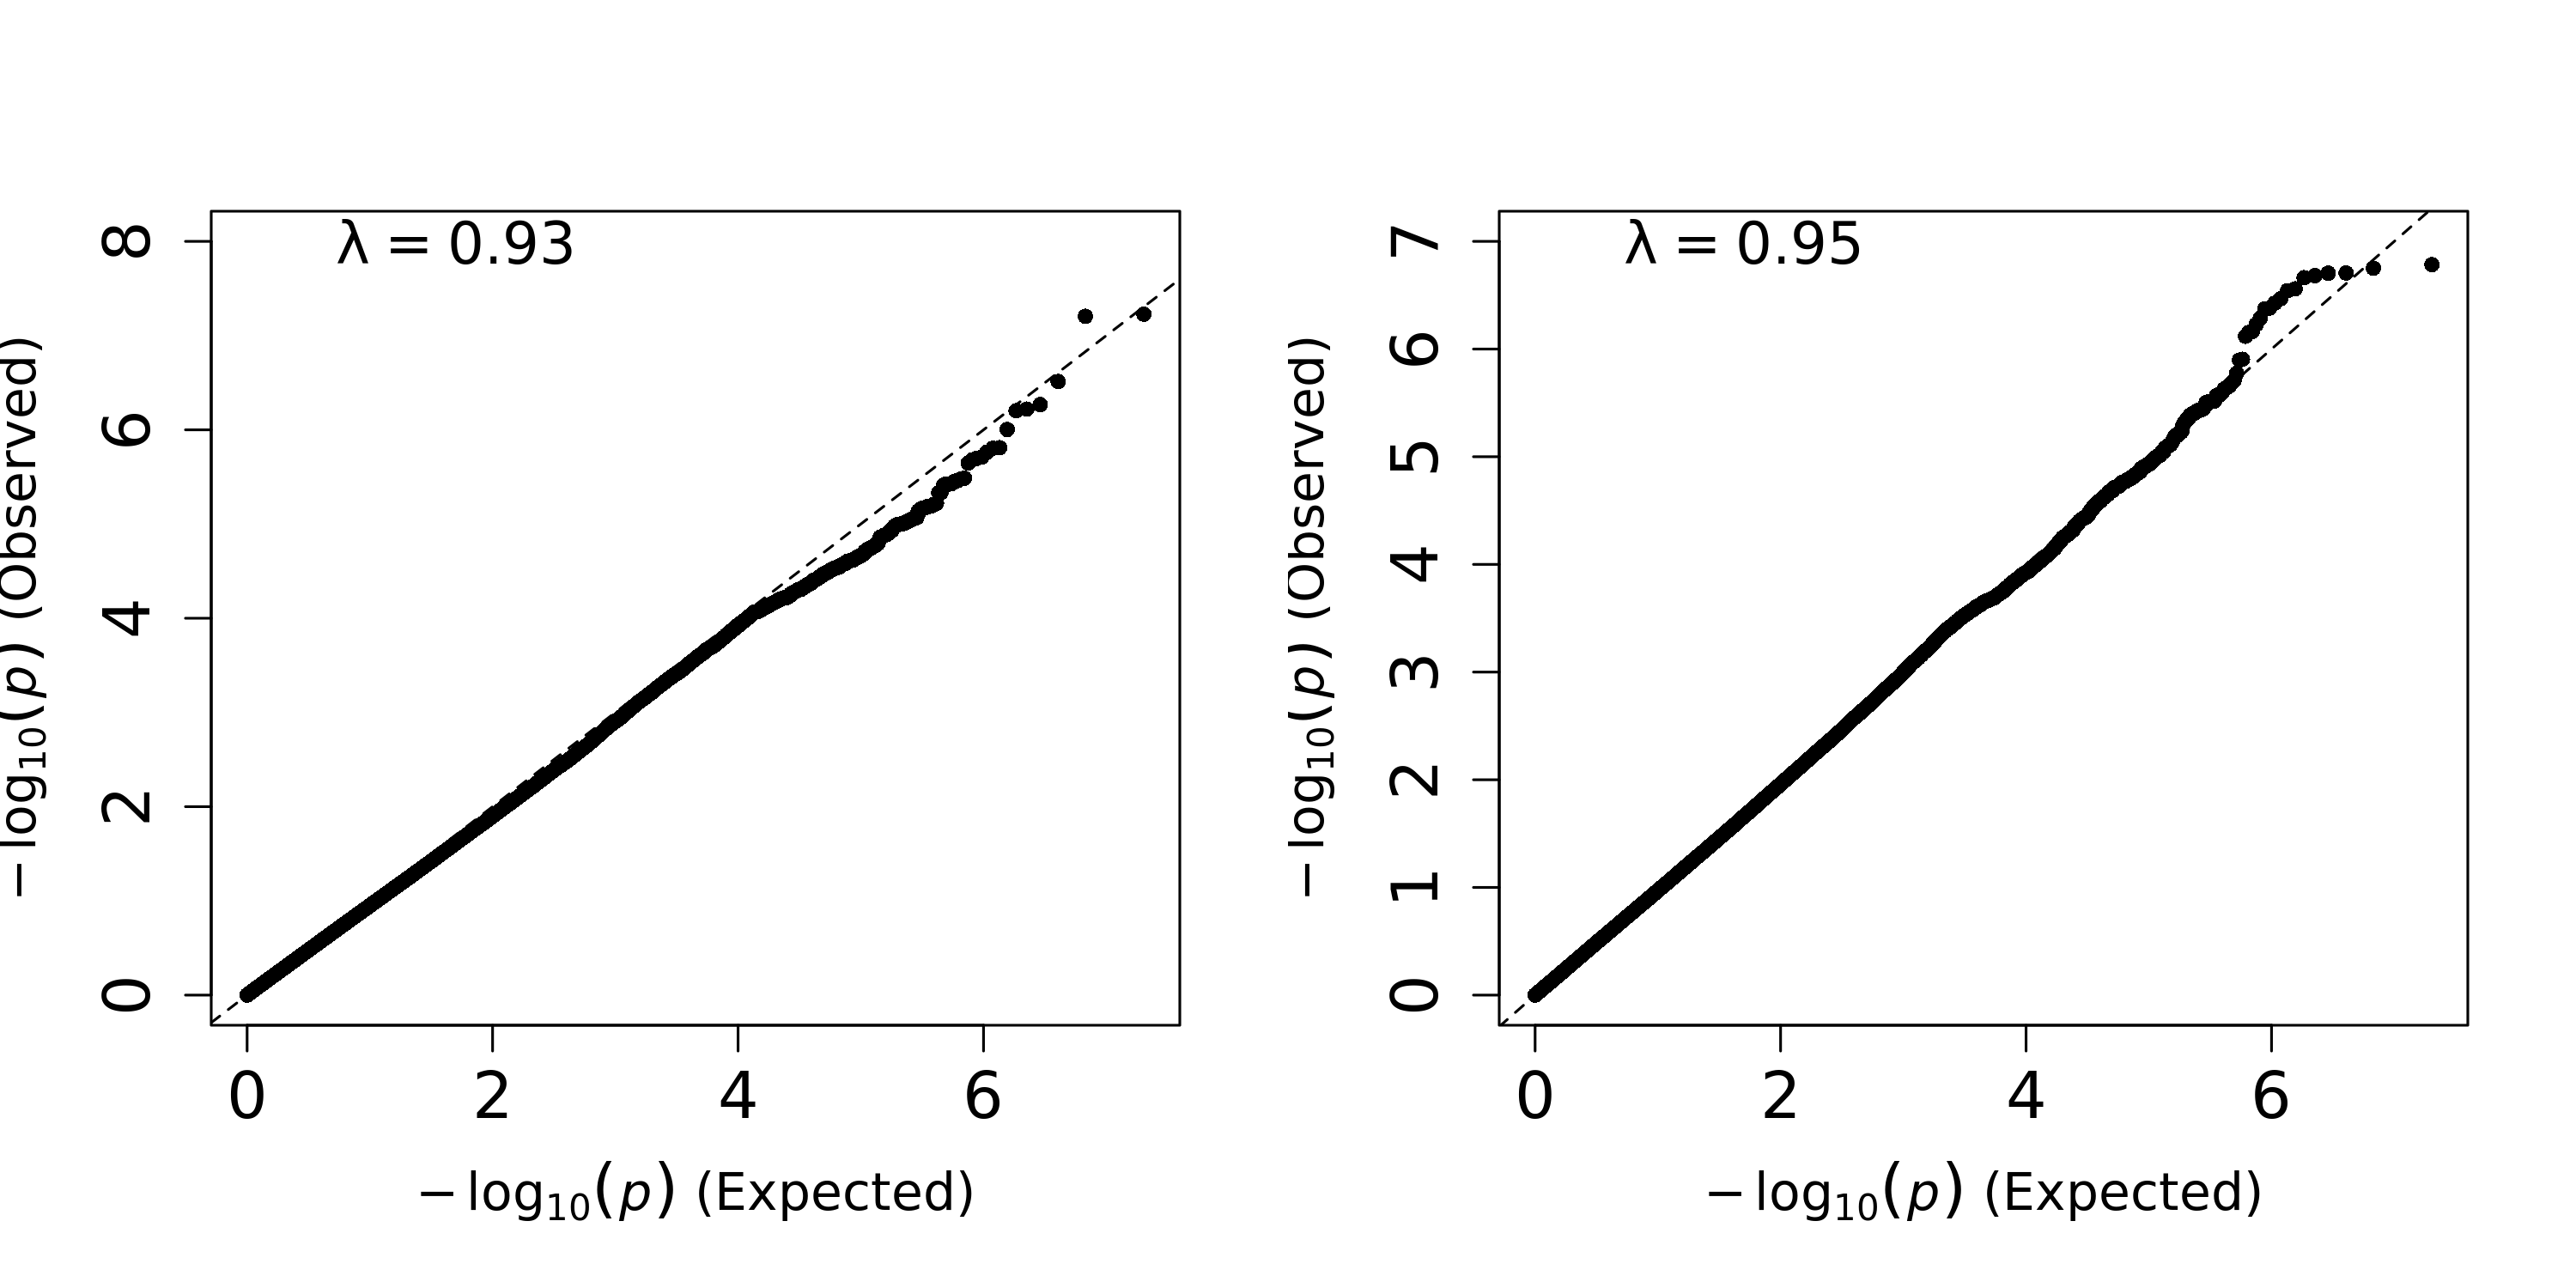

In [17]:
par(mfrow=c(1, 2))
make_qq(mdi_res, "P_Value_Interaction")
make_qq(mdi_res, "P_Value_Joint")

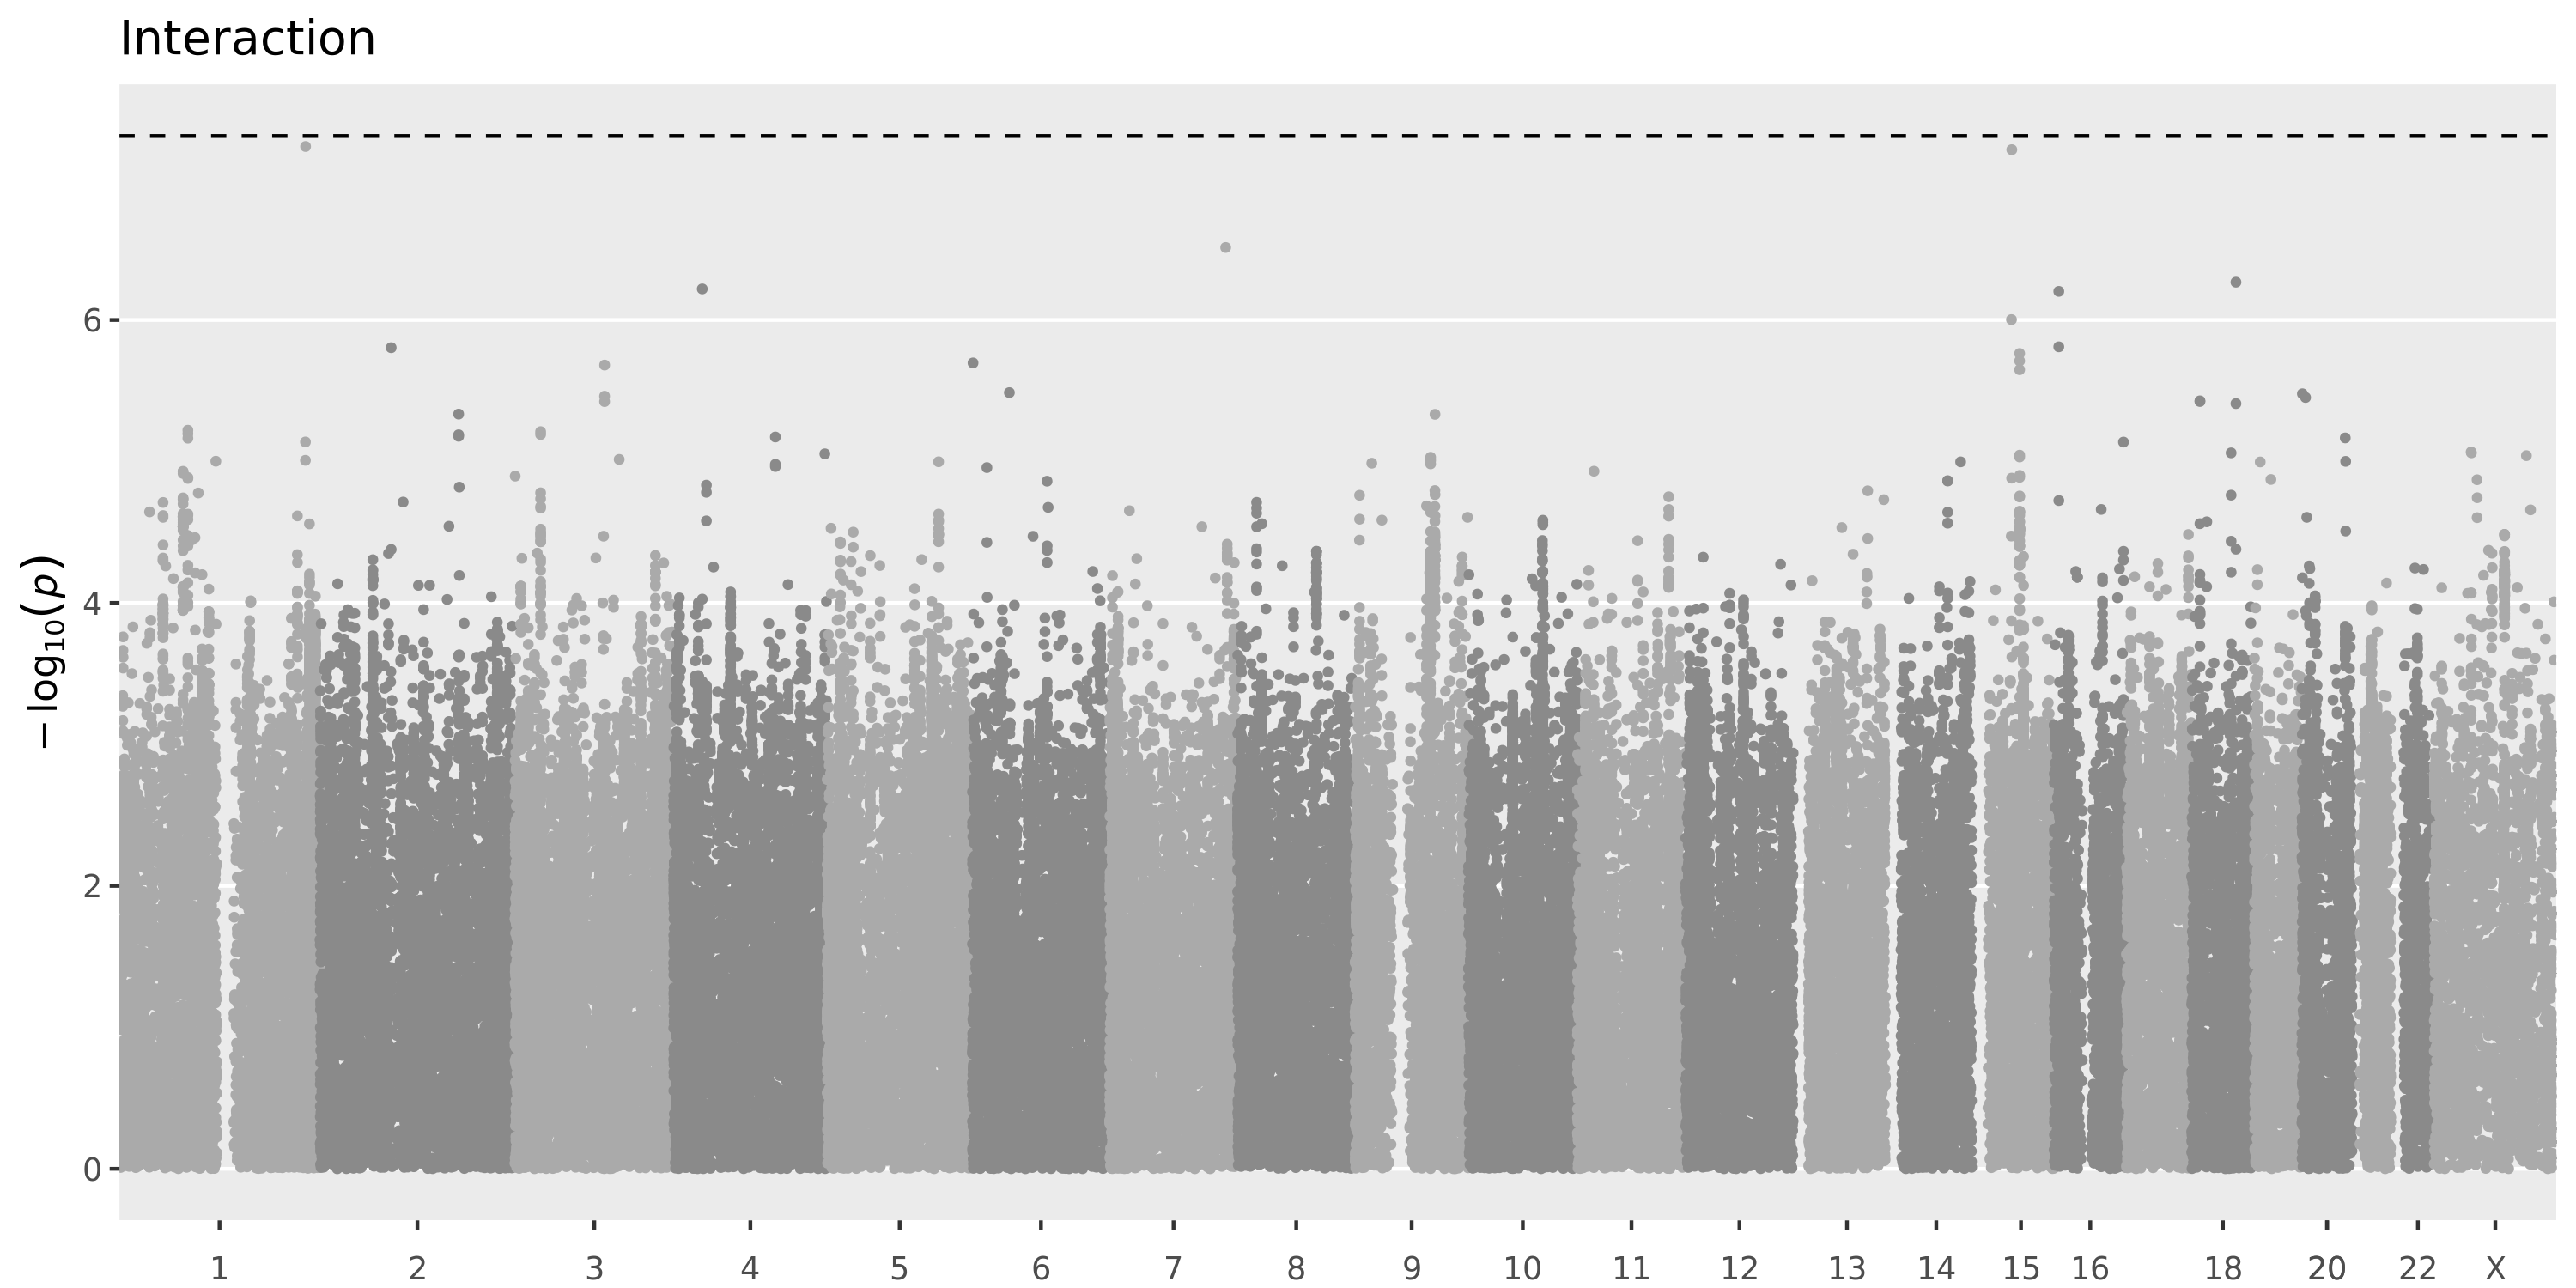

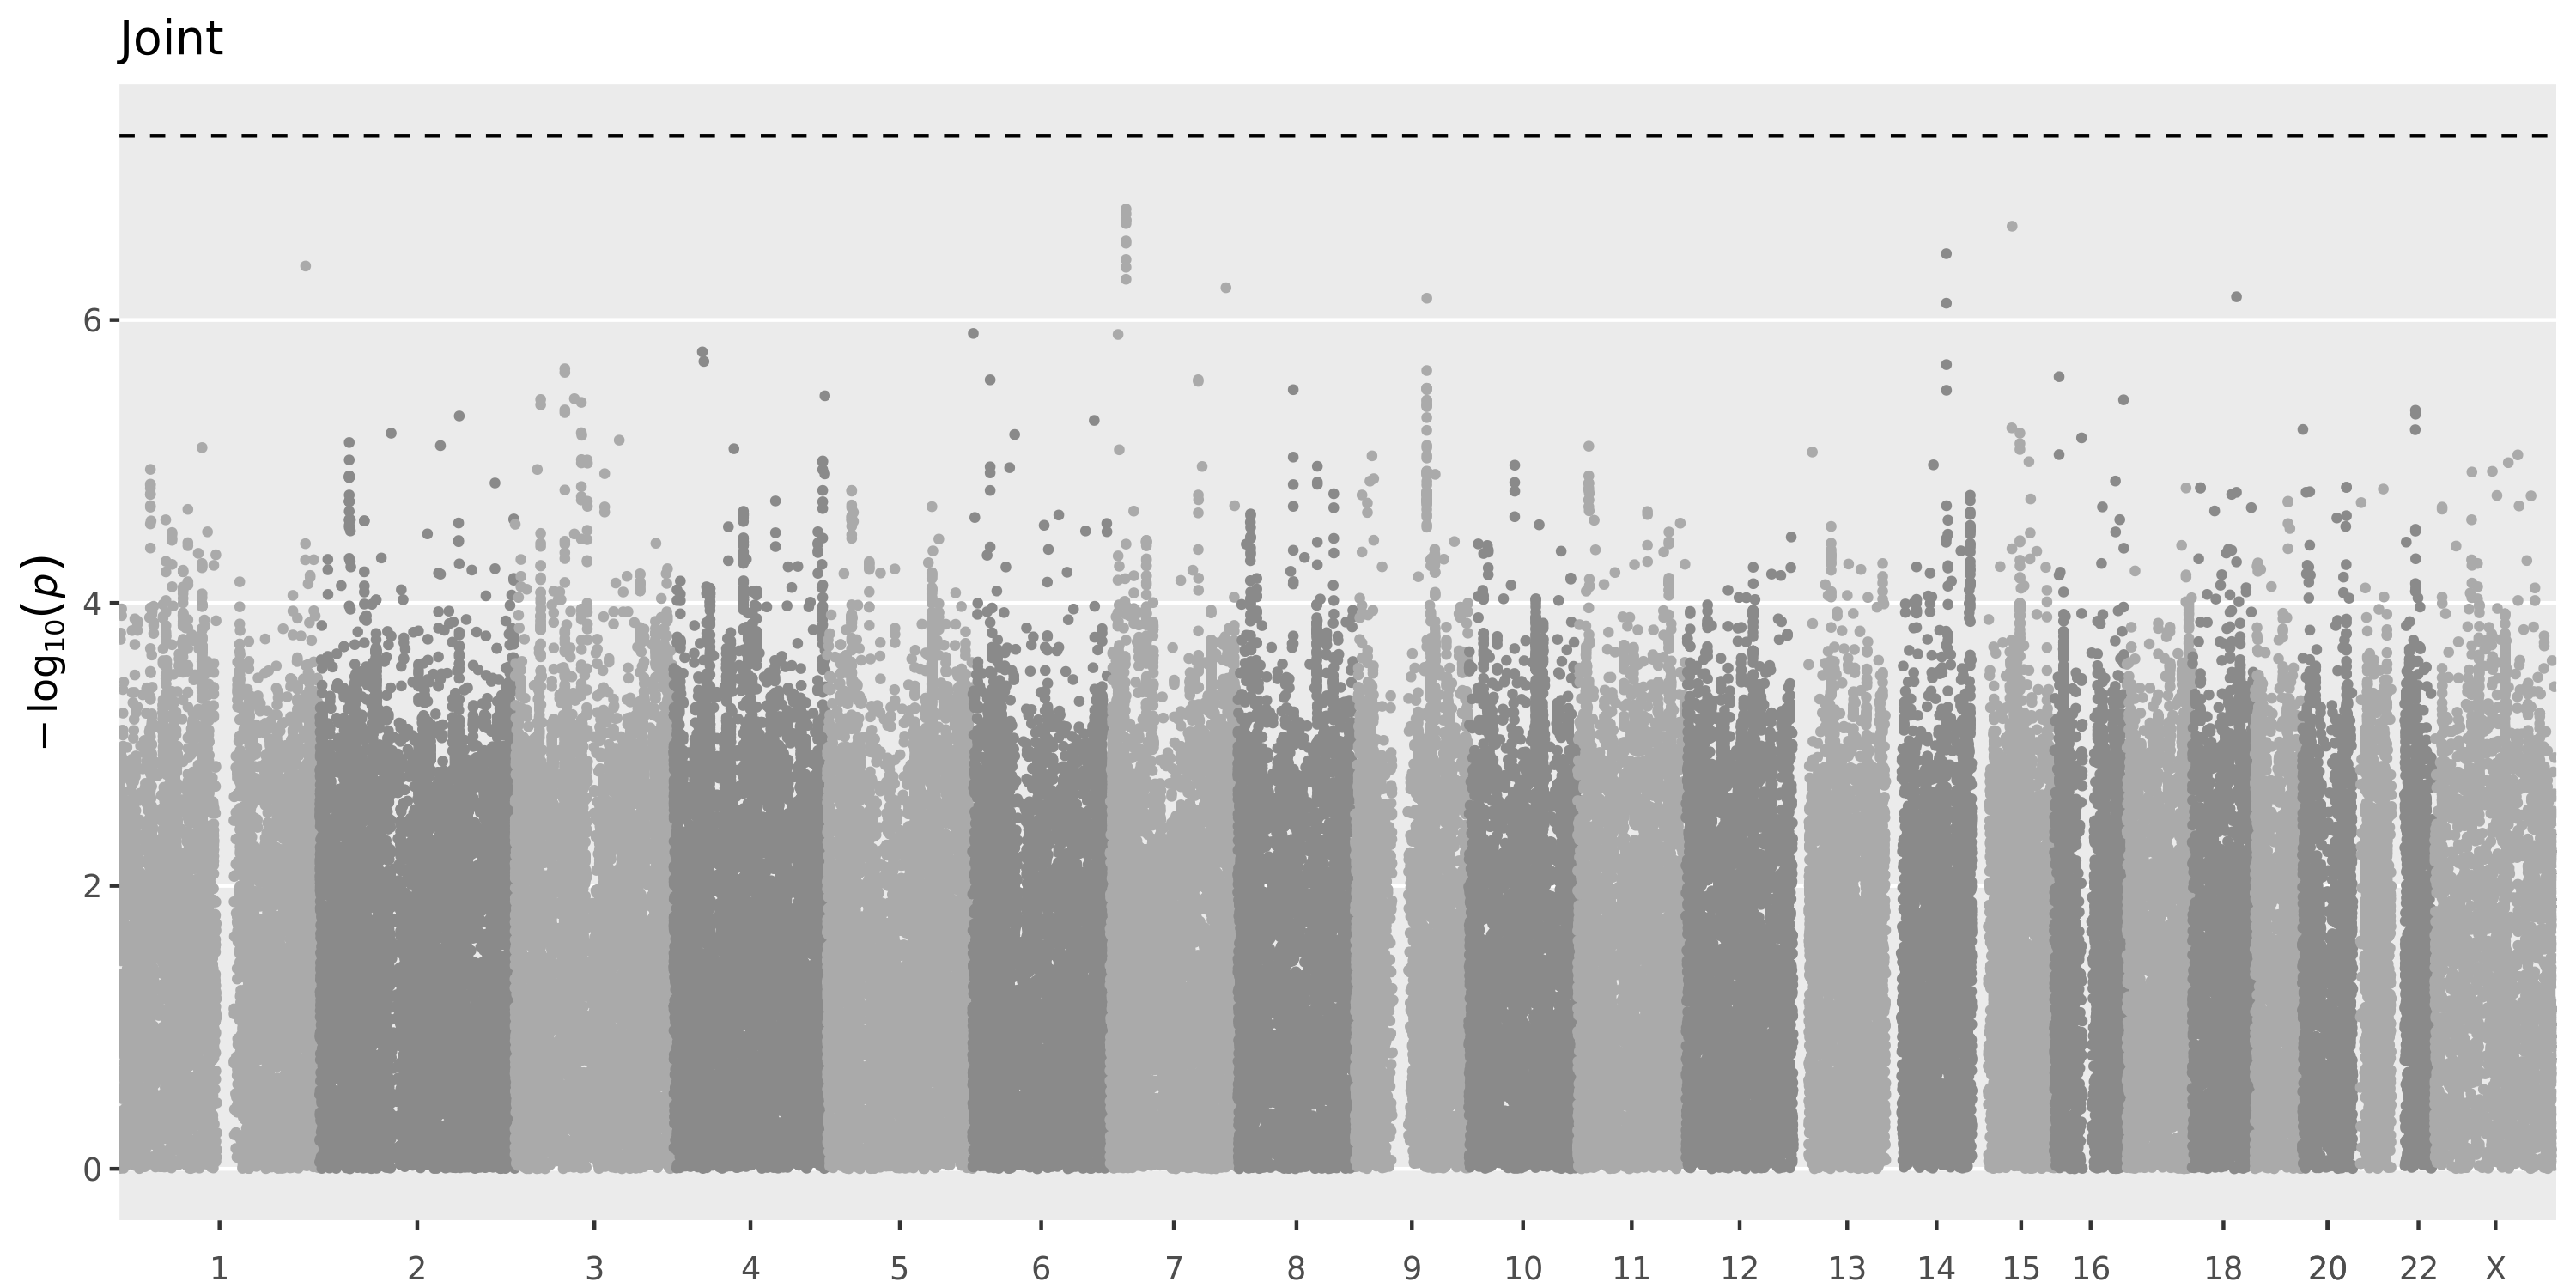

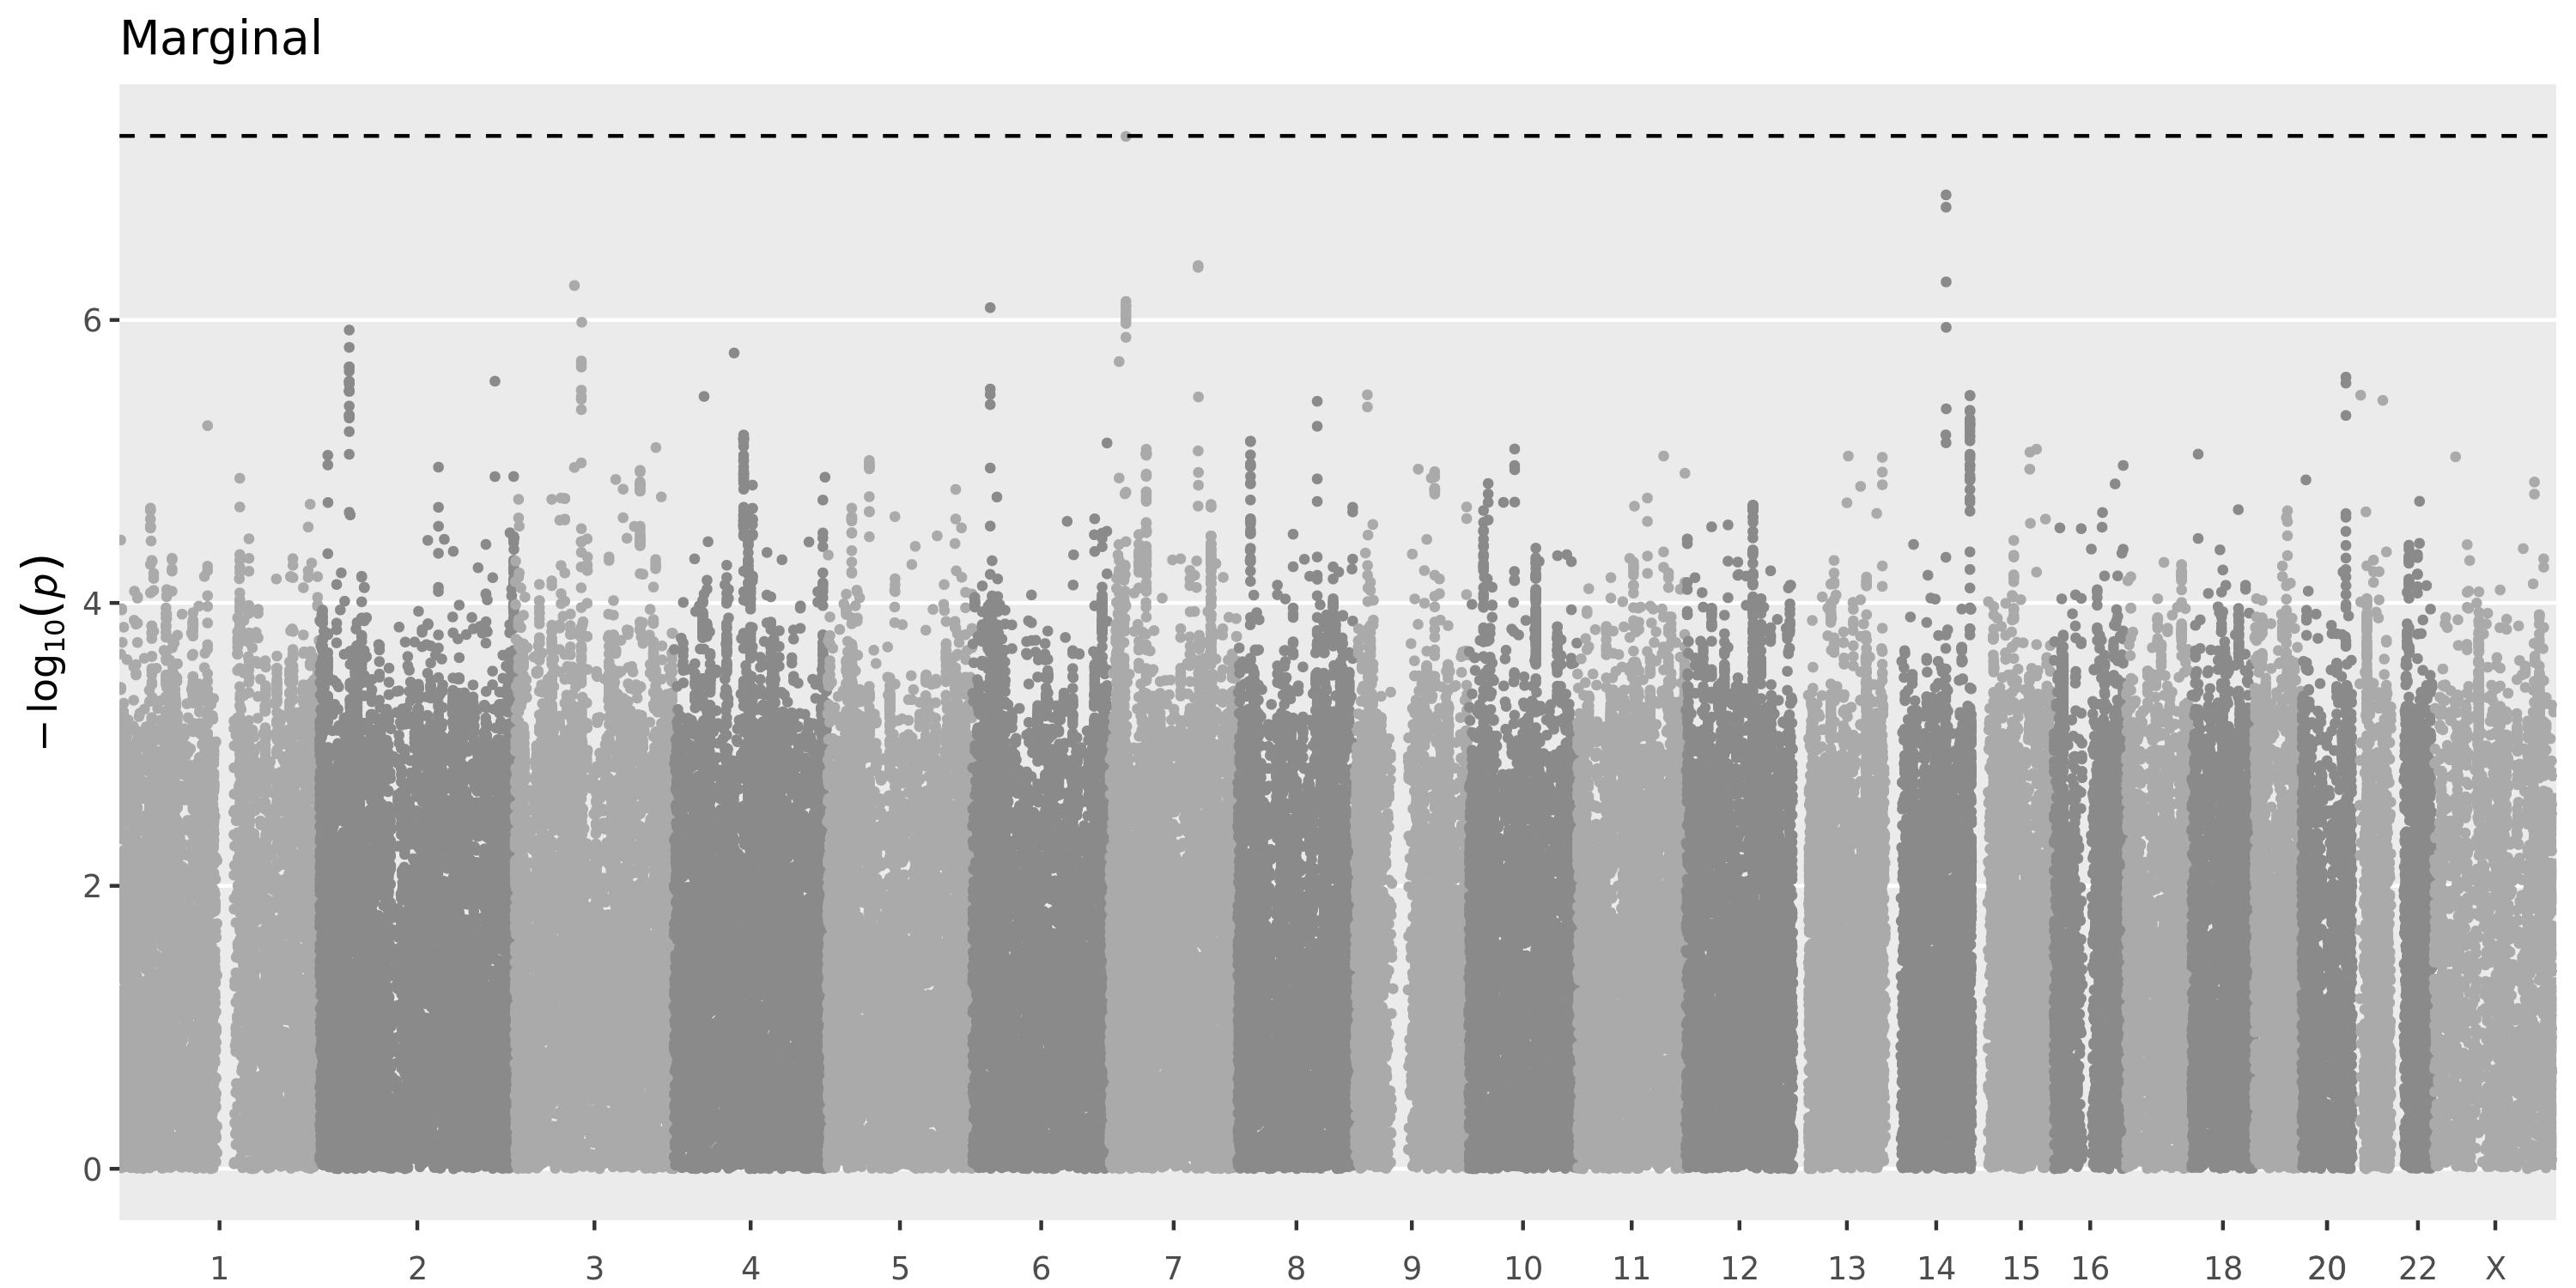

In [18]:
make_manhattan(mdi_res, "P_Value_Interaction", main="Interaction")
make_manhattan(mdi_res, "P_Value_Joint", main="Joint")
make_manhattan(mdi_res, "P_Value_Marginal", main="Marginal")

## Pruning

Pruning will be rudimentary here -- distance-based method defining a locus as +/- 500kb around the most significant hit in each suggestive (P-interaction < 1e-6) region.

In [18]:
prune_chromosome <- function(chr_df, pval_col, locus_width) {
  # Prune variants given a chromosome-specific summary statistic data frame
  df <- arrange(chr_df, !!sym(pval_col))  # Sort by ascending p-value
  pruned_df <- tibble()
  while(nrow(df) > 0) {
    pruned_df <- bind_rows(pruned_df, df[1, ])  # Add lowest p-value to pruned dataset
    df <- filter(df, (POS < df$POS[1] - locus_width / 2) |  # Remove rest of variants in that distance-based locus
                   (POS > df$POS[1] + locus_width / 2))
  }
  pruned_df
}

prune_suggestive_variants <- function(ss_df, pval_col, sugg_thresh=1e-5, locus_width=1e6) {
  # Prune variants across all chromosomes using a simple distance-based approach
  ss_df %>%
    filter(!!sym(pval_col) < sugg_thresh) %>%
    nest(data=-CHR) %>%
    mutate(pruned_ss=map(data, prune_chromosome, pval_col, locus_width)) %>%
    unnest(pruned_ss) %>%
    select(-data) %>%
    dplyr::rename(index_var=RSID)
}

sex_res_int_pruned <- prune_suggestive_variants(sex_res, "P_Value_Interaction")
sex_res_joint_pruned <- prune_suggestive_variants(sex_res, "P_Value_Joint")
cm_res_int_pruned <- prune_suggestive_variants(cm_res, "P_Value_Interaction")
cm_res_joint_pruned <- prune_suggestive_variants(cm_res, "P_Value_Joint")
mdi_res_int_pruned <- prune_suggestive_variants(mdi_res, "P_Value_Interaction")
mdi_res_joint_pruned <- prune_suggestive_variants(mdi_res, "P_Value_Joint")

## Export potential hits for retrieval of genotypes and downstream testing

In [19]:
sugg_dfs_list <- list(
    sex_int = sex_res_int_pruned,
    sex_joint = sex_res_joint_pruned,
    CM_int = cm_res_int_pruned,
    CM_joint = cm_res_joint_pruned,
    mdi_int = mdi_res_int_pruned,
    mdi_joint = mdi_res_joint_pruned
)
sugg_rsids_list <- map(sugg_dfs_list, "index_var")
sugg_chrpos_list <- map(sugg_dfs_list, function(x) {
    paste(x$CHR, x$POS, sep=":")
})

In [20]:
 system(paste0("gsutil cp ", ws_bucket, "/results/FUMA_snps_v2.txt ."))
 fuma_pruned_df <- read_tsv("FUMA_snps_v2.txt", col_types=cols())
 write(fuma_pruned_df$rsID, "fuma_suggestive_rsids.txt")
 system(paste0("gsutil cp fuma_suggestive_rsids.txt ", ws_bucket, "/results/"))

system(paste0("gsutil cp ", ws_bucket, "/results/sig_*.csv ."))
fuma_outputs <- bind_rows(list(
    sex = read_tsv("sig_sex_var.csv", col_types=cols(`Location (CHR:POS)`="c")),
    cm = read_tsv("sig_cm_var.csv", col_types=cols(`Location (CHR:POS)`="c")),
    mdi = read_tsv("sig_mdi_var.csv", col_types=cols(`Location (CHR:POS)`="c"))
), .id="analysis") %>%
    rename(CHRPOS = `Location (CHR:POS)`)

In [21]:
all_sugg_rsids <- unique(c(unlist(sugg_rsids_list), fuma_outputs$RSID))

write(all_sugg_rsids, "all_sugg_rsids.txt")
all_sugg_chrpos <- unique(c(unlist(sugg_chrpos_list), fuma_outputs$CHRPOS))
all_sugg_chrpos <- ifelse(grepl("^[1-9]:", all_sugg_chrpos),  # Single-digit chromosomes should start with "0"
                          paste0("0", all_sugg_chrpos), all_sugg_chrpos)
write(all_sugg_chrpos, "all_sugg_chrpos.txt")
system(paste0("gsutil cp all_sugg_rsids.txt all_sugg_chrpos.txt ", ws_bucket))

In [22]:
paste0("gsutil cp all_sugg_rsids.txt all_sugg_chrpos.txt ", ws_bucket)

[1] "gsutil cp all_sugg_rsids.txt all_sugg_chrpos.txt gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc"

In [23]:
length(all_sugg_rsids)
length(all_sugg_chrpos)

[1] 232

[1] 235

# Follow-up at top loci

## Read in subset of interesting SNPs (dosages)

In [24]:
phenos <- fread("covid_interaction_phenotypes_EUR.csv", data.table=F, stringsAsFactors=F) %>%
  mutate(id = as.character(id))

In [25]:
suggestive_bgen <- "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/e0c25606-21e5-4c6b-8b69-a933bf0122fd/subset_genotypes/fd9d6776-8e02-47ba-b530-227d31973865/call-concatenate/concat.bgen"
system(paste0("gsutil cp ", suggestive_bgen, " suggestive.bgen"))
suggestive_sample <- "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/ukb27892_imp_chrAUT_v3_s487395.sample"
system(paste0("gsutil cp ", suggestive_sample, " suggestive.sample"))
suggestive_bgen_chrX <- "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/5466b782-75fa-4c1b-a0bb-dc98aa6d7541/subset_genotypes/73de6e3d-19d4-4247-a9c8-919000e51bab/call-concatenate/concat.bgen"
system(paste0("gsutil cp ", suggestive_bgen_chrX, " suggestive_chrX.bgen"))
suggestive_sample_chrX <- "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/ukb27892_imp_chrX_v3_s486743.sample"
system(paste0("gsutil cp ", suggestive_sample_chrX, " suggestive_chrX.sample"))

In [26]:
bgenInfo <- open_bgen("suggestive.bgen")
snp_df <- tibble(id = bgenInfo$SampleID)
print(bgenInfo$M)
for (i in 1:bgenInfo$M) {
    next_snp <- query_bgen()
    snp_df[[next_snp$RSID]] <- next_snp$Dosages
}
close_bgen()

bgenInfo_chrX <- open_bgen("suggestive_chrX.bgen")
snp_df_chrX <- tibble(id = bgenInfo_chrX$SampleID)
print(bgenInfo_chrX$M)
for (i in 1:bgenInfo_chrX$M) {
    next_snp <- query_bgen()
    snp_df_chrX[[next_snp$RSID]] <- next_snp$Dosages
}
close_bgen()

followup_df <- phenos %>%
    inner_join(snp_df, by="id") %>%
    inner_join(snp_df_chrX, by="id")

[1] 242
End of BGEN file has been reached. Please close the file with close_bgen().


[1] "BGEN file closed successfully."

[1] 40
End of BGEN file has been reached. Please close the file with close_bgen().


[1] "BGEN file closed successfully."

## QC/sensitivity analysis for robustness

Concern is that the combination of case-control imbalance + low MAF is causing spurious hits for some of these variants.

### Calculation of minor alle counts across case and exposure strata

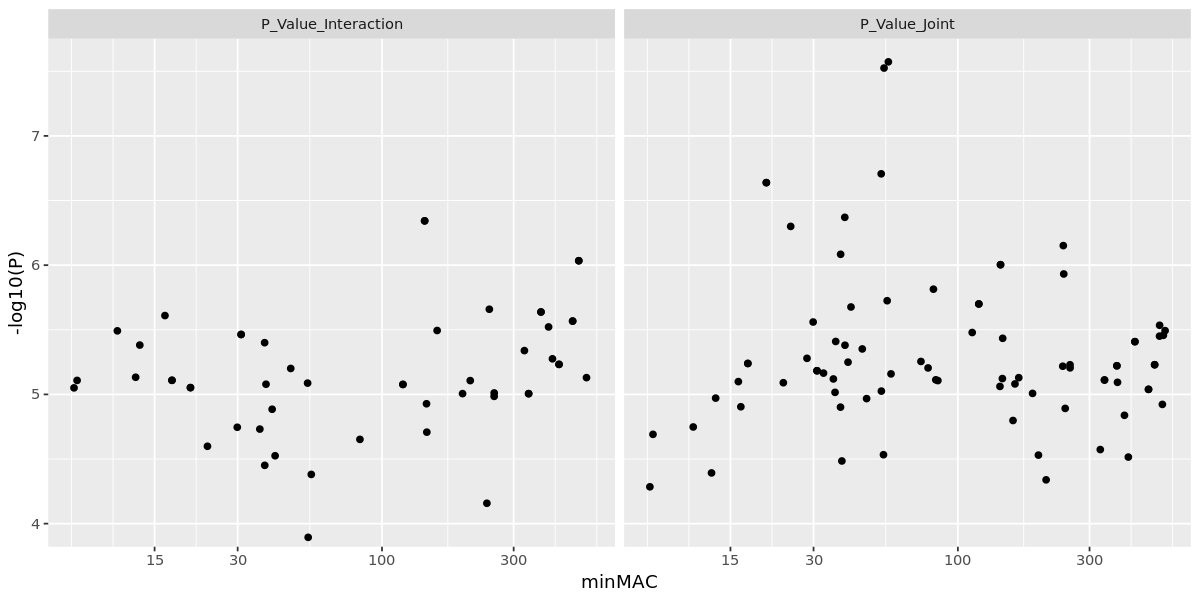

In [27]:
# Sex analysis
sex_minMAC_df <- followup_df %>%
  select(sexMale, case_b2, any_of(c(sugg_rsids_list$sex_int, sugg_rsids_list$sex_joint))) %>%
  group_by(sexMale, case_b2) %>%
  summarise_all(~sum(pmin(., 2 - .)), .groups="drop") %>%  # Sum of dosages or 2 - dosages if major allele is counted
  pivot_longer(names_to="RSID", values_to="MAC", !c("sexMale", "case_b2")) %>%
  group_by(RSID) %>%
  summarise(minMAC = min(MAC))

bind_rows(sex_res_int_pruned, sex_res_joint_pruned) %>%
  rename(RSID=index_var) %>%
  inner_join(sex_minMAC_df, by="RSID") %>%
  select(minMAC, P_Value_Joint, P_Value_Interaction) %>%
  pivot_longer(names_to="P_type", values_to="P", !"minMAC") %>%
  ggplot(aes(x=minMAC, y=-log10(P))) +
  geom_point() +
  scale_x_log10(breaks=c(15, 30, 100, 300)) +
  coord_cartesian(ylim=c(4, NA)) +
  facet_wrap(~P_type)

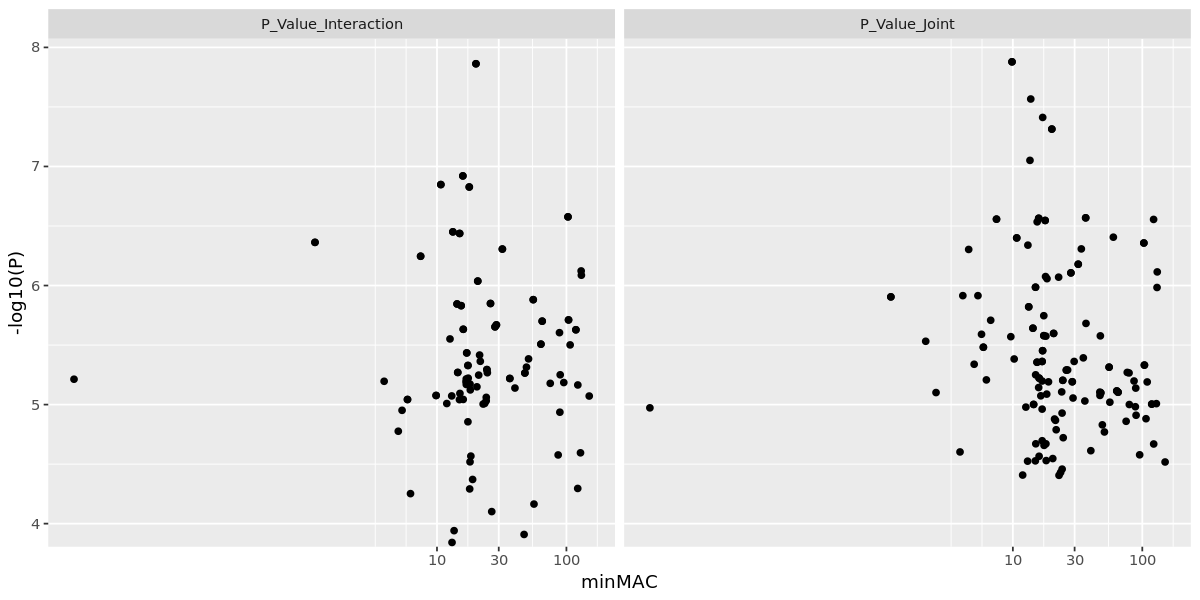

In [28]:
# Cardiometabolic analysis
CM_minMAC_df <- followup_df %>%
  select(t2d, case_b2, any_of(c(sugg_rsids_list$CM_int, sugg_rsids_list$CM_joint))) %>%
  group_by(t2d, case_b2) %>%
  summarise_all(~sum(pmin(., 2 - .)), .groups="drop") %>%  # Sum of dosages or 2 - dosages if major allele is counted
  pivot_longer(names_to="RSID", values_to="MAC", !c("t2d", "case_b2")) %>%
  group_by(RSID) %>%
  summarise(minMAC = min(MAC))

bind_rows(cm_res_int_pruned, cm_res_joint_pruned) %>%
  rename(RSID=index_var) %>%
  inner_join(CM_minMAC_df, by="RSID") %>%
  select(minMAC, P_Value_Joint, P_Value_Interaction) %>%
  pivot_longer(names_to="P_type", values_to="P", !"minMAC") %>%
  ggplot(aes(x=minMAC, y=-log10(P))) +
  geom_point() +
  scale_x_log10(breaks=c(10, 30, 100, 300)) +
  coord_cartesian(ylim=c(4, NA)) +
  facet_wrap(~P_type)

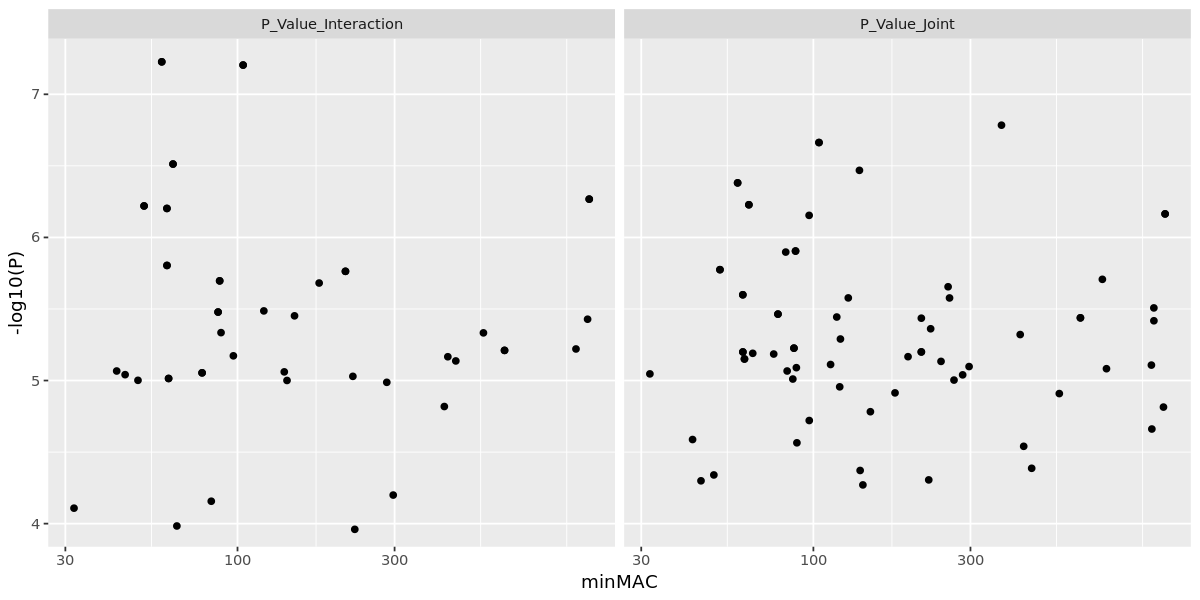

In [29]:
# SDH analysis
mdi_minMAC_df <- followup_df %>%
  select(t2d, case_b2, any_of(c(sugg_rsids_list$mdi_int, sugg_rsids_list$mdi_joint))) %>%
  group_by(case_b2) %>%
  summarise_all(~sum(pmin(., 2 - .)), .groups="drop") %>%  # Sum of dosages or 2 - dosages if major allele is counted
  pivot_longer(names_to="RSID", values_to="MAC", !c("case_b2")) %>%
  group_by(RSID) %>%
  summarise(minMAC = min(MAC))

bind_rows(mdi_res_int_pruned, mdi_res_joint_pruned) %>%
  rename(RSID=index_var) %>%
  inner_join(mdi_minMAC_df, by="RSID") %>%
  select(minMAC, P_Value_Joint, P_Value_Interaction) %>%
  pivot_longer(names_to="P_type", values_to="P", !"minMAC") %>%
  ggplot(aes(x=minMAC, y=-log10(P))) +
  geom_point() +
  scale_x_log10(breaks=c(10, 30, 100, 300)) +
  coord_cartesian(ylim=c(4, NA)) +
  facet_wrap(~P_type)

"minMAC" here is the minimum minor allele count across all combinations of sex (exposure) and case status (outcome). Our potential concern here would be that highly-significant variants would be those with very low minMAC values. However, these MACs are still above thresholds that have been used before for interaction analysis (ex. minimum minMAC of 10 was used in Sung et al. 2016, *Genet. Epidemiol.*).

### SPAGE

In [30]:
if (!require(SPAGE)) devtools::install_github('WenjianBi/SPAGE', dep=F)
if (!require(sandwich)) install.packages("sandwich")
if (!require(lmtest)) install.packages("lmtest")

Loading required package: SPAGE

Loading required package: sandwich

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [31]:
# nullmod <- SPAGE_Null_Model(case_b2 ~ sexMale + age + PC1 + PC2 + PC3, 
#                  subjectID = followup_df$id, 
#                  data = followup_df, 
#                  out_type="D")
# env_mat <- matrix(followup_df$sex, dimnames=list(followup_df$id, "sex"))
# geno_mat <- as.matrix(followup_df[, setdiff(names(snp_df), "id")])
# rownames(geno_mat) <- followup_df$id

# spage_res <- SPAGE(obj.null=nullmod, 
#       Envn.mtx=env_mat, 
#       Geno.mtx=geno_mat,
#       Cutoff=0,
#       BetaG.SPA=TRUE) %>%
#   as.data.frame() %>%
#   rownames_to_column(var="RSID")

# spage_res_noSPA <- SPAGE(obj.null=nullmod, 
#       Envn.mtx=env_mat, 
#       Geno.mtx=geno_mat,
#       Cutoff=0,
#       BetaG.SPA=FALSE) %>%
#   as.data.frame() %>%
#   rownames_to_column(var="RSID")

# save("spage_res", "spage_res_noSPA", file="SPAGE_results.RData")

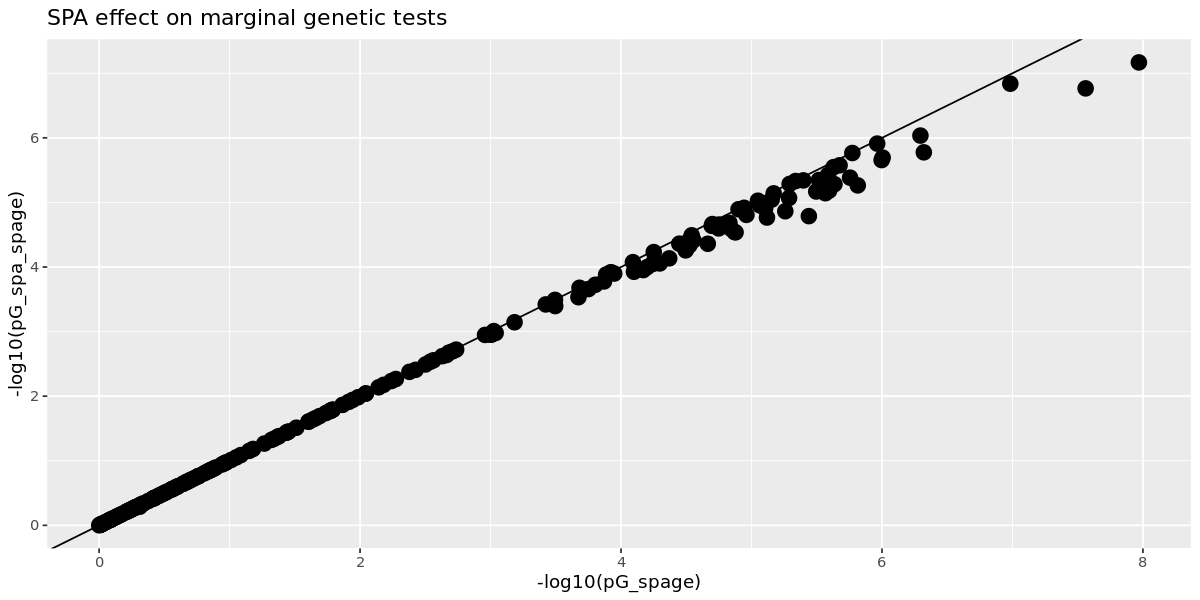

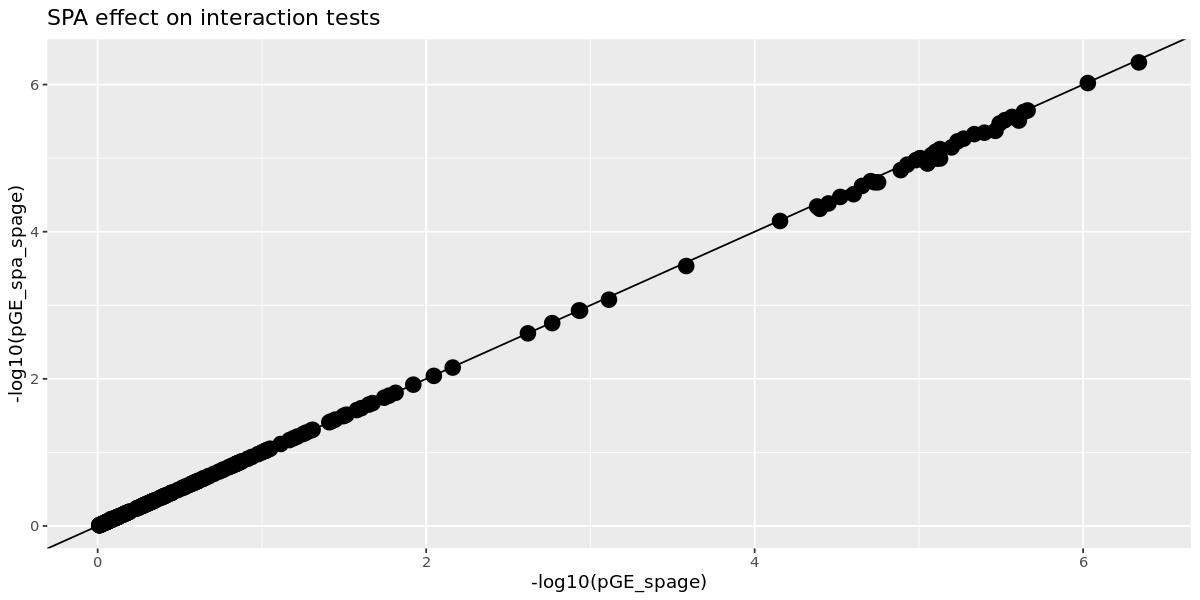

In [32]:
load("SPAGE_results.RData")

spa_compare <- inner_join(
  select(spage_res, RSID, pG_spa_spage=p.value.BetaG, 
         pGE_spage=`p.value.norm-sex`, pGE_spa_spage=`p.value.spa-sex`),
  select(spage_res_noSPA, RSID, pG_spage=p.value.BetaG),
  by="RSID"
)

spa_compare %>%
  ggplot(aes(x=-log10(pG_spage), y=-log10(pG_spa_spage))) + 
  geom_point(size=4) +
  geom_abline(slope=1, intercept=0) +
#   scale_color_continuous(type="viridis") + 
  labs(title="SPA effect on marginal genetic tests")

spa_compare %>%
  ggplot(aes(x=-log10(pGE_spage), y=-log10(pGE_spa_spage))) +
  geom_point(size=4) +
  geom_abline(slope=1, intercept=0) +
#   scale_color_continuous(type="viridis") + 
  labs(title="SPA effect on interaction tests")

Before comparing to GEM results, we can check whether the saddlepoint approximation (SPA) is having a substantial impact on p-values. The results above show that there is minimal impact of the SPA on either marginal or interaction p-values. The SPA raises p-values modestly for the more-significant marginal test variants.

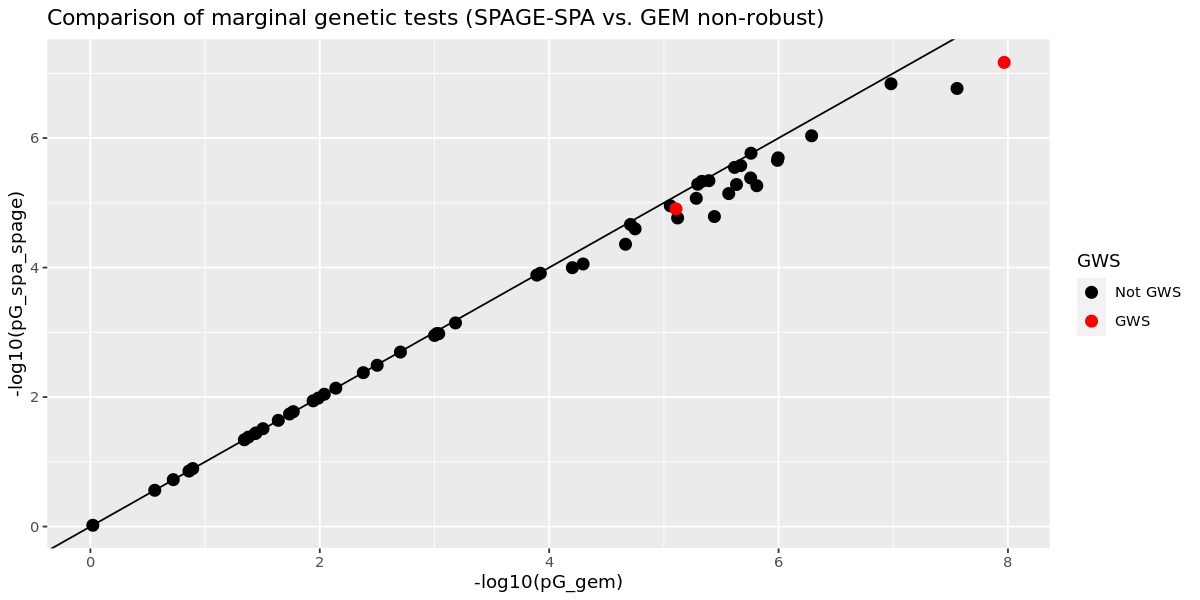

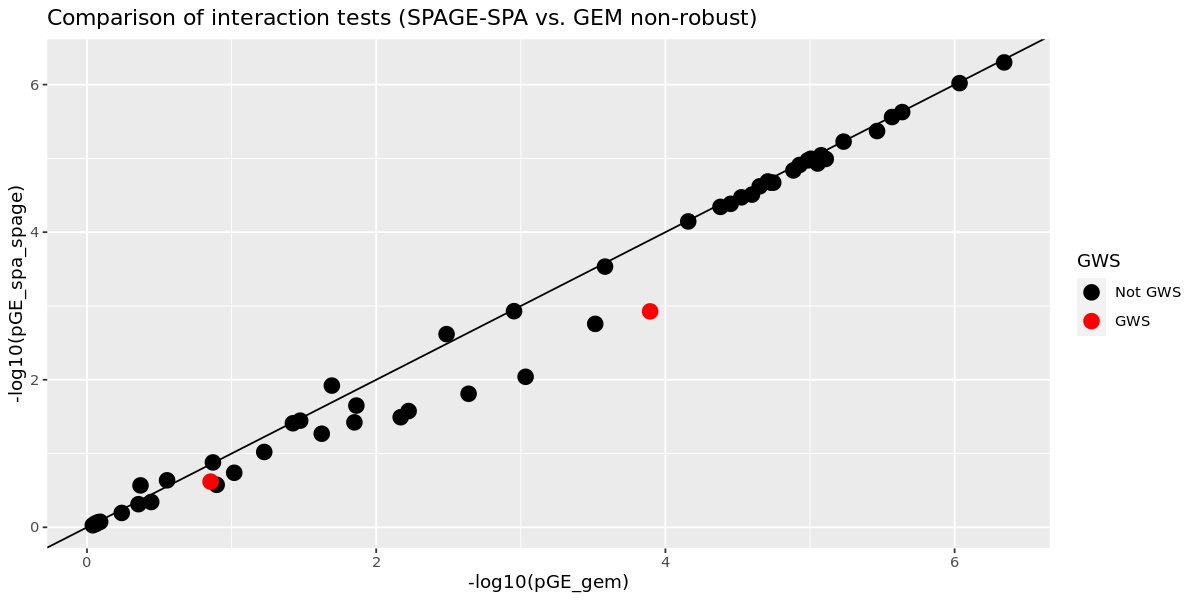

In [33]:
spage_compare <- spa_compare %>%
  inner_join(select(sex_res_joint_pruned, RSID=index_var, 
                    pG_gem=P_Value_Marginal, pGE_gem=P_Value_Interaction, pJ_gem=P_Value_Joint),
             by="RSID") %>%
  mutate(GWS = factor(pJ_gem < 5e-8, labels=c("Not GWS", "GWS"))) %>%
  arrange(GWS)

spage_compare %>%
    ggplot(aes(x=-log10(pG_gem), y=-log10(pG_spa_spage), color=GWS)) +
    geom_point(size=3) +
    geom_abline(slope=1, intercept=0) +
    scale_color_manual(values=c("black", "red")) + 
    labs(title="Comparison of marginal genetic tests (SPAGE-SPA vs. GEM non-robust)")

spage_compare %>%
    ggplot(aes(x=-log10(pGE_gem), y=-log10(pGE_spa_spage), color=GWS)) +
    geom_point(size=4) +
    geom_abline(slope=1, intercept=0) +
    scale_color_manual(values=c("black", "red")) +
    labs(title="Comparison of interaction tests (SPAGE-SPA vs. GEM non-robust)")

P-values for the marginal test are quite similar in general. For the interaction test, there appears to be a group of variants with non-negligibly lower significance using the SPA correction, and one of the significant joint test variants belongs to this group.

NOTE: In a previous version of the analysis (with substantially lower sample size), some random isolated variants were highly significant in the joint test. A series of sensitivity analyses comparing GEM (robust vs. non-robust) and SPAGE (SPA vs. no-SPA) were conducted to assess the root of the problem. The primary takeaway was that use of robust standard errors in this context (low sample size with binary outcome) caused a notable, and spurious, increase in significance of the genetic main effect.

## Visualization at loci of interest

In [34]:
gw_loci_df <- filter(fuma_outputs, (GEM_p_interaction < 5e-8) | (GEM_p_joint < 5e-8) | (`HGI all_inv_var_meta_p` < 0.05))
gw_loci <- unique(gw_loci_df$RSID)
gw_loci_df

analysis RSID             CHRPOS      FUMA                                
1 sex      rs345361         4:86777776  cm_joint                            
2 sex      rs2268616        14:75419444 mdi_joint, sex_joint (sig), cm_joint
3 sex      2:218260234_AC_A 2:218260230 sex_joint                           
4 cm       rs11115199       12:82510665 cm_int, cm_joint                    
5 cm       rs345361         4:86777776  cm_joint                            
6 cm       rs148793499      18:58314588 cm_joint                            
7 cm       rs2268616        14:75419444 mdi_joint, sex_joint (sig), cm_joint
8 mdi      rs345361         4:86777776  cm_joint                            
  FUMA GWAS Interaction P_Value HGI all_inv_var_meta_p Non_Effect_Allele
1 4.9299999999999998E-7         0.008259               A                
2 3.4E-07, 2.6728E-08, 3.87E-08 0.731200               A                
3 2.9900000000000003E-8               NA               AC               
4 1.37E-8                       0.721300               G                
5 4.9299999999999998E-7         0.008259               A                
6 1.3200000000000001E-8               NA               T                
7 3.4E-07, 2.6728E-08, 3.87E-08 0.731200               A                
8 4.9299999999999998E-7         0.008259               A                
  Effect_Allele GEM_n  AF        ⋯ Beta_Interaction_1 Var_Beta_Interaction_1_1
1 G             378051 0.9690560 ⋯ -0.16636200        2.84998e-02             
2 G             378051 0.0179341 ⋯  0.32451600        4.82769e-02             
3 A             378051 0.0256242 ⋯  0.73441800        3.67496e-02             
4 T                 NA 0.0204524 ⋯ -0.04449770        3.34750e-04             
5 G                 NA 0.9690440 ⋯ -0.01531330        2.37209e-04             
6 C                 NA 0.0102753 ⋯  0.12914900        7.40103e-04             
7 G                 NA 0.0179483 ⋯ -0.02426230        4.10054e-04             
8 G             323551 0.9686560 ⋯  0.00562424        2.96083e-05             
  GEM_p_marginal GEM_p_interaction GEM_p_joint N_Samples Beta_Interaction_2
1 1.09915e-05    3.24406e-01       3.90378e-05     NA           NA         
2 1.07885e-08    1.39689e-01       2.67280e-08     NA           NA         
3 7.83969e-06    1.27602e-04       2.98606e-08     NA           NA         
4 4.08961e-01    1.37218e-08       4.85379e-08 376777     2.058560         
5 2.23706e-05    8.46410e-04       4.92537e-07 376777    -0.937486         
6 5.76211e-05    8.38293e-06       1.32208e-08 376777    -0.304860         
7 3.86824e-09    2.63940e-01       3.87431e-08 376777     0.537890         
8 6.50480e-06    3.01318e-01       2.25229e-05     NA           NA         
  Var_Beta_Interaction_1_2 Var_Beta_Interaction_2_1 Var_Beta_Interaction_2_2
1          NA                       NA                     NA               
2          NA                       NA                     NA               
3          NA                       NA                     NA               
4 -0.00162838              -0.00162838              0.1199370               
5 -0.00126321              -0.00126321              0.0856323               
6 -0.00432392              -0.00432392              0.2654580               
7 -0.00221037              -0.00221037              0.1468240               
8          NA                       NA                     NA

### Useful functions

In [35]:
plot_df <- followup_df %>%
    mutate(sex = factor(sexMale, levels=c(0, 1), labels=c("Female", "Male")),
#            obesity = cut(bmi, c(0, 25, 30, 100), labels=c("Normal", "Overweight", "Obese")),
           obesity = cut(bmi, c(0, 30, 100), labels=c("Non-obese", "Obese")),
           obesity01 = as.integer(obesity),
           T2D = factor(t2d),
           mdi = cut(mdi, c(0, 10, 20, 200), labels=c("low", "middle", "high")))

make_main_effect_plot <- function(rsid, df) {
    options(repr.plot.width=8, repr.plot.height=6)
    me_plot_df <- df %>%
        mutate(g = factor(round(.[[rsid]]))) %>%
        group_by(g) %>%
        summarise(case_frac = sum(case_b2) / n(), 
                  se = ifelse(case_frac == 0, NA, sqrt(case_frac * (1 - case_frac) / n())),
                  .groups="drop")
    me_plot <- me_plot_df %>%
        ggplot(aes(x=g, y=case_frac)) +
        geom_errorbar(aes(ymin=case_frac - se, ymax=case_frac + se), position=position_dodge(), width=0.25) +
        geom_bar(stat="identity", position=position_dodge()) +
        labs(name="Genotype")
    me_plot
}

make_strat_plot <- function(rsid, exposure, df) {
    options(repr.plot.width=16, repr.plot.height=6)
    strat_plot_df <- df %>%
        mutate(g = factor(round(.[[rsid]])),
               e = .[[exposure]]) %>%
        group_by(g, e) %>%
        summarise(case_frac = sum(case_b2) / n(), 
                  se = ifelse(case_frac == 0, NA, sqrt(case_frac * (1 - case_frac) / n())),
                  .groups="drop")
    strat_plot_g_main <- strat_plot_df %>%
        ggplot(aes(x=g, y=case_frac, fill=e)) +
        geom_errorbar(aes(ymin=case_frac - se, ymax=case_frac + se), 
                      position=position_dodge(width=1), width=0.25) +
        geom_bar(stat="identity", position=position_dodge(width=1)) +
        scale_fill_discrete(name=exposure) +
        labs(x="Genotype")
        
    strat_plot_e_main <- strat_plot_df %>%
        ggplot(aes(x=e, y=case_frac, fill=g)) +
        geom_errorbar(aes(ymin=case_frac - se, ymax=case_frac + se), 
                      position=position_dodge(width=1), width=0.25) +
        geom_bar(stat="identity", position=position_dodge(width=1)) +
        scale_fill_discrete(name="Genotype") +
        labs(x=exposure)
    plot_grid(strat_plot_g_main, strat_plot_e_main)
}

run_int_regression <- function(rsid, exposure, df) {
    df$g <- df[[rsid]]
    df$e <- scale(df[[exposure]], center=TRUE, scale=FALSE)
    int_term <- paste("g *", "e", collapse="+")
    form_str <- paste0("case_b2 ~ ", int_term, 
                       ifelse(exposure == "sexMale", "", " + sexMale"),
                       " + age + PC1 + PC2 + PC3")
    glm_res <- glm(as.formula(form_str), data=df, family="binomial")
    broom::tidy(glm_res) %>%
        mutate(OR_estimate = exp(estimate))
}

run_main_effect_regression <- function(rsid, df) {
    # Input a pre-filtered df containing a certain stratum
    df$g <- df[[rsid]]
    form_str <- paste0("case_b2 ~ g + sexMale + age + PC1 + PC2 + PC3")
    glm_res <- glm(as.formula(form_str), data=df, family="binomial")
    broom::tidy(glm_res) %>%
        mutate(OR_estimate = exp(estimate)) %>%
        filter(term == "g")
}

In [36]:
table(followup_df$t2d)


     0      1 
361392  16659 

In [37]:
run_int_regression("rs114807731", "sexMale", followup_df)
run_main_effect_regression("rs114807731", filter(followup_df, sexMale == 1))
run_main_effect_regression("rs114807731", filter(followup_df, sexMale == 0))


term        estimate    std.error   statistic   p.value      OR_estimate
1 (Intercept) -6.13258592 0.153871028 -39.8553646 0.000000e+00 0.00217096 
2 g            0.14585861 0.097832397   1.4909030 1.359870e-01 1.15703259 
3 e            0.29523444 0.042250013   6.9877952 2.792397e-12 1.34344127 
4 age          0.01840113 0.002633596   6.9870751 2.806760e-12 1.01857148 
5 PC1         -3.27345377 1.322141219  -2.4758730 1.329108e-02 0.03787539 
6 PC2          0.35271797 1.530021887   0.2305313 8.176789e-01 1.42292978 
7 PC3         -1.63829450 1.970240102  -0.8315202 4.056798e-01 0.19431116 
8 g:e          0.68863269 0.189366656   3.6365044 2.763629e-04 1.99099136

term estimate  std.error statistic p.value      OR_estimate
1 g    0.5178918 0.1047897 4.942199  7.724617e-07 1.678485

term estimate   std.error statistic p.value   OR_estimate
1 g    -0.1726332 0.1577784 -1.09415  0.2738893 0.8414462

In [38]:
run_int_regression("rs117993077", "sexMale", followup_df)

term        estimate   std.error   statistic   p.value      OR_estimate
1 (Intercept) -6.1301620 0.153854251 -39.8439558 0.000000e+00 0.002176228
2 g            0.1965477 0.141745337   1.3866255 1.655560e-01 1.217193378
3 e            0.3024405 0.041822675   7.2314949 4.777061e-13 1.353157105
4 age          0.0183881 0.002633979   6.9811128 2.928511e-12 1.018558205
5 PC1         -3.2115314 1.322037475  -2.4292287 1.513098e-02 0.040294859
6 PC2          0.2979965 1.529480919   0.1948350 8.455221e-01 1.347157044
7 PC3         -1.6596451 1.970005590  -0.8424571 3.995322e-01 0.190206470
8 g:e          0.9802558 0.272148153   3.6019199 3.158757e-04 2.665138026

### rs345361

Suggestive for joint cardiometabolic but nominal genetic main effect (p ~ 0.008) in UKBB holdout HGI results

In [39]:
paste0("MAF = ", round(sum(followup_df[["rs345361"]]) / (2 * nrow(followup_df)), 3))

[1] "MAF = 0.969"

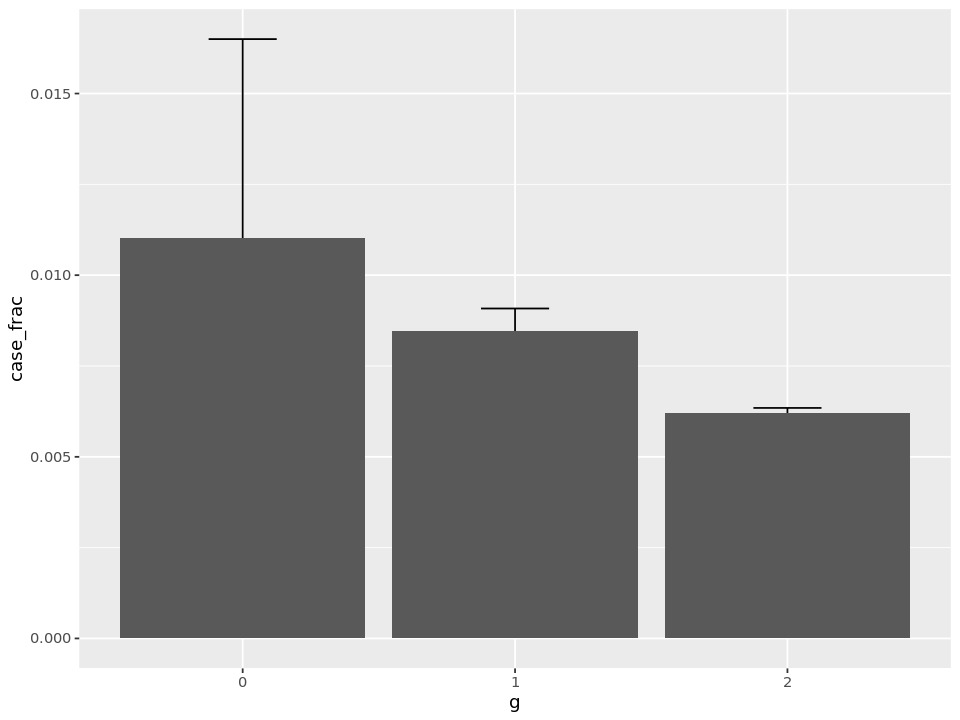

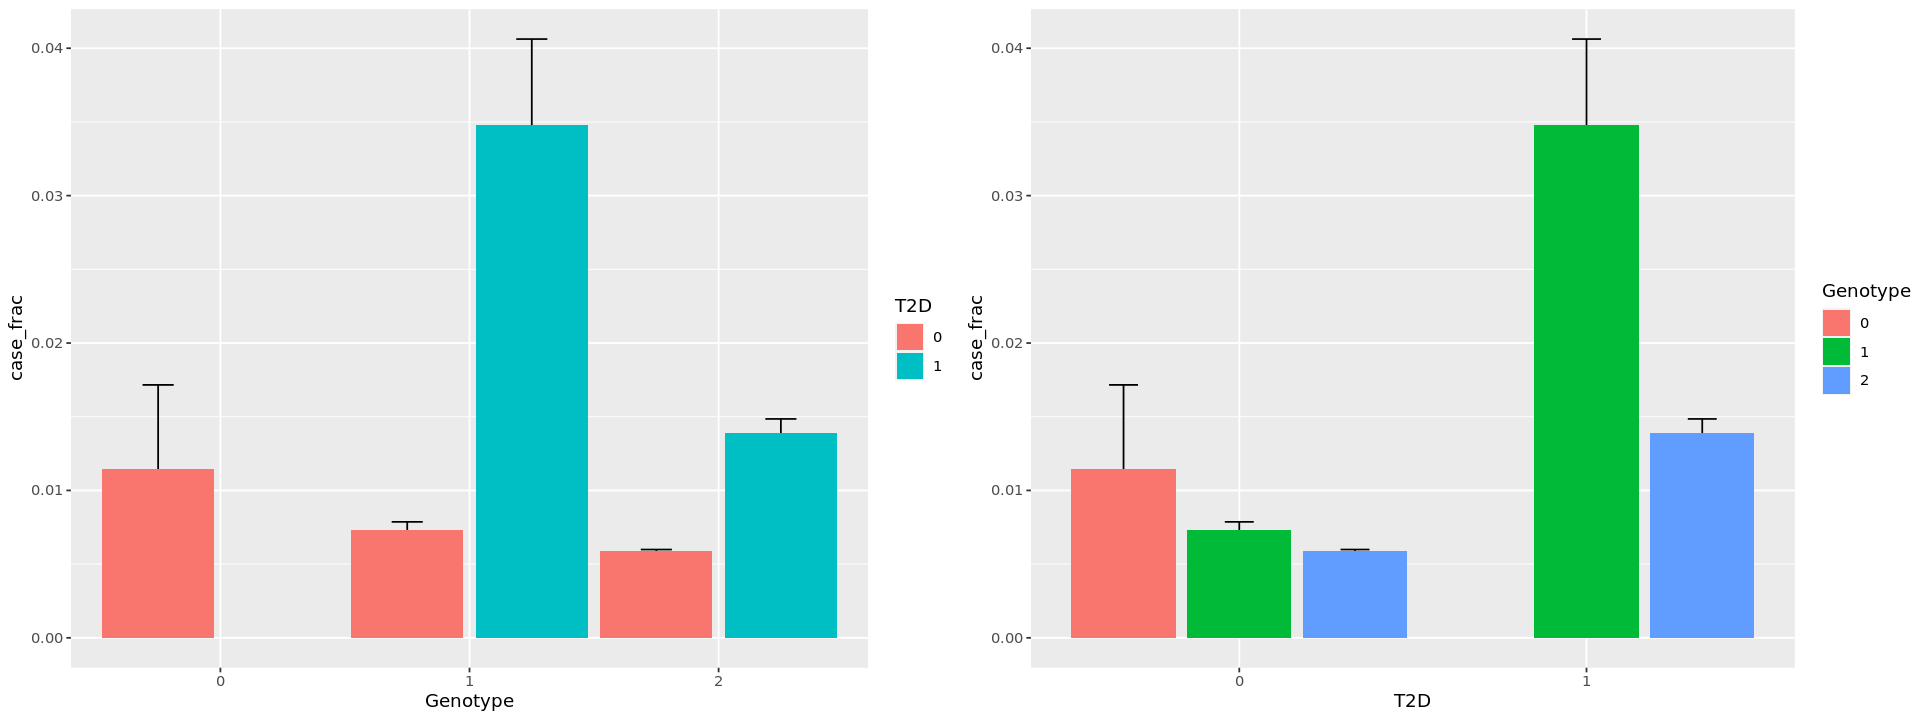

term        estimate    std.error   statistic   p.value       OR_estimate
1 (Intercept) -5.57532909 0.214084282 -26.0426829 1.628264e-149 0.003790228
2 g           -0.26633372 0.076570440  -3.4782838  5.046354e-04 0.766183395
3 e            2.02273215 0.379391231   5.3315206  9.739379e-08 7.558948952
4 sexMale      0.29180192 0.041391330   7.0498319  1.791341e-12 1.338837796
5 age          0.01512147 0.002657546   5.6900132  1.270295e-08 1.015236378
6 PC1         -3.40708011 1.322581325  -2.5760836  9.992647e-03 0.033137818
7 PC2          0.22691696 1.530040372   0.1483078  8.820998e-01 1.254725668
8 PC3         -1.69893053 1.970897150  -0.8620087  3.886827e-01 0.182879004
9 g:e         -0.62819980 0.198787888  -3.1601513  1.576872e-03 0.533551438

term        estimate    std.error   statistic    p.value       OR_estimate
1 (Intercept) -5.72839490 0.218085266 -26.26676708 4.599132e-152 0.003252293
2 g           -0.26695281 0.079160723  -3.37228867  7.454627e-04 0.765709206
3 e            0.10764513 0.023298421   4.62027568  3.832305e-06 1.113652470
4 sexMale      0.30257293 0.041333977   7.32019882  2.476038e-13 1.353336373
5 age          0.01694342 0.002658907   6.37232366  1.861854e-10 1.017087770
6 PC1         -2.89935262 1.324262678  -2.18940899  2.856713e-02 0.055058853
7 PC2          0.08798002 1.535849183   0.05728428  9.543187e-01 1.091966304
8 PC3         -1.60007046 1.980151793  -0.80805445  4.190592e-01 0.201882292
9 g:e         -0.02071710 0.012070376  -1.71635931  8.609630e-02 0.979496023

term estimate   std.error  statistic p.value     OR_estimate
1 g    -0.2392575 0.07965878 -3.00353  0.002668673 0.7872121

term estimate   std.error statistic p.value      OR_estimate
1 g    -0.8551795 0.1828197 -4.67772  2.900821e-06 0.4252069

term estimate   std.error statistic p.value     OR_estimate
1 g    -0.3443785 0.1184336 -2.907776 0.003640087 0.7086607

term estimate   std.error  statistic p.value     OR_estimate
1 g    -0.2854113 0.09380297 -3.042668 0.002344911 0.751705

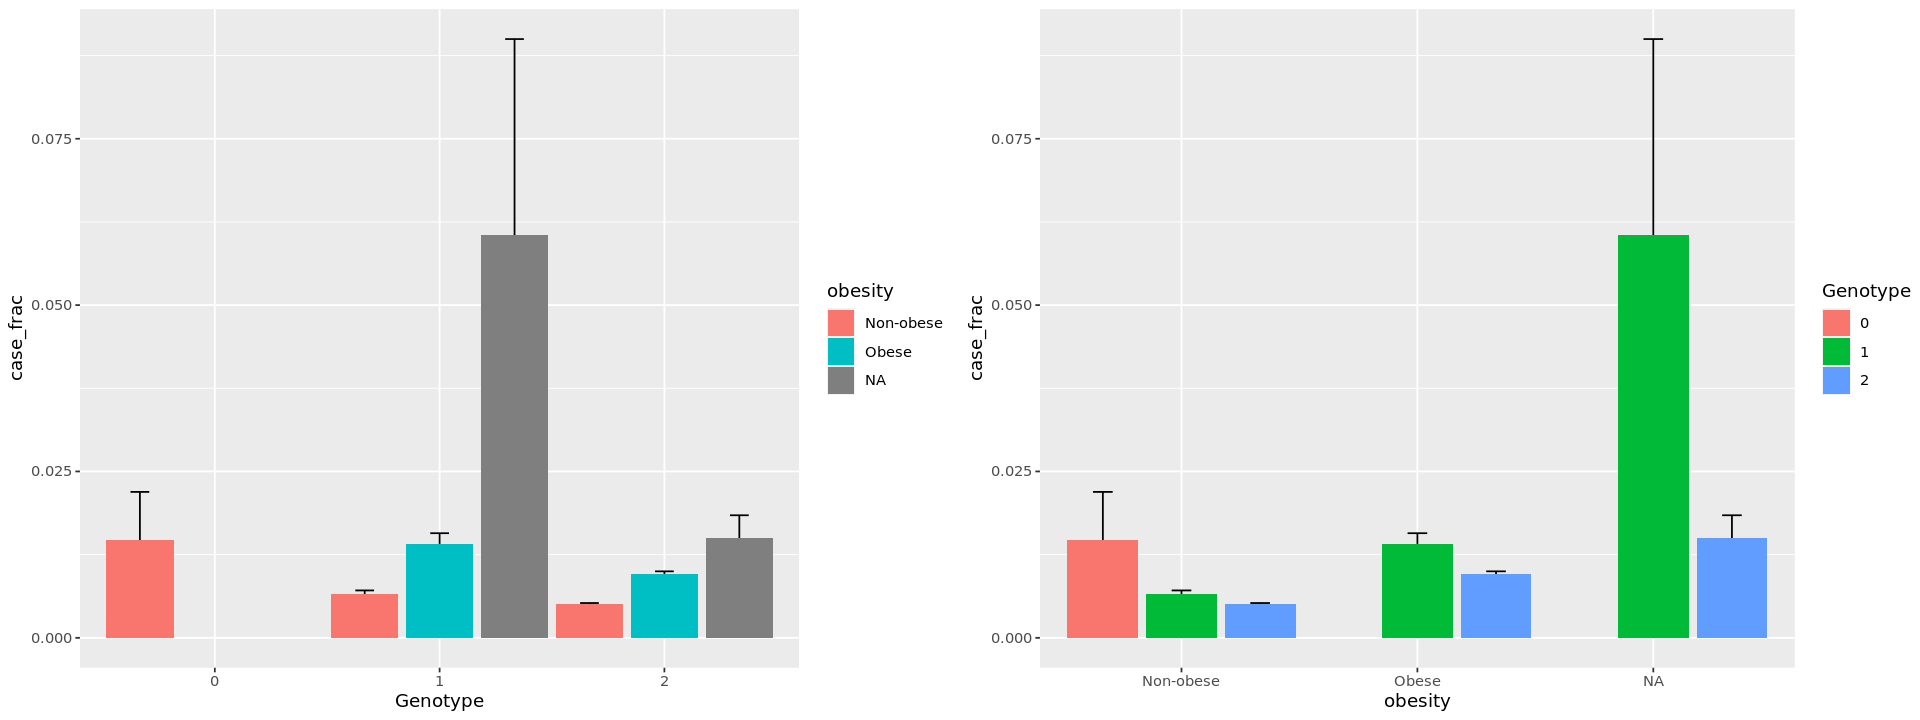

In [40]:
make_main_effect_plot("rs345361", plot_df)
make_strat_plot("rs345361", "T2D", plot_df)
make_strat_plot("rs345361", "obesity", plot_df)
run_int_regression("rs345361", "t2d", followup_df)
run_int_regression("rs345361", "bmi", followup_df)
run_main_effect_regression("rs345361", filter(followup_df, t2d == 0))
run_main_effect_regression("rs345361", filter(followup_df, t2d == 1))
run_main_effect_regression("rs345361", filter(followup_df, bmi > 30))
run_main_effect_regression("rs345361", filter(followup_df, bmi < 30))

### rs2268616

From joint test for every exposure

In [41]:
paste0("MAF = ", round(sum(followup_df[["rs2268616"]]) / (2 * nrow(followup_df)), 3))

[1] "MAF = 0.018"

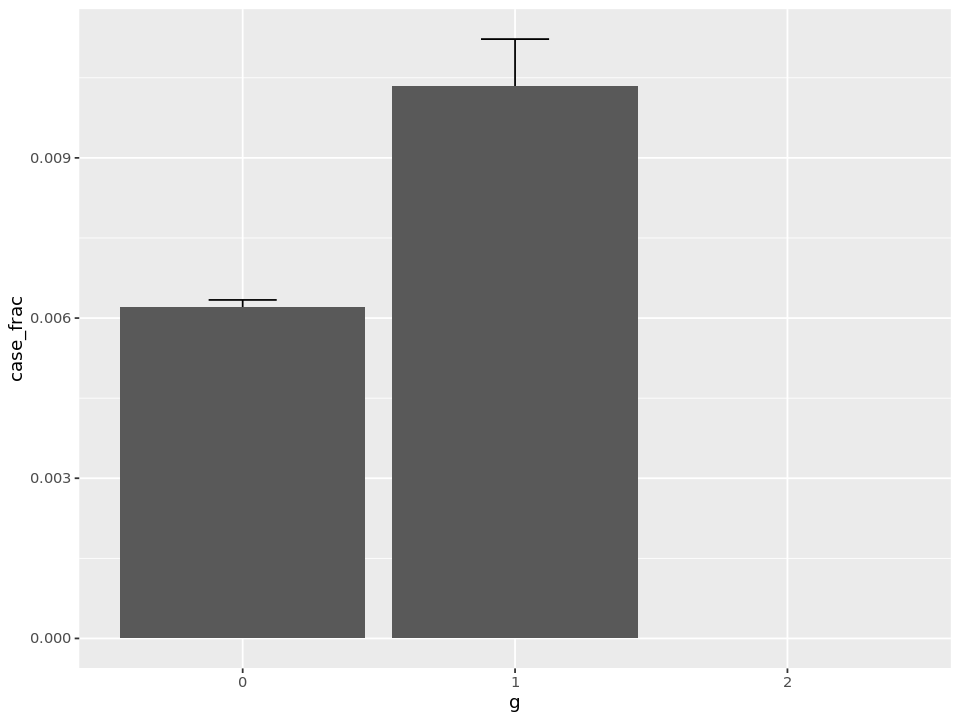

term        estimate    std.error  statistic   p.value      OR_estimate
1 (Intercept) -6.14471201 0.15390680 -39.9248904 0.000000e+00 0.002144793
2 g            0.47026326 0.09001282   5.2244030 1.747179e-07 1.600415467
3 e            0.32024089 0.04230421   7.5699540 3.733565e-14 1.377459543
4 age          0.01840939 0.00263410   6.9888724 2.771043e-12 1.018579886
5 PC1         -3.39303399 1.32171210  -2.5671506 1.025381e-02 0.033606560
6 PC2          0.35413269 1.52917560   0.2315841 8.168611e-01 1.424944248
7 PC3         -1.70047616 1.96929683  -0.8634941 3.878659e-01 0.182596558
8 g:e          0.20848385 0.17692802   1.1783541 2.386555e-01 1.231809032

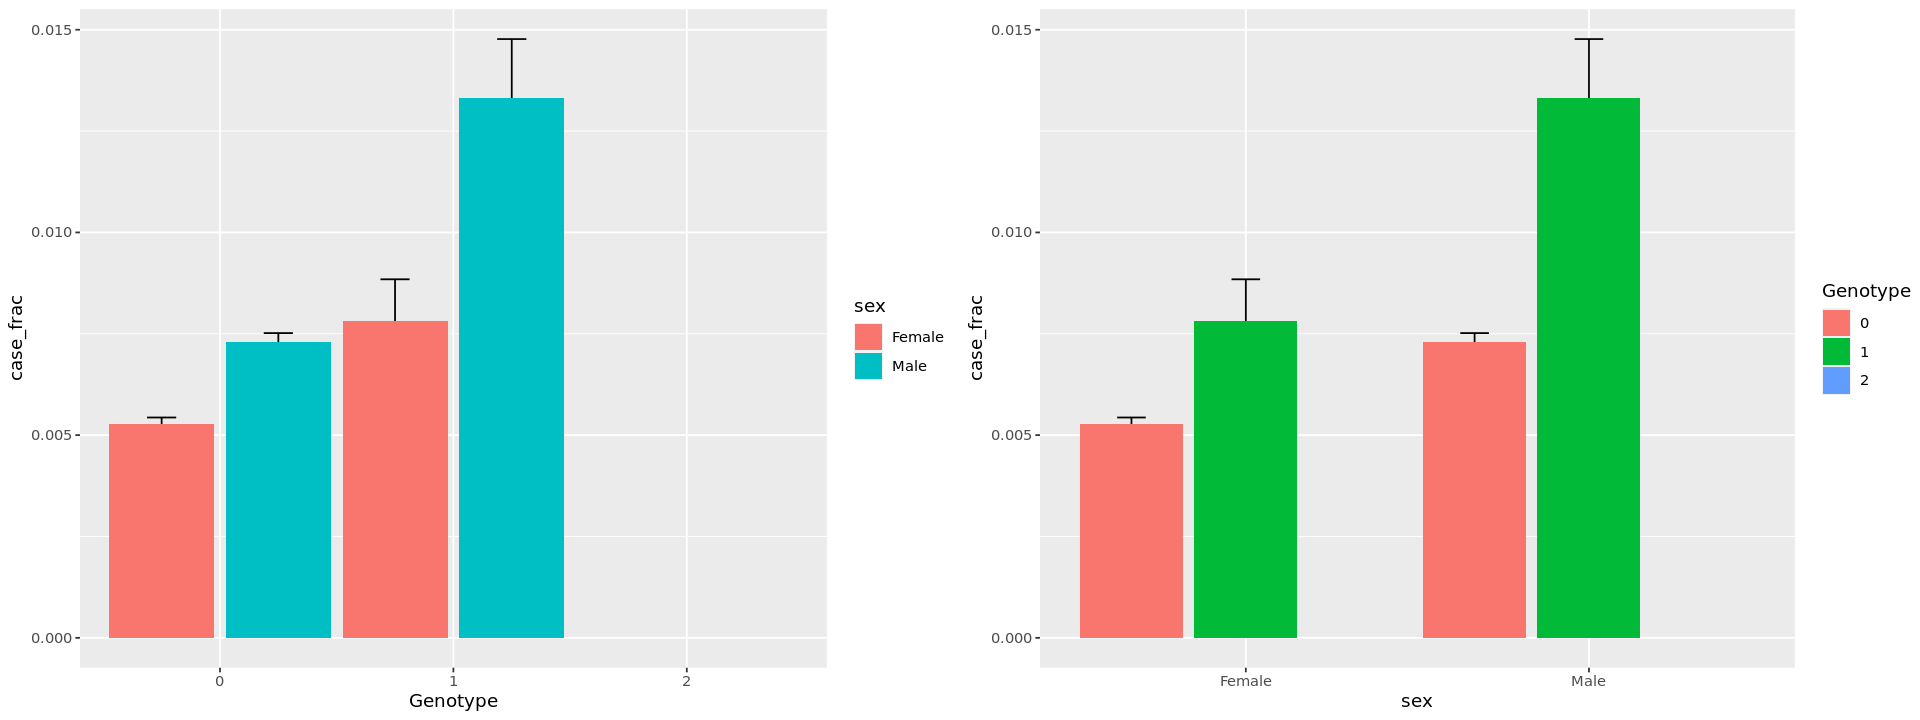

In [42]:
make_main_effect_plot("rs2268616", plot_df)
make_strat_plot("rs2268616", "sex", plot_df)
run_int_regression("rs2268616", "sexMale", followup_df)

### 2:218260234_AC_A

From joint test for sex

In [43]:
paste0("MAF = ", round(sum(followup_df[["2:218260234_AC_A"]]) / (2 * nrow(followup_df)), 3))

[1] "MAF = 0.026"

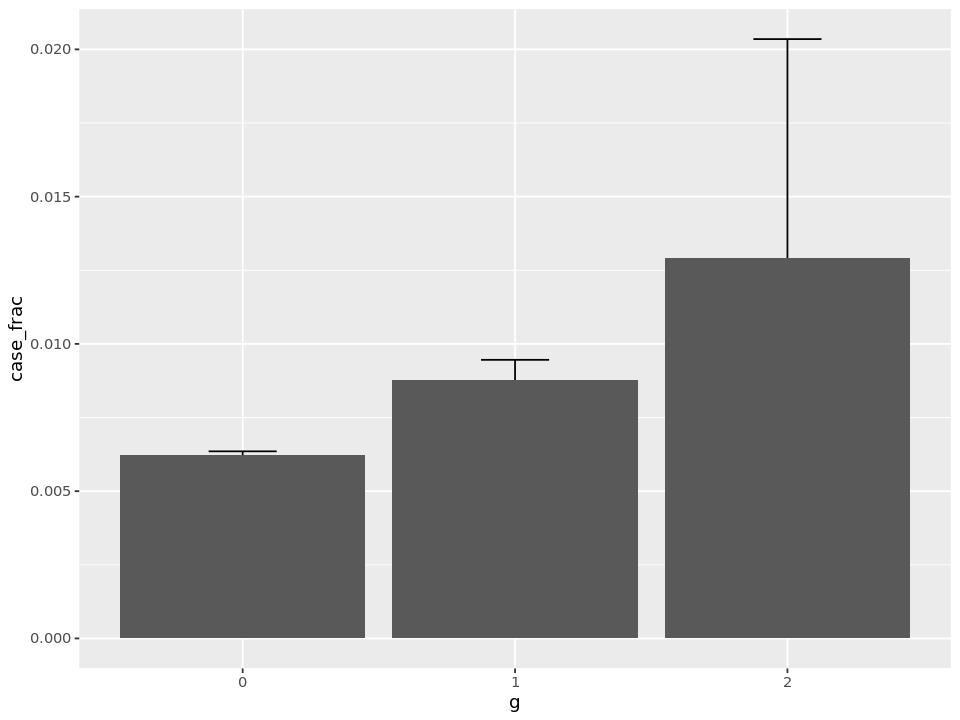

term        estimate    std.error  statistic   p.value      OR_estimate
1 (Intercept) -6.14264167 0.15393197 -39.9049108 0.000000e+00 0.002149239
2 g            0.28485153 0.08823607   3.2282891 1.245330e-03 1.329564619
3 e            0.29483107 0.04264299   6.9139399 4.713750e-12 1.342899481
4 age          0.01842349 0.00263398   6.9945424 2.661261e-12 1.018594247
5 PC1         -3.31575781 1.32230221  -2.5075643 1.215665e-02 0.036306525
6 PC2          0.44875594 1.53074872   0.2931611 7.693990e-01 1.566362321
7 PC3         -1.66244968 1.97024740  -0.8437771 3.987940e-01 0.189673770
8 g:e          0.55446291 0.17168724   3.2294940 1.240095e-03 1.741005660

term estimate   std.error statistic p.value   OR_estimate
1 g    0.02635853 0.1391694 0.1893989 0.8497802 1.026709

term estimate  std.error statistic p.value      OR_estimate
1 g    0.5859636 0.1006333 5.822758  5.788434e-09 1.796721

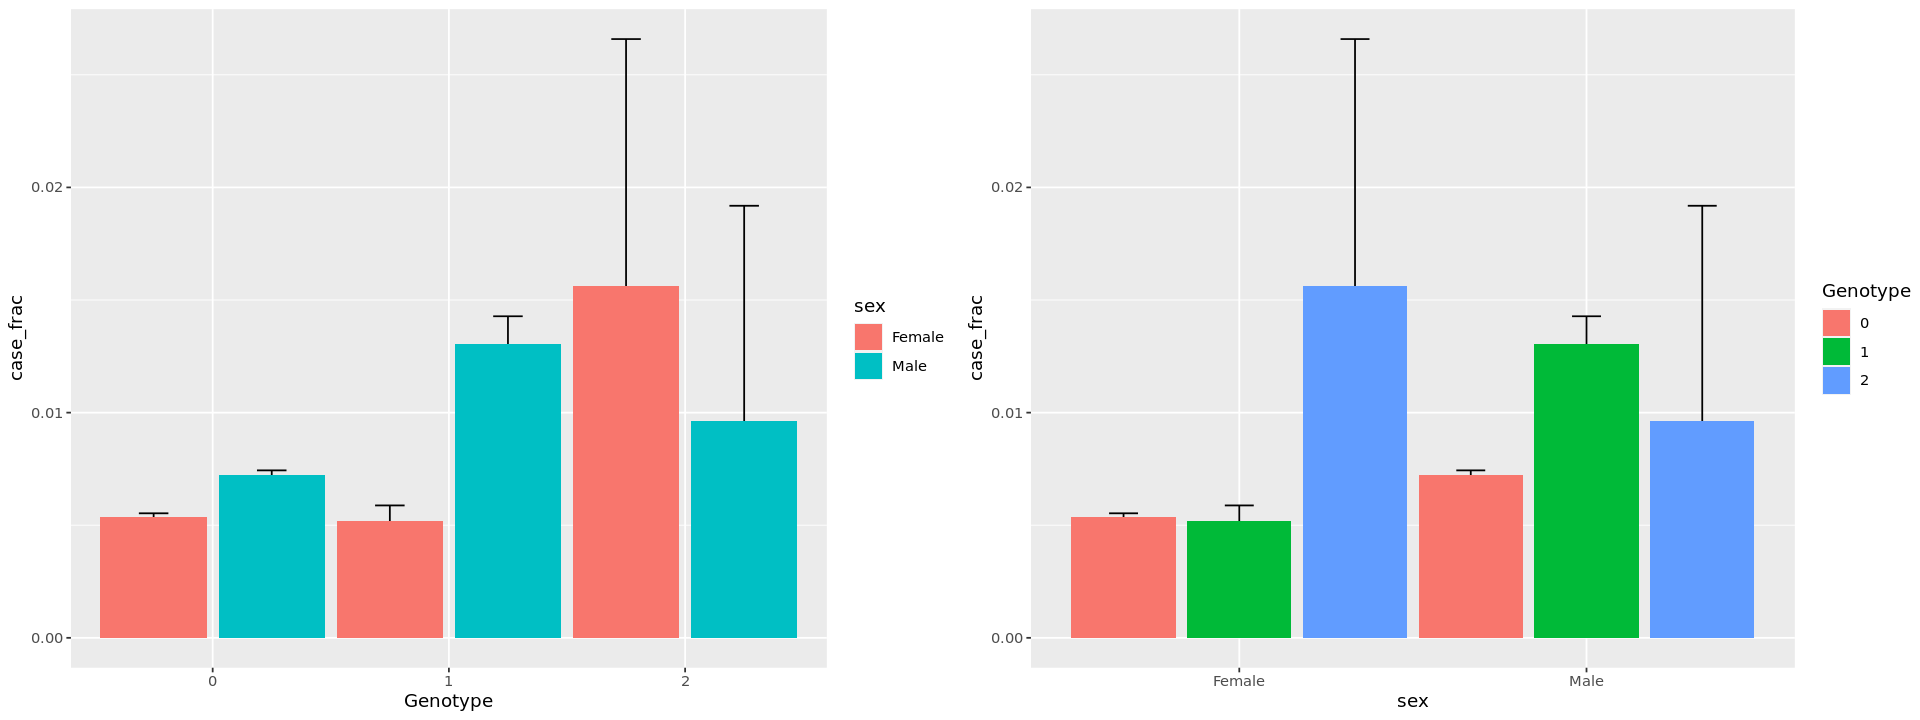

In [44]:
make_main_effect_plot("2:218260234_AC_A", plot_df)
make_strat_plot("2:218260234_AC_A", "sex", plot_df)
run_int_regression("2:218260234_AC_A", "sexMale", followup_df)
run_main_effect_regression("2:218260234_AC_A", filter(followup_df, sexMale == 0))
run_main_effect_regression("2:218260234_AC_A", filter(followup_df, sexMale == 1))

### rs11115199

From cardiometabolic interaction and joint tests 

In [45]:
paste0("MAF = ", round(sum(followup_df[["rs11115199"]]) / (2 * nrow(followup_df)), 3))

[1] "MAF = 0.02"

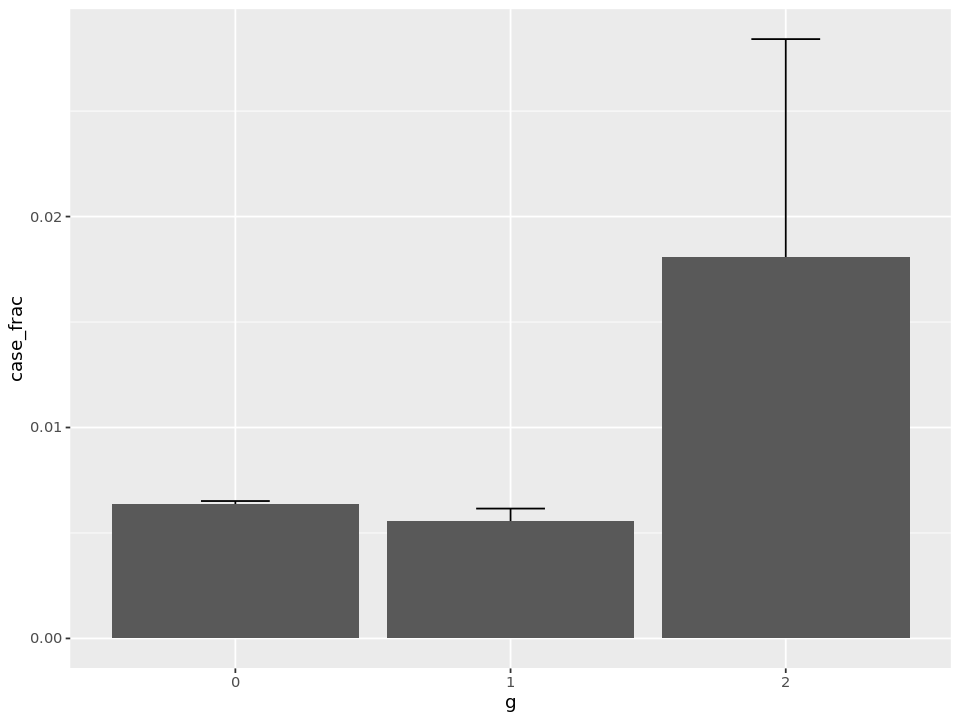

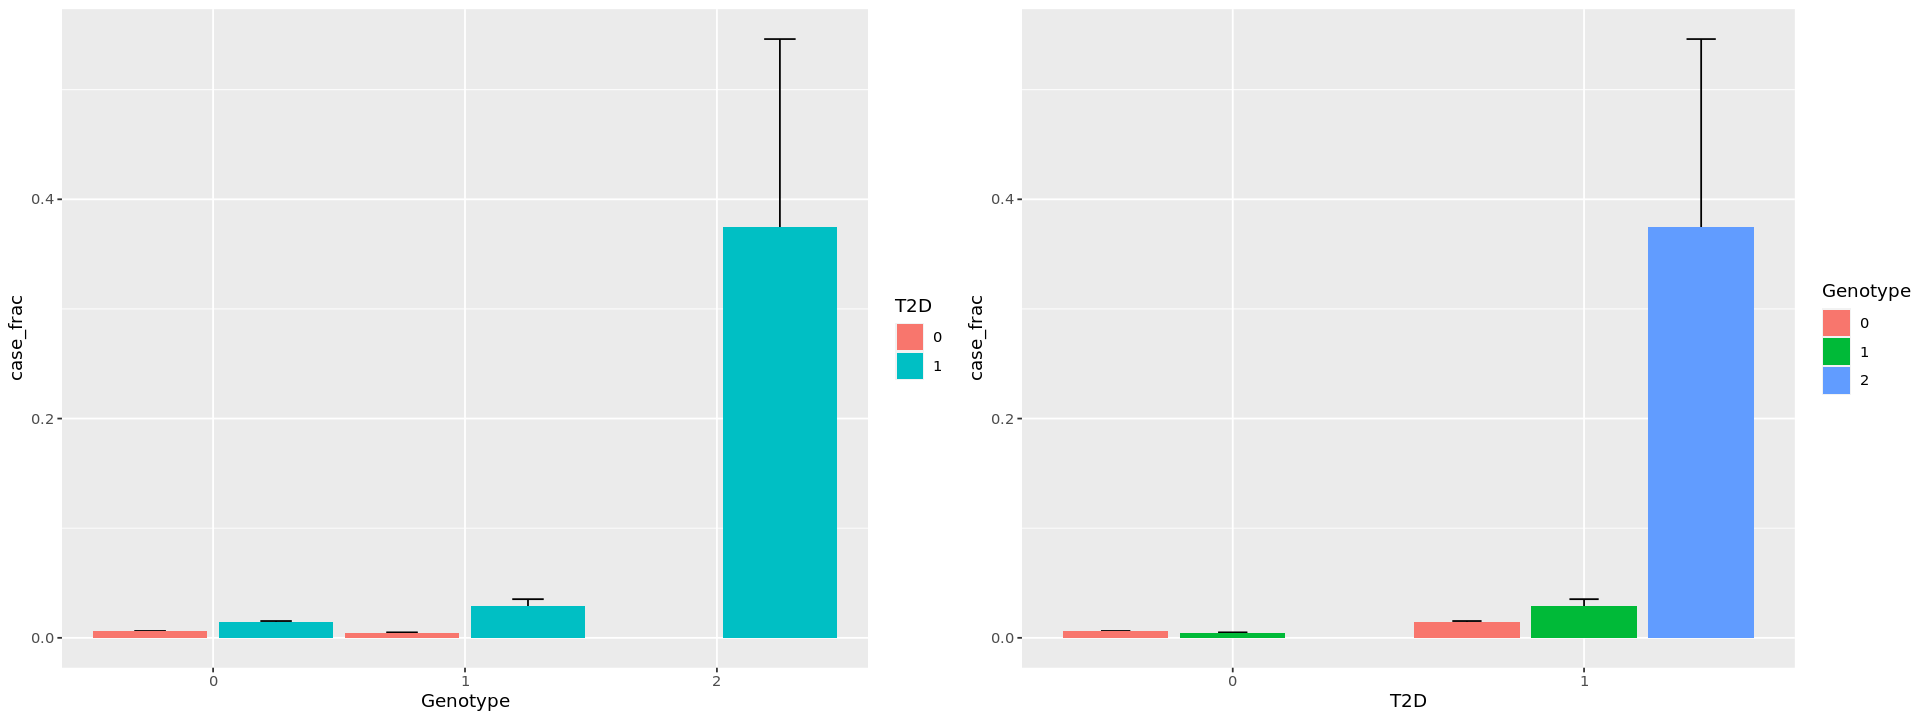

term        estimate    std.error   statistic   p.value      OR_estimate
1 (Intercept) -6.08053712 0.155883404 -39.0069561 0.000000e+00 0.002286948
2 g           -0.27199297 0.121005490  -2.2477738 2.459062e-02 0.761859618
3 e            0.75390240 0.071405406  10.5580578 4.662079e-26 2.125277547
4 sexMale      0.29258929 0.041383572   7.0701796 1.547333e-12 1.339892365
5 age          0.01511668 0.002658256   5.6866897 1.295255e-08 1.015231510
6 PC1         -3.23775370 1.320010253  -2.4528247 1.417394e-02 0.039251968
7 PC2          0.24356257 1.527862038   0.1594140 8.733427e-01 1.275786147
8 PC3         -1.63107614 1.970626827  -0.8276941 4.078438e-01 0.195718840
9 g:e          1.26663297 0.241327130   5.2486141 1.532477e-07 3.548883236

term        estimate    std.error   statistic    p.value      OR_estimate
1 (Intercept) -6.23967310 0.156535182 -39.86115457 0.000000e+00 0.001950493
2 g           -0.05515344 0.110029594  -0.50126009 6.161881e-01 0.946339926
3 e            0.06869867 0.003675159  18.69270616 5.675956e-78 1.071113398
4 sexMale      0.30260046 0.041331821   7.32124679 2.456775e-13 1.353373634
5 age          0.01691541 0.002659053   6.36144087 1.998698e-10 1.017059287
6 PC1         -2.75621849 1.323231379  -2.08294523 3.725622e-02 0.063531560
7 PC2          0.08460399 1.535210606   0.05510904 9.560516e-01 1.088286005
8 PC3         -1.60446686 1.980317961  -0.81020669 4.178214e-01 0.200996686
9 g:e         -0.01954669 0.019616806  -0.99642579 3.190433e-01 0.980643106

term estimate   std.error statistic p.value     OR_estimate
1 g    -0.3288998 0.1262301 -2.605557 0.009172503 0.7197151

term estimate  std.error statistic p.value      OR_estimate
1 g    0.9552167 0.2063001 4.630228  3.652633e-06 2.599234

term estimate   std.error statistic  p.value   OR_estimate
1 g    -0.1621366 0.1819106 -0.8912982 0.3727692 0.850325

term estimate    std.error statistic  p.value   OR_estimate
1 g    -0.03778982 0.131878  -0.2865513 0.7744559 0.9629153

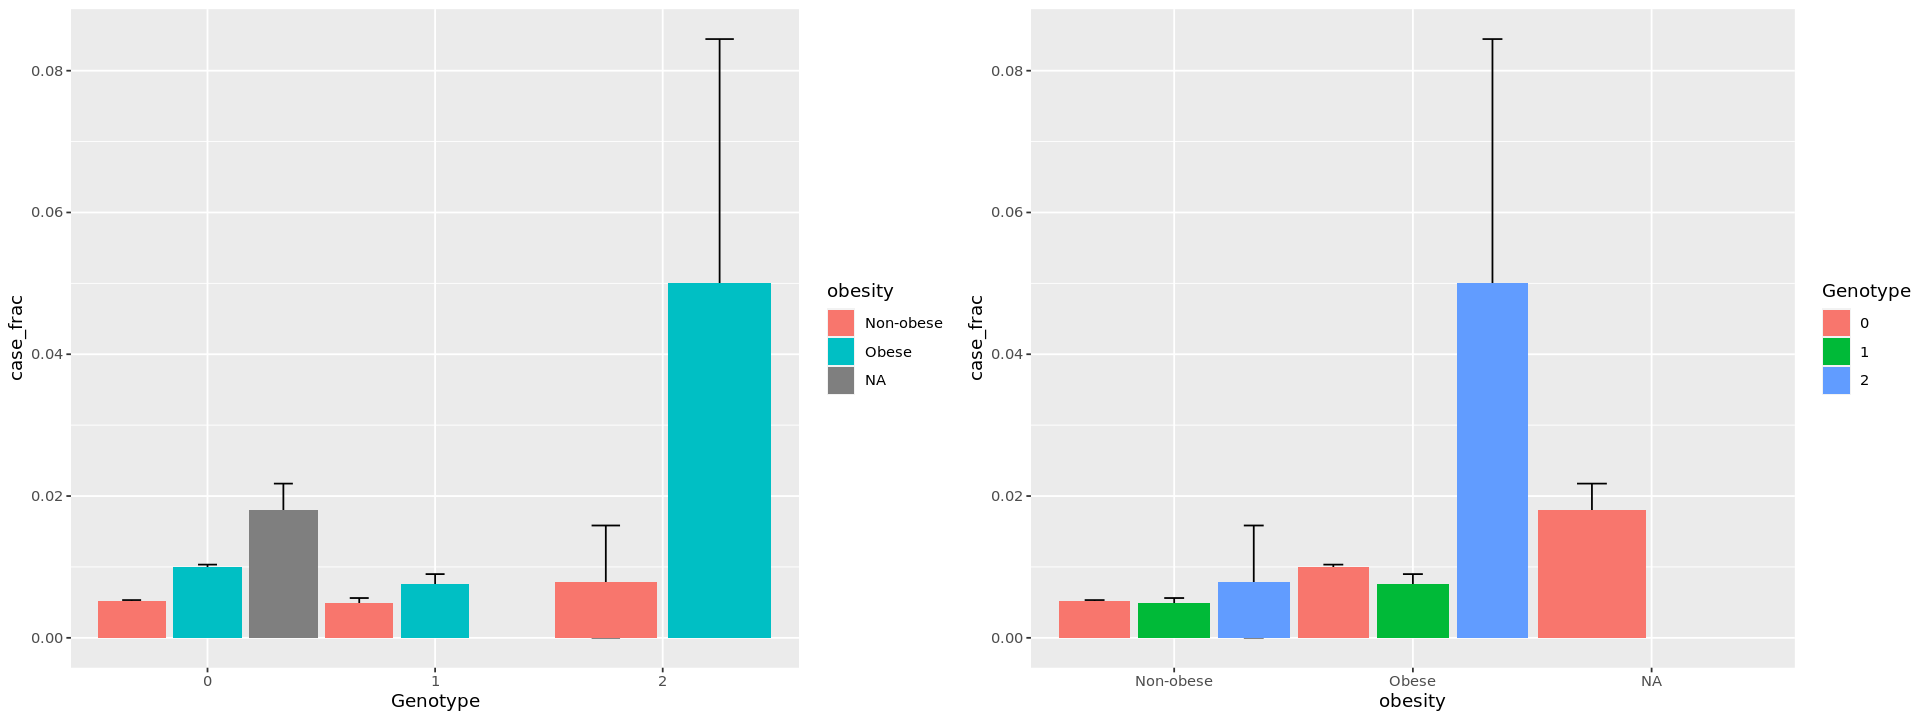

In [46]:
make_main_effect_plot("rs11115199", plot_df)
make_strat_plot("rs11115199", "T2D", plot_df)
make_strat_plot("rs11115199", "obesity", plot_df)
run_int_regression("rs11115199", "t2d", followup_df)
run_int_regression("rs11115199", "bmi", followup_df)
run_main_effect_regression("rs11115199", filter(followup_df, t2d == 0))
run_main_effect_regression("rs11115199", filter(followup_df, t2d == 1))
run_main_effect_regression("rs11115199", filter(followup_df, bmi > 30))
run_main_effect_regression("rs11115199", filter(followup_df, bmi < 30))

### rs148793499

From cardiometabolic joint test

In [47]:
paste0("MAF = ", round(sum(followup_df[["rs148793499"]]) / (2 * nrow(followup_df)), 3))

[1] "MAF = 0.01"

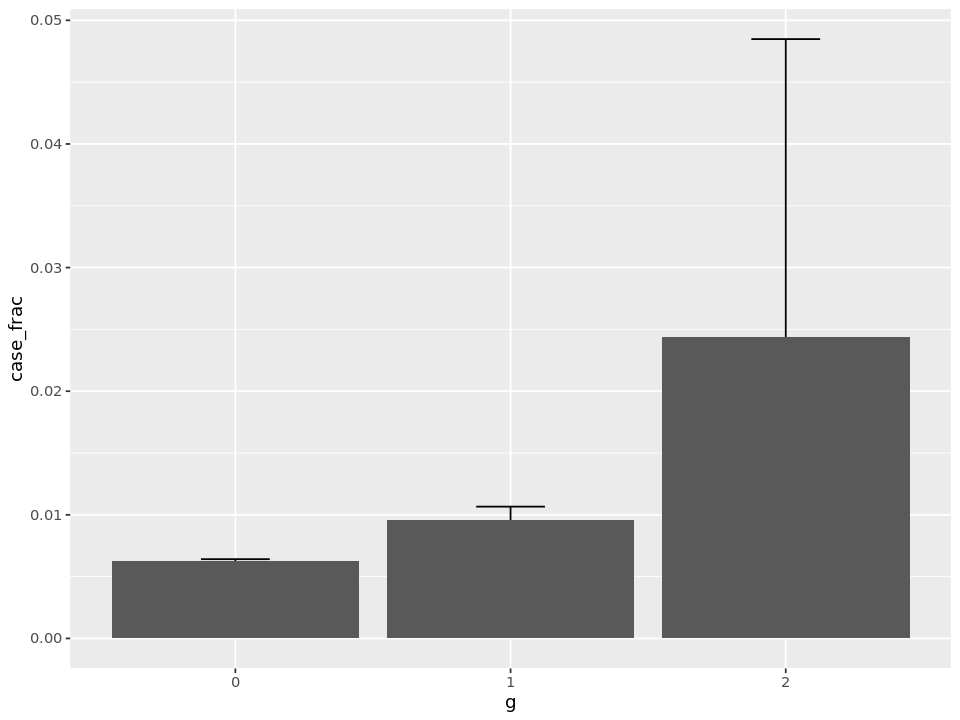

term        estimate    std.error   statistic   p.value      OR_estimate
1 (Intercept) -6.09852922 0.155888252 -39.1211598 0.000000e+00 0.002246169
2 g            0.45405834 0.123535353   3.6755335 2.373528e-04 1.574689855
3 e            0.82010358 0.069514792  11.7975407 4.018854e-32 2.270735039
4 sexMale      0.29246289 0.041384345   7.0669934 1.583264e-12 1.339723020
5 age          0.01508712 0.002658265   5.6755511 1.382428e-08 1.015201504
6 PC1         -3.25937131 1.321173648  -2.4670272 1.362400e-02 0.038412540
7 PC2          0.22310344 1.528975782   0.1459169 8.839870e-01 1.249949861
8 PC3         -1.64191610 1.970607325  -0.8332031 4.047302e-01 0.193608713
9 g:e          0.27208422 0.361664350   0.7523114 4.518638e-01 1.312697547

term        estimate    std.error   statistic    p.value      OR_estimate
1 (Intercept) -6.25561950 0.156578993 -39.95184400 0.000000e+00 0.001919636
2 g            0.29095938 0.139383826   2.08746875 3.684578e-02 1.337710248
3 e            0.06534519 0.003707066  17.62719899 1.523289e-69 1.067527459
4 sexMale      0.30421759 0.041347185   7.35763731 1.871938e-13 1.355563986
5 age          0.01701071 0.002660051   6.39488193 1.606715e-10 1.017156217
6 PC1         -2.75955311 1.323436750  -2.08514166 3.705644e-02 0.063320059
7 PC2          0.07270436 1.535742250   0.04734151 9.622410e-01 1.075412560
8 PC3         -1.62140556 1.980991812  -0.81848171 4.130822e-01 0.197620736
9 g:e          0.06688646 0.017355482   3.85390959 1.162465e-04 1.069174074

term estimate  std.error statistic p.value      OR_estimate
1 g    0.4423633 0.1282831 3.448336  0.0005640527 1.556381

term estimate  std.error statistic p.value    OR_estimate
1 g    0.6996947 0.3382659 2.068475  0.03859535 2.013138

term estimate  std.error statistic p.value     OR_estimate
1 g    0.8575282 0.1657635 5.173204  2.30114e-07 2.357327

term estimate  std.error statistic p.value   OR_estimate
1 g    0.1668161 0.1754082 0.9510168 0.3415958 1.181537

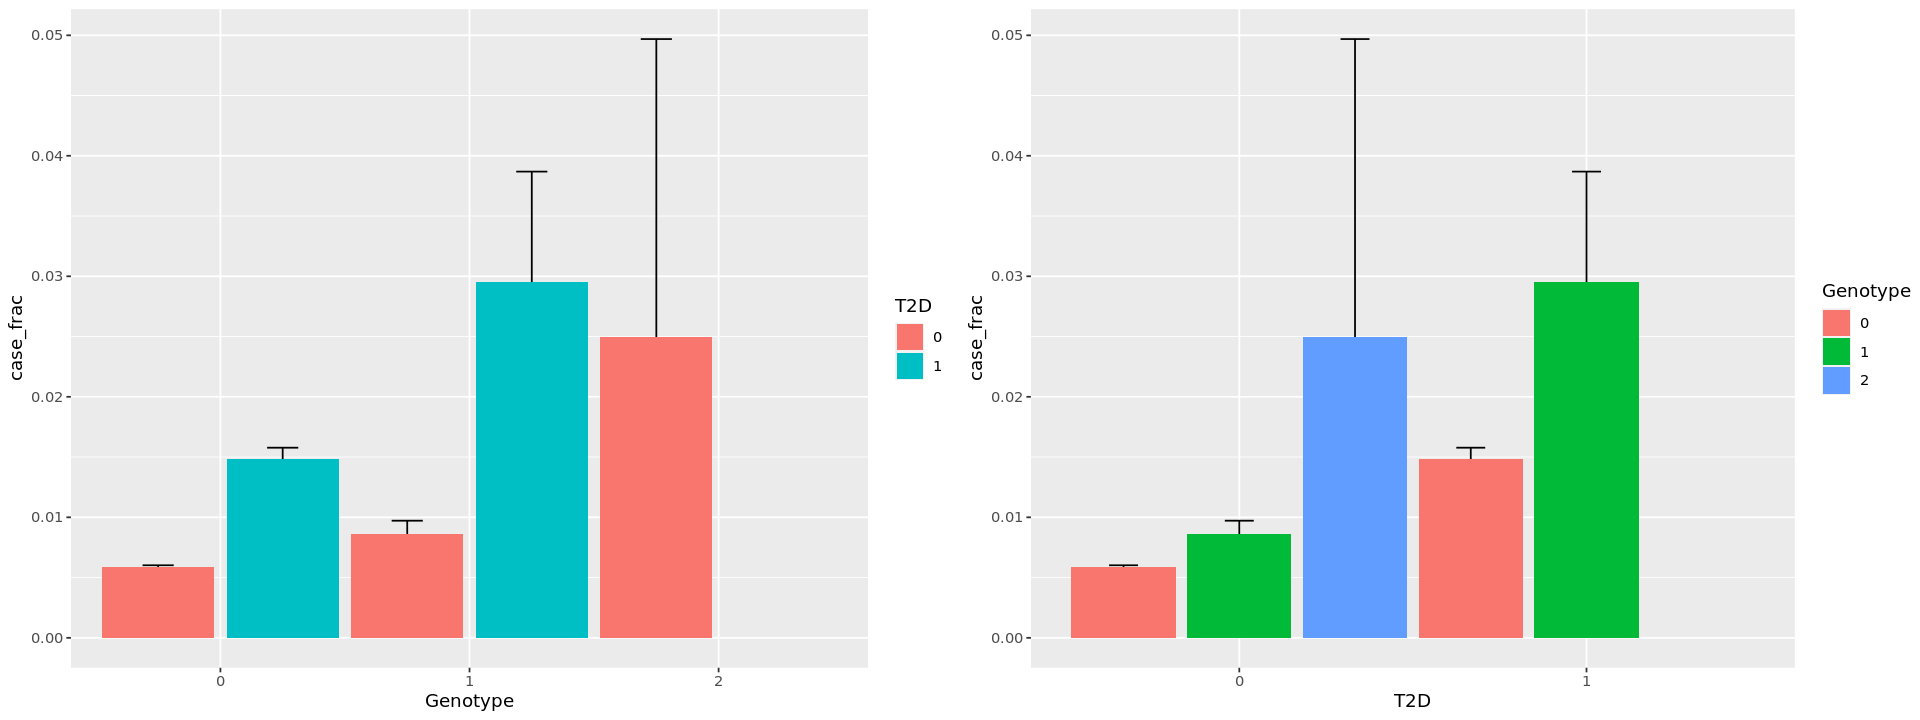

In [48]:
make_main_effect_plot("rs148793499", plot_df)
make_strat_plot("rs148793499", "T2D", plot_df)
run_int_regression("rs148793499", "t2d", followup_df)
run_int_regression("rs148793499", "bmi", followup_df)
run_main_effect_regression("rs148793499", filter(followup_df, t2d == 0))
run_main_effect_regression("rs148793499", filter(followup_df, t2d == 1))
run_main_effect_regression("rs148793499", filter(followup_df, bmi > 30))
run_main_effect_regression("rs148793499", filter(followup_df, bmi < 30))

### rs2268616

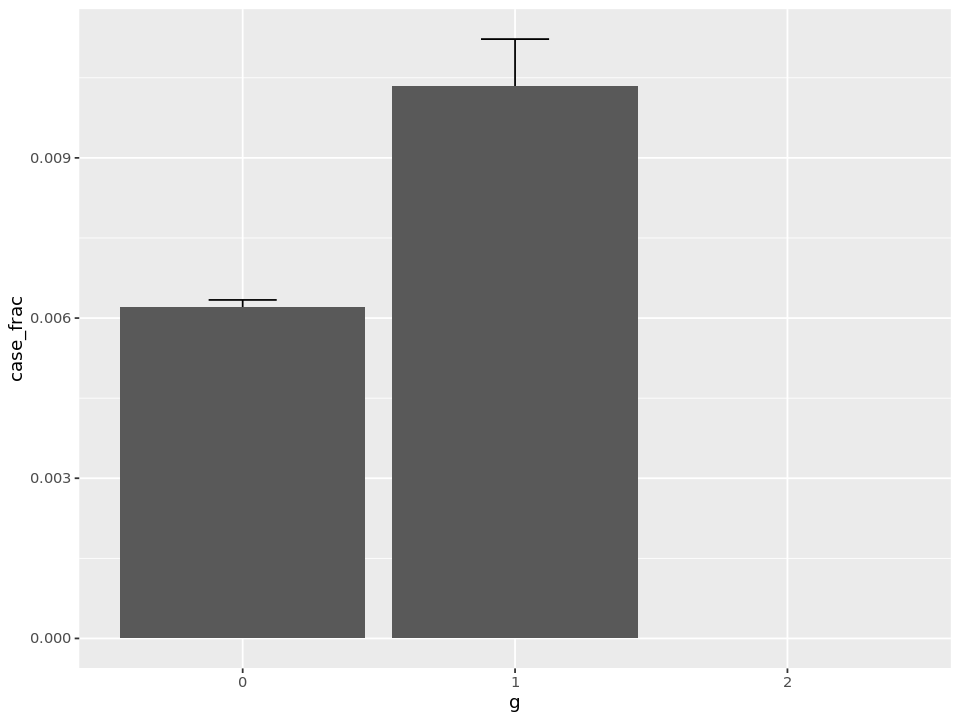

term        estimate    std.error  statistic   p.value      OR_estimate
1 (Intercept) -6.14471201 0.15390680 -39.9248904 0.000000e+00 0.002144793
2 g            0.47026326 0.09001282   5.2244030 1.747179e-07 1.600415467
3 e            0.32024089 0.04230421   7.5699540 3.733565e-14 1.377459543
4 age          0.01840939 0.00263410   6.9888724 2.771043e-12 1.018579886
5 PC1         -3.39303399 1.32171210  -2.5671506 1.025381e-02 0.033606560
6 PC2          0.35413269 1.52917560   0.2315841 8.168611e-01 1.424944248
7 PC3         -1.70047616 1.96929683  -0.8634941 3.878659e-01 0.182596558
8 g:e          0.20848385 0.17692802   1.1783541 2.386555e-01 1.231809032

term estimate  std.error statistic p.value     OR_estimate
1 g    0.3730414 0.1359686 2.743584  0.006077242 1.452144

term estimate  std.error statistic p.value      OR_estimate
1 g    0.5825711 0.1133491 5.139616  2.753008e-07 1.790636

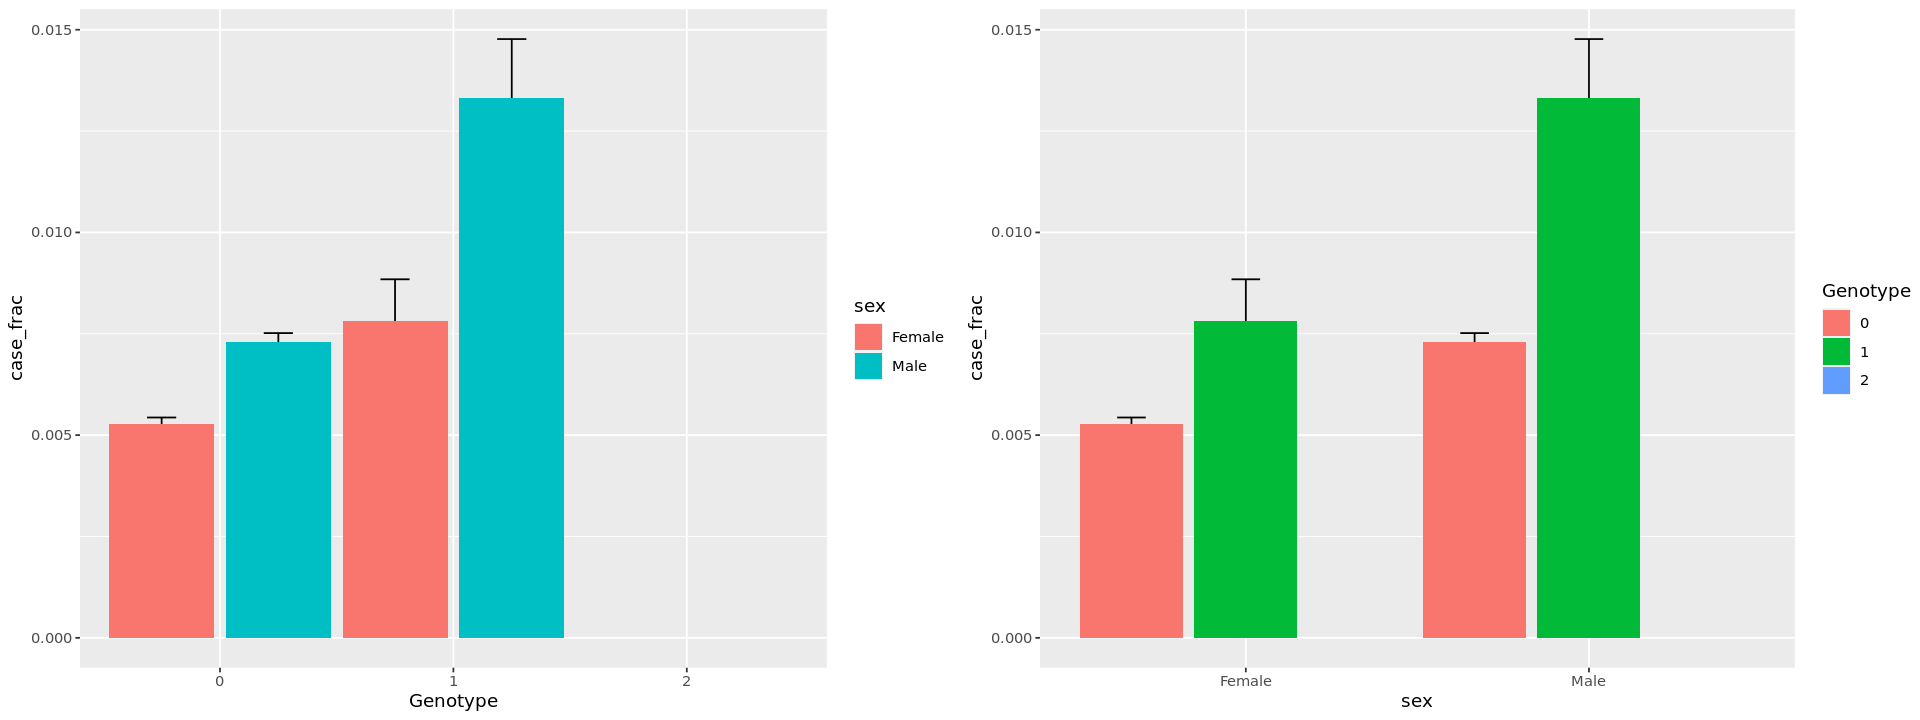

In [49]:
make_main_effect_plot("rs2268616", plot_df)
make_strat_plot("rs2268616", "sex", plot_df)
run_int_regression("rs2268616", "sexMale", followup_df)
run_main_effect_regression("rs2268616", filter(followup_df, sexMale == 0))
run_main_effect_regression("rs2268616", filter(followup_df, sexMale == 1))

###  rs12461506

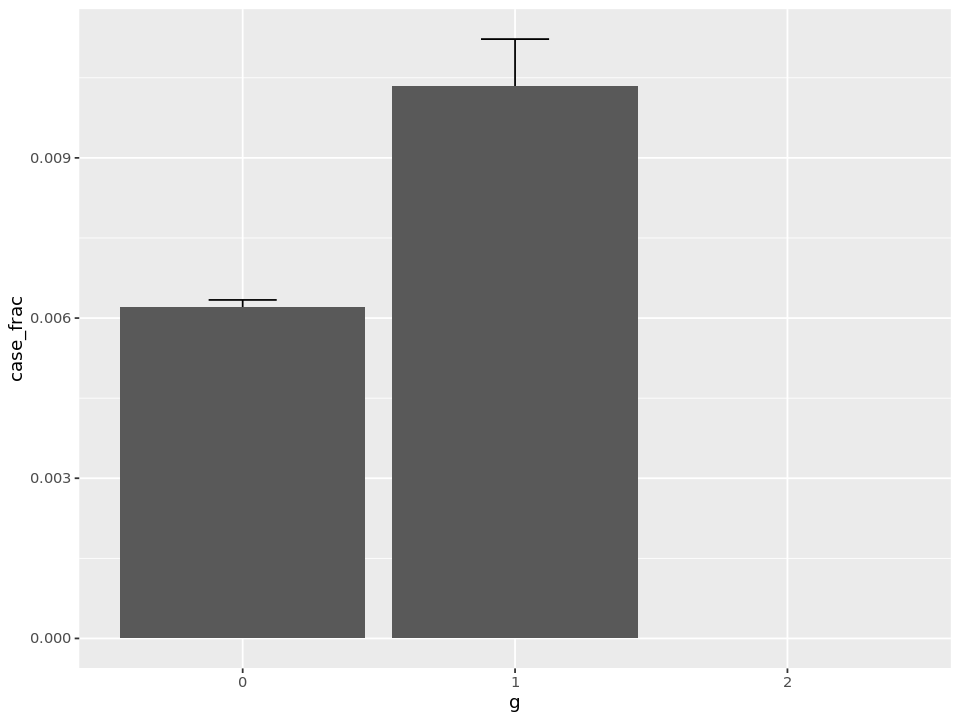

term        estimate    std.error   statistic   p.value      OR_estimate
1 (Intercept) -6.10388180 0.158685068 -38.4653823 0.000000e+00 0.002234178
2 g           -0.02008460 0.030587462  -0.6566284 5.114199e-01 0.980115754
3 e           -0.04952406 0.087942166  -0.5631436 5.733371e-01 0.951682256
4 age          0.01843488 0.002634243   6.9981710 2.593254e-12 1.018605853
5 PC1         -3.27548623 1.322162489  -2.4773704 1.323545e-02 0.037798486
6 PC2          0.31150580 1.530617114   0.2035165 8.387314e-01 1.365479702
7 PC3         -1.65492529 1.970094355  -0.8400234 4.008953e-01 0.191106333
8 g:e          0.29745766 0.060703935   4.9001380 9.576938e-07 1.346431364

term estimate  std.error  statistic p.value      OR_estimate
1 g    -0.157689 0.04395687 -3.587357 0.0003340463 0.8541154

term estimate  std.error  statistic p.value      OR_estimate
1 g    0.1416258 0.04195269 3.375845  0.0007358939 1.152145

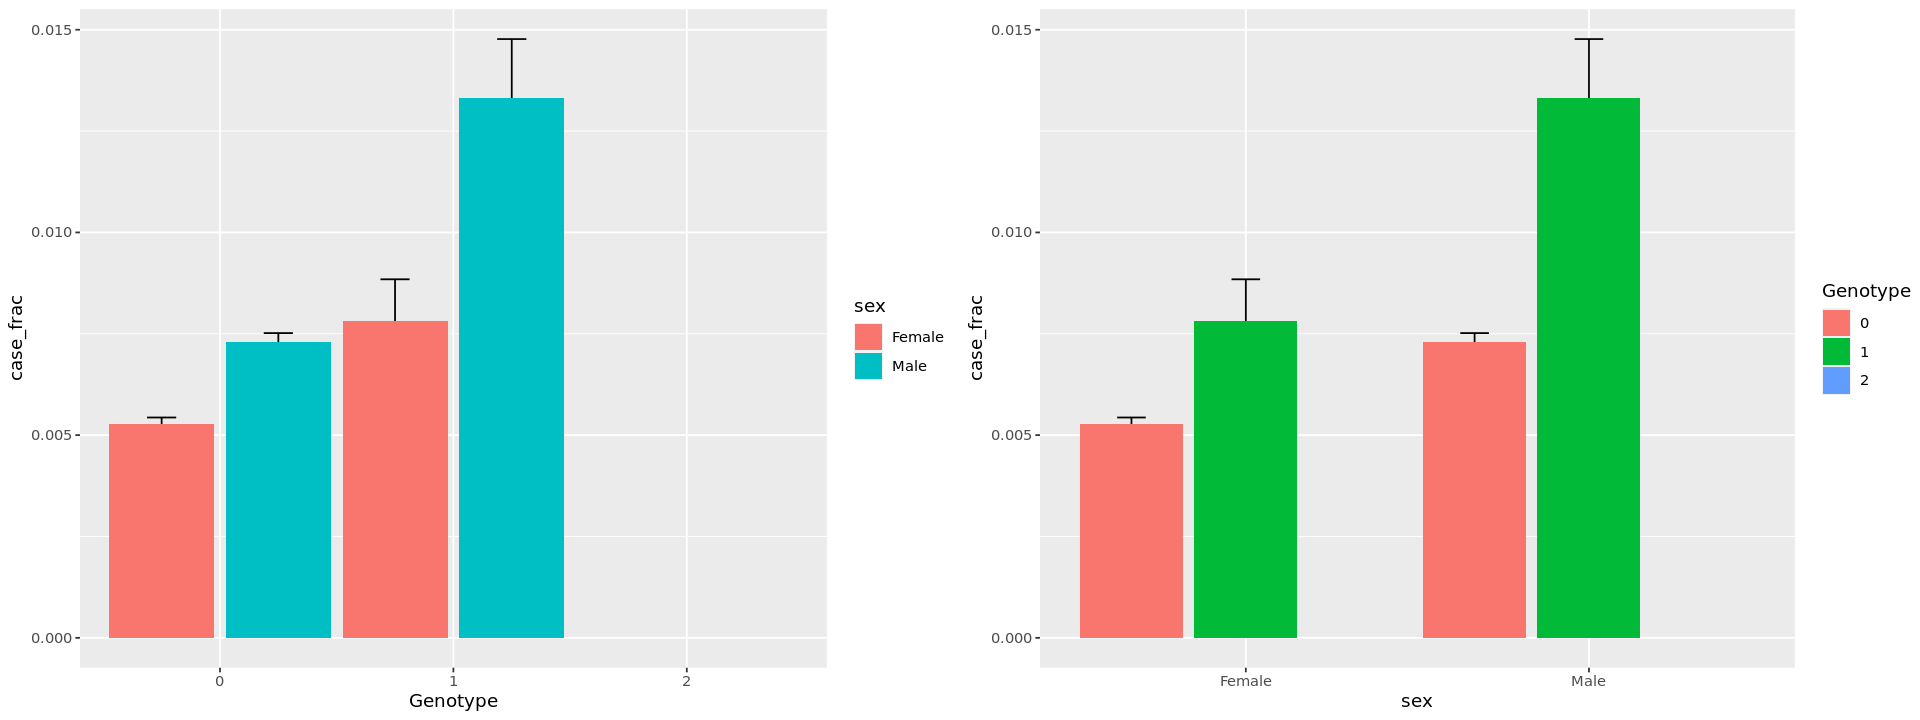

In [50]:
make_main_effect_plot("rs2268616", plot_df)
make_strat_plot("rs2268616", "sex", plot_df)
run_int_regression("rs12461506", "sexMale", followup_df)
run_main_effect_regression("rs12461506", filter(followup_df, sexMale == 0))
run_main_effect_regression("rs12461506", filter(followup_df, sexMale == 1))

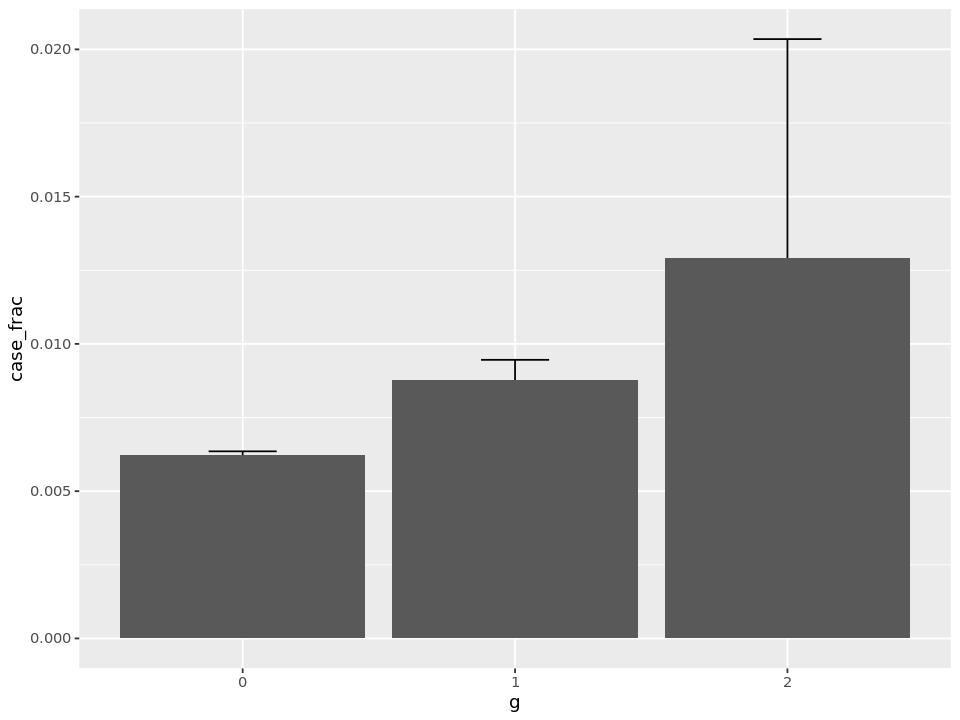

term        estimate    std.error  statistic   p.value      OR_estimate
1 (Intercept) -6.14264167 0.15393197 -39.9049108 0.000000e+00 0.002149239
2 g            0.28485153 0.08823607   3.2282891 1.245330e-03 1.329564619
3 e            0.29483107 0.04264299   6.9139399 4.713750e-12 1.342899481
4 age          0.01842349 0.00263398   6.9945424 2.661261e-12 1.018594247
5 PC1         -3.31575781 1.32230221  -2.5075643 1.215665e-02 0.036306525
6 PC2          0.44875594 1.53074872   0.2931611 7.693990e-01 1.566362321
7 PC3         -1.66244968 1.97024740  -0.8437771 3.987940e-01 0.189673770
8 g:e          0.55446291 0.17168724   3.2294940 1.240095e-03 1.741005660

term estimate   std.error statistic p.value   OR_estimate
1 g    0.02635853 0.1391694 0.1893989 0.8497802 1.026709

term estimate  std.error statistic p.value      OR_estimate
1 g    0.5859636 0.1006333 5.822758  5.788434e-09 1.796721

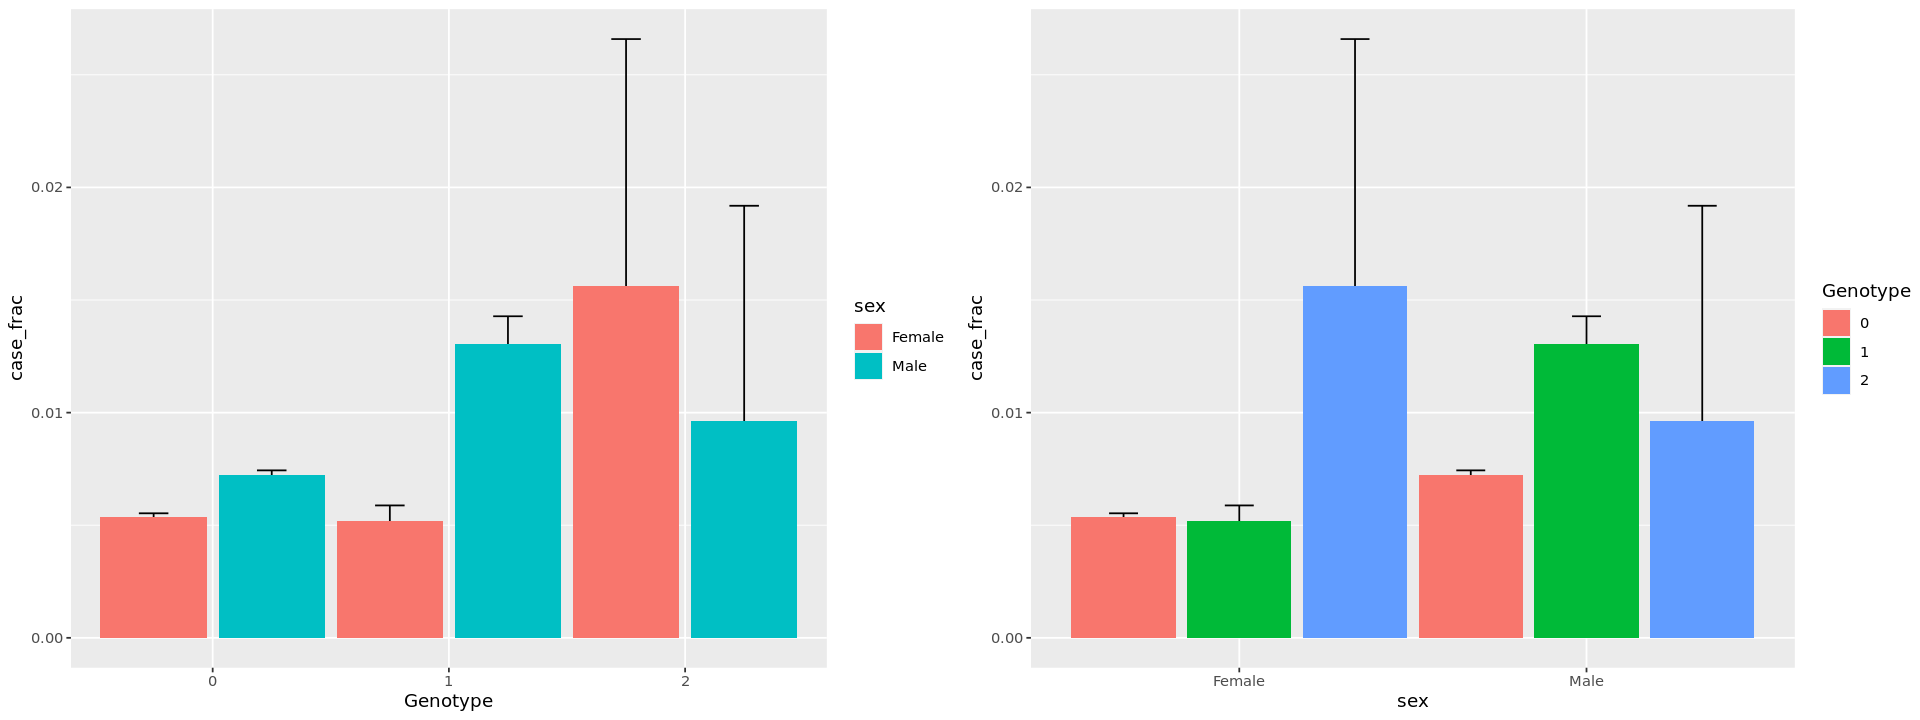

In [51]:
make_main_effect_plot("2:218260234_AC_A", plot_df)
make_strat_plot("2:218260234_AC_A", "sex", plot_df)
run_int_regression("2:218260234_AC_A", "sexMale", followup_df)
run_main_effect_regression("2:218260234_AC_A", filter(followup_df, sexMale == 0))
run_main_effect_regression("2:218260234_AC_A", filter(followup_df, sexMale == 1))

## Colocalization

In [52]:
if (!require(snpStats)) BiocManager::install("snpStats")
if (!require(coloc)) BiocManager::install("coloc")

Loading required package: snpStats

Loading required package: survival

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: coloc



In [53]:
# system("wget https://molgenis26.gcc.rug.nl/downloads/eqtlgen/cis-eqtl/2019-12-11-cis-eQTLsFDR-ProbeLevel-CohortInfoRemoved-BonferroniAdded.txt.gz")
# system("gunzip 2019-12-11-cis-eQTLsFDR-ProbeLevel-CohortInfoRemoved-BonferroniAdded.txt.gz")
# eif2b2_eqtl_df <- data.table::fread(
#     "grep ENSG00000119630 2019-12-11-cis-eQTLsFDR-ProbeLevel-CohortInfoRemoved-BonferroniAdded.txt", 
#     data.table=FALSE, stringsAsFactors=FALSE
# ) %>%
#     select(SNP=V2, CHR=V3, POS=V4, P=V1, N=V13)
# # Positions here are based on hg19   EIF2B2-ENSG00000119718  MLH3-ENSG00000119684  PGF-ENSG00000119630

In [54]:
# rs2268616_sex_res_region_df <- filter(sex_res, CHR == 14, findInterval(POS, 75022929 + c(-1, 1)*500000) == 1) %>%
#     mutate(MAF = pmin(AF, 1 - AF)) %>%
#     select(CHR, POS, P=P_Value_Joint, N=N_Samples, MAF)

# rs2268616_coloc_df <- inner_join(
#     rs2268616_sex_res_region_df, 
#     eif2b2_eqtl_df, 
#     by="POS", suffix=c("_GWAS", "_eQTL")
# )
# saveRDS(rs2268616_coloc_df, "rs2268616_coloc_df.rds")

In [55]:
rs2268616_coloc_df <- readRDS("rs2268616_coloc_df.rds")

coloc_obj <- coloc.abf(
    dataset1 = list(pvalues = rs2268616_coloc_df$P_GWAS, 
                    N = rs2268616_coloc_df$N_GWAS, 
                    MAF = rs2268616_coloc_df$MAF, 
                    type = "quant"),
    dataset2 = list(pvalues = rs2268616_coloc_df$P_eQTL, 
                    N = rs2268616_coloc_df$N_eQTL, 
                    MAF = rs2268616_coloc_df$MAF, 
                    type = "quant")
)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 7.50e-64  3.20e-62  2.29e-02  9.77e-01  1.06e-04 
[1] "PP abf for shared variant: 0.0106%"


## LocusZoom

In [56]:
# system("mkdir -p locuszoom")

# rs2268616_sex_res_region_df <- filter(sex_res, CHR == 14, findInterval(POS, 75419444 + c(-1, 1)*500000) == 1) %>%
#     mutate(MAF = pmin(AF, 1 - AF)) %>%
#     select(RSID, CHR, POS, P=P_Value_Joint, N=N_Samples, MAF)
# write_tsv(rs2268616_sex_res_region_df, "locuszoom/rs2268616_sex_joint.txt")

# if (!file.exists("COVID19_HGI_B2_ALL_leave_UKBB_23andme_20210107.b37.txt")) {
#     system(paste0("gsutil cp ", ws_bucket, "/hgi/COVID19_HGI_B2_ALL_leave_UKBB_23andme_20210107.b37.txt ."))
# }
# hgi_leaveUKB <- fread("COVID19_HGI_B2_ALL_leave_UKBB_23andme_20210107.b37.txt", 
#                       data.table=FALSE, stringsAsFactors=FALSE) %>%
#     select(CHR="#CHR", POS, SNP, RSID=rsid, P=all_inv_var_meta_p)
# rs2268616_hgi_region_df <- filter(hgi_leaveUKB, CHR == 14, findInterval(POS, 75419444 + c(-1, 1)*500000) == 1)
# write_tsv(rs2268616_hgi_region_df, "locuszoom/rs2268616_hgi.txt")

# print(75419444 + c(-1, 1)*500000)
# rs2268616_hgi_region_df %>%
#     filter(findInterval(POS, 75419444 + c(-1, 1)*100000) == 1) %>%
#     arrange(P) %>%
#     head(1)

In [57]:
# system("cd locuszoom", intern=TRUE)

# lz_sex_joint_script_str <- "
# ../ukb-covid-gxe/opt/locuszoom/bin/locuszoom \
# --metal rs2268616_sex_joint.txt \
# --delim tab \
# --markercol RSID \
# --pvalcol P \
# --refsnp rs2268616 --start 74919444 --end 75919444 \
# --pop EUR --build hg19 --source 1000G_March2012 \
# --prefix rs2268616_sex_joint \
# title='Sex interaction joint test'
# "
# lz_HGI_script_str <- "
# ../ukb-covid-gxe/opt/locuszoom/bin/locuszoom \
# --metal rs2268616_hgi.txt \
# --delim tab \
# --markercol RSID \
# --pvalcol P \
# --refsnp rs2005863 --start 75919444 --end 75919444 \
# --pop EUR --build hg19 --source 1000G_March2012 \
# --prefix rs2268616_hgi \
# title='HGI genetic main effect'
# " 

# system(lz_sex_joint_script_str, intern=TRUE)
# system(lz_HGI_script_str, intern=TRUE)

# system("cd ..", intern=TRUE)

![Test image](./210613_rs2268616/chr14_75169444-75669444.pdf){width=65%}

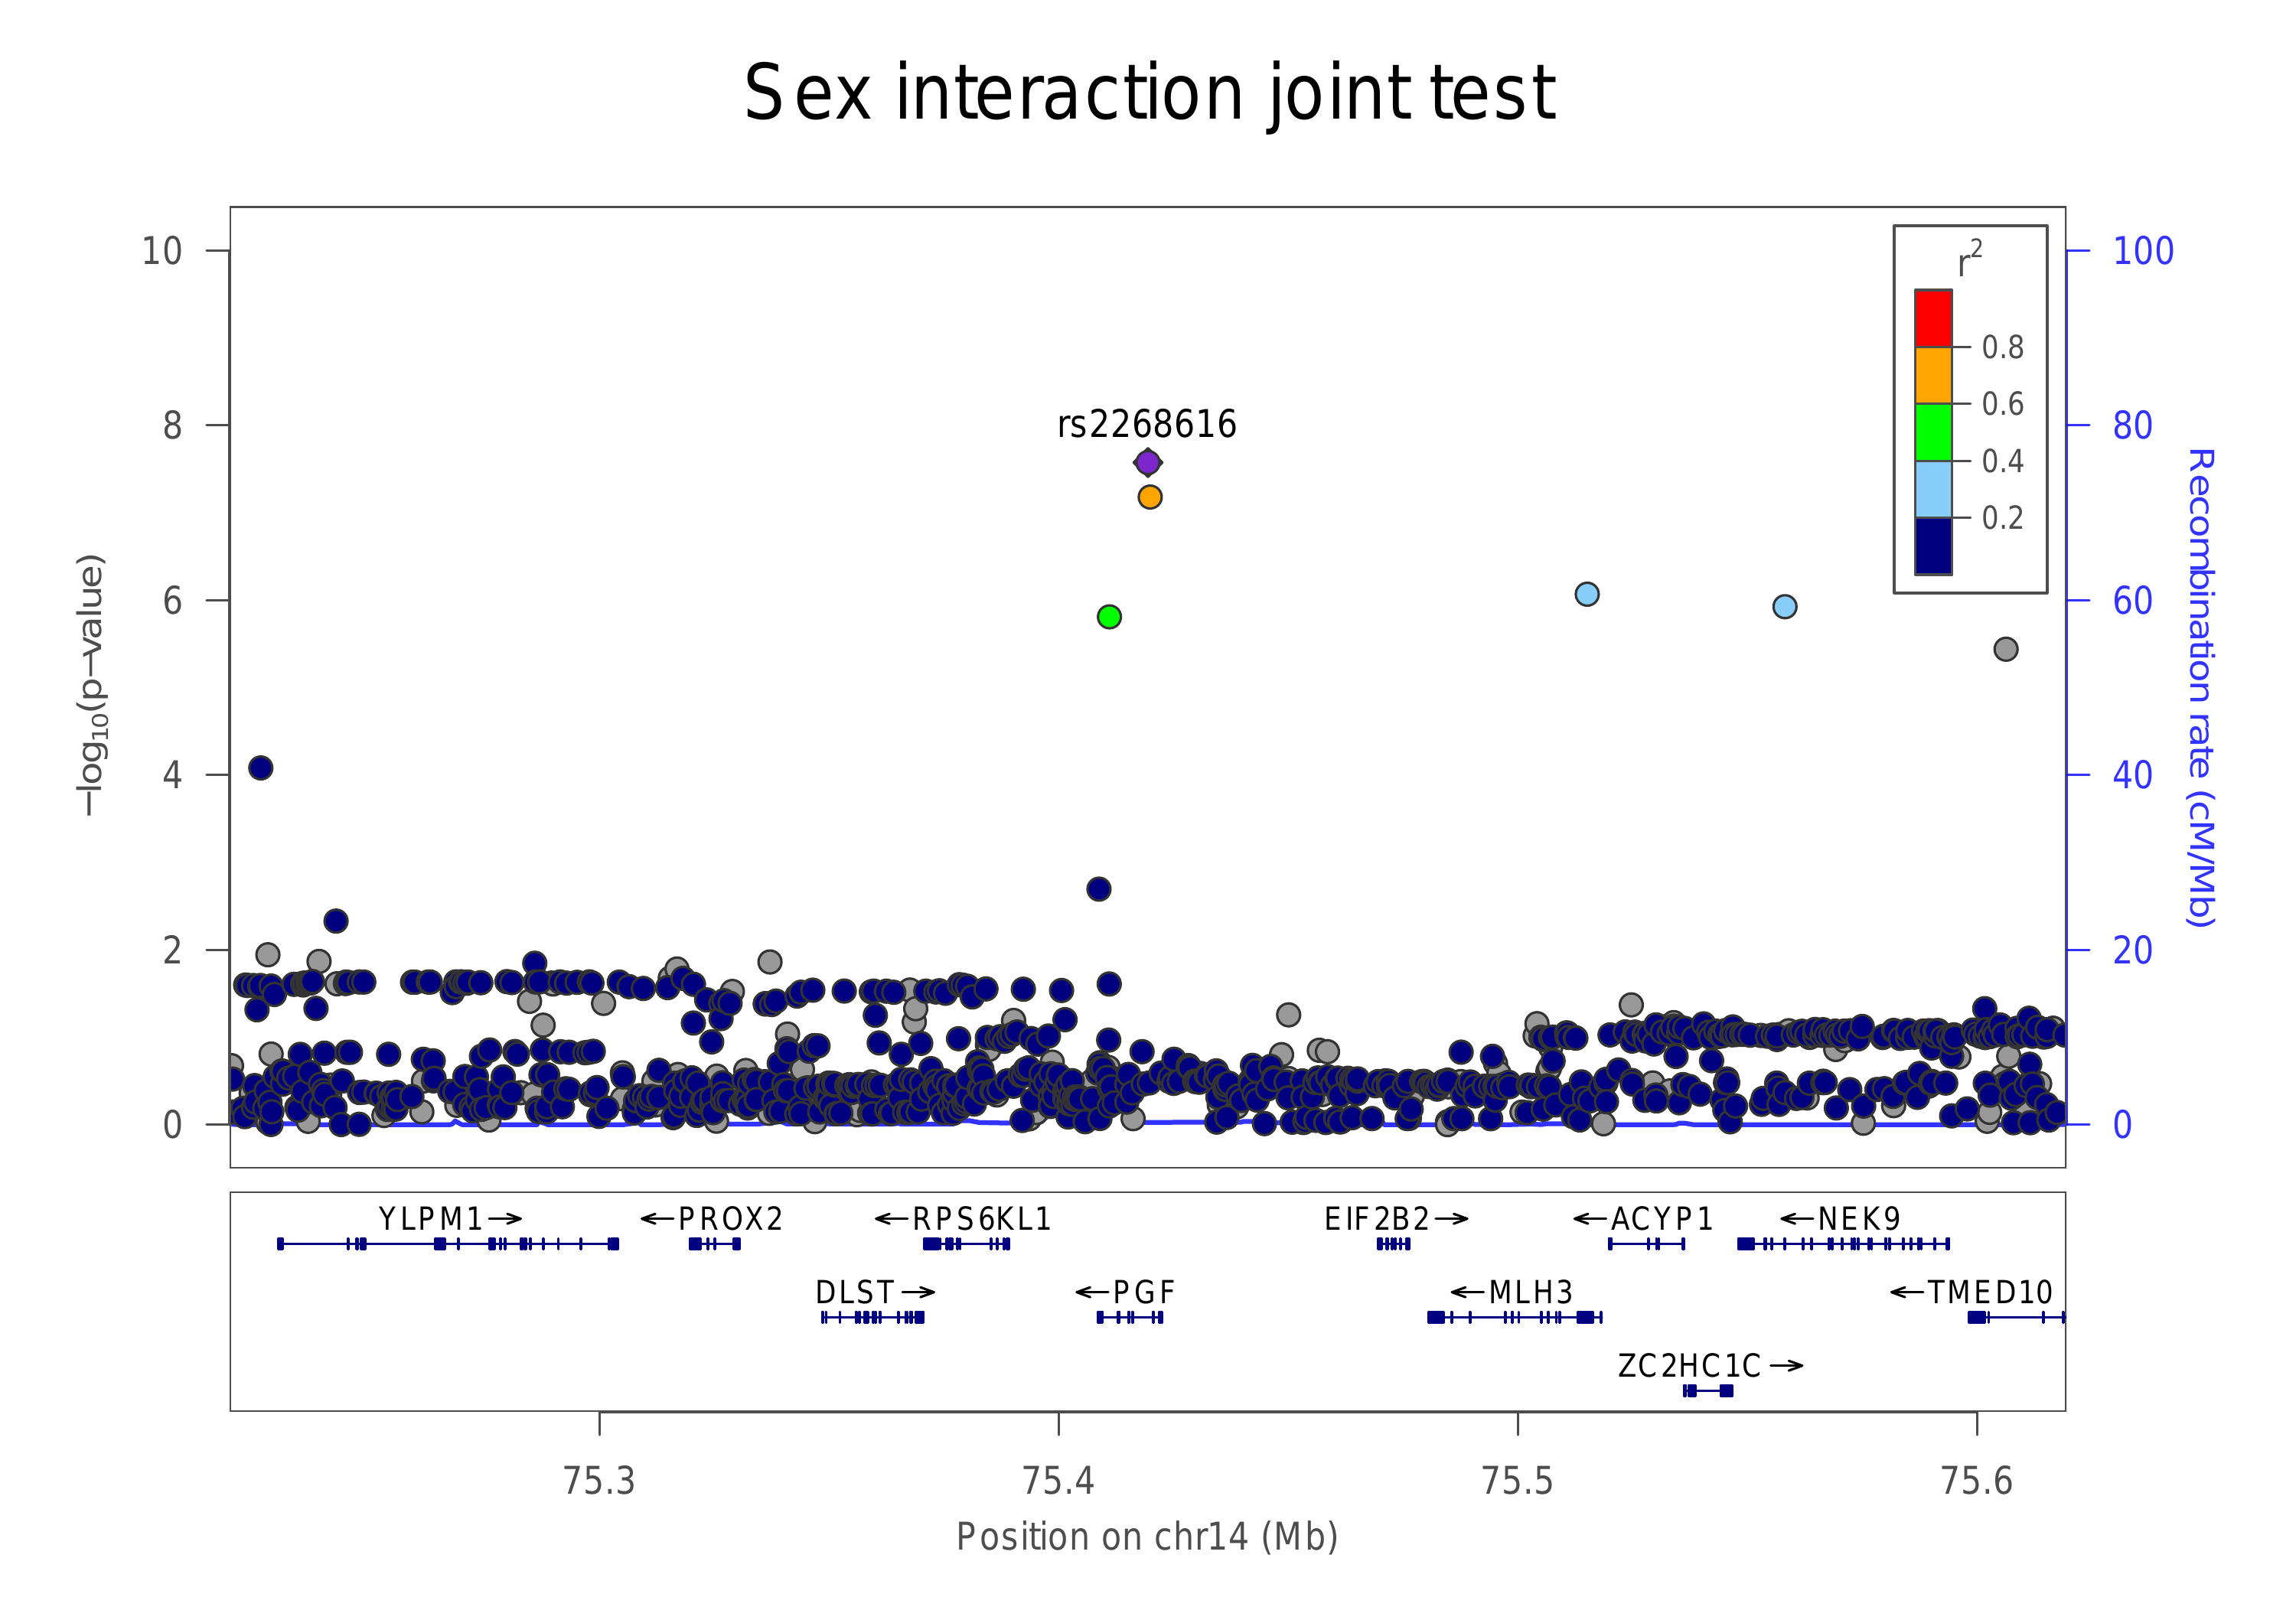

# A tibble: 2 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     3000   2100 sRGB       TRUE         0 300x300
2 PNG     3000   2100 sRGB       TRUE         0 300x300

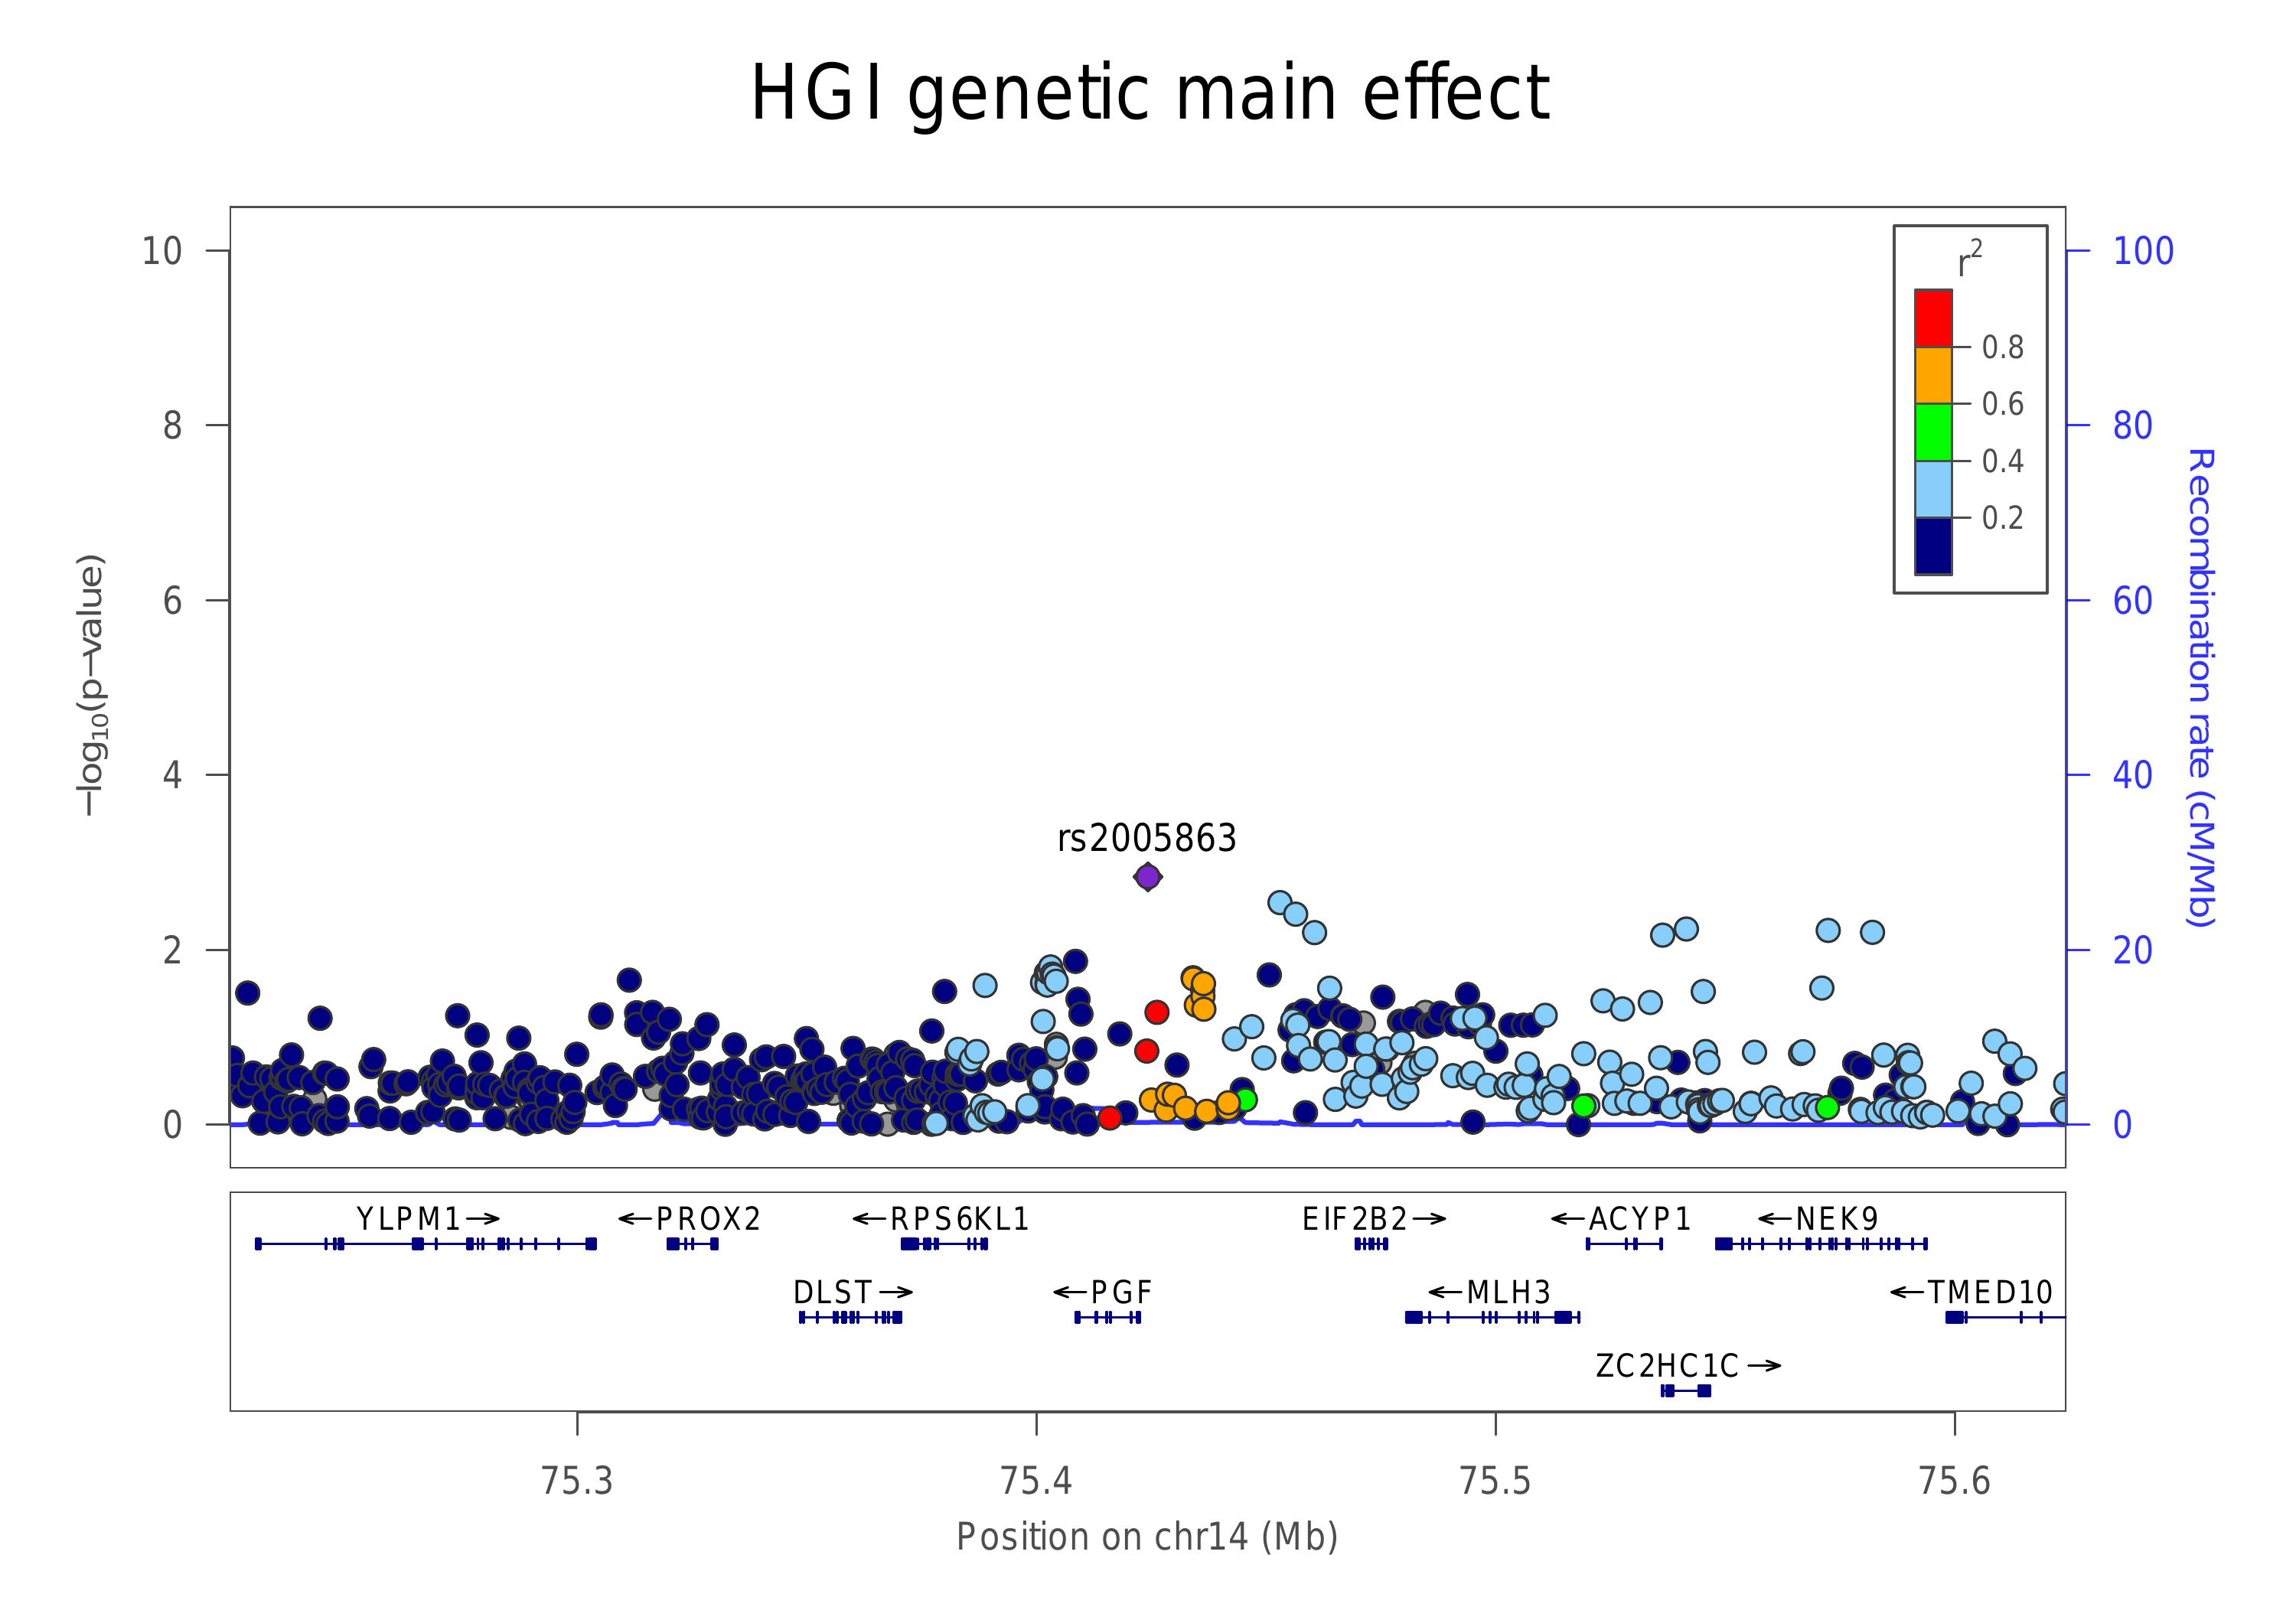

# A tibble: 2 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     3000   2100 sRGB       TRUE         0 300x300
2 PNG     3000   2100 sRGB       TRUE         0 300x300

In [84]:
if (!require(magick)) install.packages("magick")
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 300)
image_read_pdf("locuszoom/rs2268616_sex_joint_210615_rs2268616/chr14_75219444-75619444.pdf")
image_read_pdf("locuszoom/rs2268616_hgi_210615_rs2005863/chr14_75224286-75624286.pdf")

# if (!require(pdftools)) install.packages("pdftools")
# a <- pdf_render_page("210613_rs2268616/chr14_75169444-75669444.pdf")
# a
# # grid::rasterGrob(a)
# # image_flop(a)
# draw_image("210613_rs2268616/chr14_75169444-75669444.pdf")

# Tables and plots for the manuscript

In [85]:
options(repr.plot.res = 300)

## Population characteristics

In [59]:
names(phenos)

[1] "id"          "ancestry"    "PC1"         "PC2"         "PC3"        
 [6] "PC4"         "PC5"         "PC6"         "PC7"         "PC8"        
[11] "PC9"         "PC10"        "array"       "sexMale"     "age"        
[16] "bmi"         "t2d"         "gPC1"        "gPC2"        "gPC3"       
[21] "gPC4"        "gPC5"        "gPC6"        "gPC7"        "gPC8"       
[26] "gPC9"        "gPC10"       "mdi"         "case_b2"     "ancestryEUR"
[31] "ancestryEAS" "ancestrySAS"

In [60]:
summarize_continuous <- function(x) {
    m <- round(mean(x, na.rm=TRUE), 1)
    s <- round(sd(x, na.rm=TRUE), 1)
    paste0(m, " (", s, ")")
}

phenos %>%
    group_by(case_b2) %>%
    summarise(
        N = n(),
        Ancestry = "European",
        Age = summarize_continuous(age),
        BMI = summarize_continuous(bmi),
        T2D = paste0(round(sum(t2d) / n() * 100), "%"),
        Sex = paste0(round(sum(sexMale) / n() * 100), "%"),
        MDI = summarize_continuous(mdi),
    .groups="drop") %>%
    mutate(case_b2 = ifelse(case_b2 == 1, "Case", "Control")) %>%
    rename(Case=case_b2) %>%
    t()

phenos %>%
    filter(!is.na(mdi)) %>%
    group_by(case_b2) %>%
    summarise(N = n(), .groups="drop")

[,1]        [,2]       
Case     Control     Case       
N        375649        2402     
Ancestry European    European   
Age      56.7 (8)    57.9 (8.6) 
BMI      27.4 (4.8)  29.3 (5.4) 
T2D      4%          10%        
Sex      46%         54%        
MDI      16.8 (13.5) 22.1 (16.5)

case_b2 N     
1 0       321544
2 1         2007

In [61]:
# ORs
sex_main_effect_lm <- broom::tidy(glm(case_b2 ~ sexMale, family="binomial", data=phenos))
t2d_main_effect_lm <- broom::tidy(glm(case_b2 ~ t2d, family="binomial", data=phenos))
obesity_main_effect_lm <- broom::tidy(glm(case_b2 ~ (bmi >= 30), family="binomial", data=phenos))
mdi_main_effect_lm <- broom::tidy(glm(case_b2 ~ scale(mdi), family="binomial", data=phenos))

bind_rows(list(
    sex=sex_main_effect_lm,
    t2d=t2d_main_effect_lm,
    obesity=obesity_main_effect_lm,
    mdi=mdi_main_effect_lm
)) %>%
    filter(term != "(Intercept)") %>%
    mutate(OR = exp(estimate),
           OR_l95 = exp(estimate - 1.96 * std.error),
           OR_u95 = exp(estimate + 1.96 * std.error))

# Univariate p-values
age_tt <- broom::tidy(t.test(age ~ case_b2, data=phenos))
sex_cst <- broom::tidy(chisq.test(phenos$case_b2, phenos$sexMale))
t2d_cst <- broom::tidy(chisq.test(phenos$case_b2, phenos$t2d))
bmi_tt <- broom::tidy(t.test(bmi ~ case_b2, data=phenos))
mdi_tt <- broom::tidy(t.test(mdi ~ case_b2, data=phenos))

tibble(
    term = c("age", "sex", "t2d", "bmi", "mdi"),
    p = c(age_tt$p.value, sex_cst$p.value, t2d_cst$p.value, bmi_tt$p.value, mdi_tt$p.value)
)

term          estimate  std.error  statistic p.value      OR       OR_l95  
1 sexMale       0.3408679 0.04110440  8.292736 1.106731e-16 1.406167 1.297323
2 t2d           0.9424941 0.06706045 14.054397 7.239561e-45 2.566374 2.250282
3 bmi >= 30TRUE 0.6543288 0.04246189 15.409789 1.406700e-53 1.923851 1.770219
4 scale(mdi)    0.3095022 0.01789963 17.290981 5.500767e-67 1.362747 1.315766
  OR_u95  
1 1.524143
2 2.926867
3 2.090815
4 1.411405

term p           
1 age  2.280113e-11
2 sex  9.438694e-17
3 t2d  8.240972e-48
4 bmi  6.717225e-62
5 mdi  9.745688e-45

In [62]:
mystats <-function(x, na.omit=TRUE) {
  if(na.omit)
    x <- x[!is.na(x)]
  m <- mean (x)
  n <- length (x)
  s <- sd (x)
  min <- min(x)
  max <- max (x)
  q <- quantile (x, probs=c(0.25, 0.50, 0.75))
  skew <- sum ((x-m)^3/s^3)/n
  kurt <- sum ((x-m)^4/s^4)/n-3
  return(c(n=n, mean=m, stdev=s, min=min, max=max, quantiles=q, kurtosis=kurt, skew=skew))
}


In [63]:
quant_vars <-c('age', 'bmi', 'PC1', 'PC2',  'gPC1' , 'gPC2', 'mdi')  
stats.data <- sapply(phenos[quant_vars], mystats) #Model1 es la base
stats.data <- t(stats.data)
stats.data <- round(stats.data, digits=2)
stats.data

n      mean   stdev min    max   quantiles.25% quantiles.50% quantiles.75%
age  378051  56.73  8.02  39.00 72.00  50.00         58.00         63.00       
bmi  376777  27.37  4.76  12.12 74.68  24.10         26.70         29.83       
PC1  378051   0.00  0.02  -0.06  0.18  -0.01          0.00          0.01       
PC2  378051   0.00  0.01  -0.05  0.13  -0.01          0.00          0.01       
gPC1 378051 -11.80  3.42 -19.27 28.67 -13.41        -12.30        -11.09       
gPC2 378051   3.46  2.23 -26.21 11.75   2.59          3.69          4.73       
mdi  323551  16.88 13.51   0.61 82.00   7.21         12.49         22.40       
     kurtosis skew 
age  -0.97    -0.35
bmi   2.44     1.09
PC1  18.07     2.55
PC2   8.22     1.98
gPC1 30.01     4.51
gPC2 18.44    -2.87
mdi   2.30     1.54

In [64]:
install.packages("gmodels")

Installing package into ‘/home/jupyter-user/notebooks/packages’
(as ‘lib’ is unspecified)



In [65]:
# library(ggplot2)
# library(dplyr)
# library(tidyr)
# library(knitr)
# library(gmodels)

In [66]:
# CrossTable(phenos$sexMale)
# CrossTable(phenos$t2d)
# CrossTable(phenos$mdi_25p)

In [67]:
# top_sex_results <- sex_res %>%
#     mutate(minP = pmin(P_Value_Interaction, P_Value_Joint, na.rm=TRUE)) %>%
#     arrange(minP) %>%
#     head(15)
# # top_sex_variants <- c("rs114807731", "rs2268616")
# top_sex_variants <- top_sex_results$rs11115199

# # Generate stratified effect estimates
# top_sex_strat_results <- map_dfr(top_sex_variants[top_sex_variants %in% names(followup_df)], 
#                                  make_sex_stratified_table)

# # Bind summary stats data frame (which has basic variant info) with stratified table
# top_sex_results %>%
#     mutate(location = paste0(CHR, ":", POS),
#            alleles = paste0(Non_Effect_Allele, "/", Effect_Allele)) %>%
#     select(rs11115199, location, alleles, Eff_Allele_Freq=AF) %>%
#     left_join(top_sex_strat_results, by="rs11115199")

## Top variant tables

### Sex


In [68]:
make_sex_stratified_table <- function(variant) {
    interaction_tbl <- run_int_regression(variant, "sexMale", followup_df) %>%
        filter(term == "g:e")
    combined_tbl <- run_main_effect_regression(variant, followup_df)
    male_tbl <- run_main_effect_regression(variant, filter(followup_df, sexMale == 1))
    female_tbl <- run_main_effect_regression(variant, filter(followup_df, sexMale == 0))
    bind_rows(list(interaction=interaction_tbl, 
                   combined=combined_tbl, 
                   male=male_tbl, 
                   female=female_tbl), .id="type") %>%
        mutate(RSID = variant,
               l95 = estimate - 1.98 * std.error,
               u95 = estimate + 1.98 * std.error,
               OR_string = paste0(round(exp(estimate), 2),
                                  " [",
                                  signif(exp(l95), 2),
                                  "-",
                                  signif(exp(u95), 2),
                                  "]")) %>%
        select(RSID, type, OR_string) %>%
        pivot_wider(names_from="type", values_from="OR_string")
}

In [69]:
# Top sex results by either interaction or joint p-value (whichever is lower)
top_sex_results <- bind_rows(sex_res_int_pruned, sex_res_joint_pruned) %>%
    rename(RSID=index_var) %>%
    distinct(RSID, .keep_all=TRUE) %>%
    mutate(minP = pmin(P_Value_Interaction, P_Value_Joint, na.rm=TRUE)) %>%
    arrange(minP) %>%
    head(15)
# top_sex_variants <- c("rs114807731", "rs2268616")
top_sex_variants <- top_sex_results$RSID

# Generate stratified effect estimates
top_sex_strat_results <- map_dfr(top_sex_variants[top_sex_variants %in% names(followup_df)], 
                                 make_sex_stratified_table)

# Bind summary stats data frame (which has basic variant info) with stratified table
top_sex_results_tbl <- top_sex_results %>%
    mutate(location = paste0(CHR, ":", POS),
           alleles = paste0(Non_Effect_Allele, "/", Effect_Allele)) %>%
    select(RSID, location, alleles, Eff_Allele_Freq=AF) %>%
    left_join(top_sex_strat_results, by="RSID")
write_csv(top_sex_results_tbl, "top_sex_results_tbl.csv")
top_sex_results_tbl

RSID             location    alleles          Eff_Allele_Freq
1  rs2268616        14:75419444 A/G              0.0179341      
2  2:218260234_AC_A 2:218260234 AC/A             0.0256242      
3  rs182113773      7:20239837  C/A              0.0147687      
4  rs117993077      6:93824151  G/T              0.0117114      
5  rs55926550       4:68007466  G/C              0.0124709      
6  rs11232355       11:80540380 A/G              0.0692849      
7  rs117234438      15:52349607 A/G              0.0106815      
8  rs796925608      13:68788267 A/ACTTTGAAAATAAC 0.8977120      
9  rs112561874      1:185427460 G/A              0.0159888      
10 rs12461506       19:30878810 G/C              0.6431580      
11 rs17066139       3:62113696  C/T              0.1149000      
12 rs114103616      21:16998740 A/T              0.0277936      
13 rs182465934      1:22335633  C/A              0.0284307      
14 rs758053125      20:6586718  C/T              0.0495240      
15 rs114807731      3:60122415  G/A              0.0222404      
   interaction      combined         male             female          
1  1.23 [0.87-1.7]  1.64 [1.4-1.9]   1.79 [1.4-2.2]   1.45 [1.1-1.9]  
2  1.74 [1.2-2.4]   1.44 [1.2-1.7]   1.8 [1.5-2.2]    1.03 [0.78-1.4] 
3  0.98 [0.66-1.4]  1.73 [1.4-2.1]   1.71 [1.3-2.2]   1.75 [1.3-2.3]  
4  2.67 [1.6-4.6]   1.47 [1.2-1.9]   2.06 [1.6-2.7]   0.78 [0.49-1.2] 
5  0.59 [0.39-0.91] 1.6 [1.3-2]      1.22 [0.88-1.7]  2.05 [1.6-2.7]  
6  0.58 [0.46-0.72] 1.09 [0.97-1.2]  0.82 [0.69-0.97] 1.42 [1.2-1.6]  
7  1.93 [1.2-3.2]   1.64 [1.3-2.1]   2.09 [1.6-2.8]   1.08 [0.71-1.6] 
8  1.02 [0.83-1.3]  0.76 [0.68-0.84] 0.76 [0.66-0.88] 0.75 [0.64-0.87]
9  0.47 [0.31-0.72] 1.42 [1.1-1.7]   0.94 [0.67-1.3]  2 [1.5-2.6]     
10 1.35 [1.2-1.5]   1 [0.94-1.1]     1.15 [1.1-1.3]   0.85 [0.78-0.93]
11 1.22 [1-1.4]     1.22 [1.1-1.3]   1.33 [1.2-1.5]   1.09 [0.96-1.2] 
12 0.7 [0.5-0.98]   1.47 [1.2-1.7]   1.23 [0.96-1.6]  1.77 [1.4-2.2]  
13 1.93 [1.3-2.8]   1.3 [1.1-1.5]    1.67 [1.4-2.1]   0.87 [0.65-1.2] 
14 0.52 [0.38-0.71] 1.22 [1-1.4]     0.87 [0.69-1.1]  1.68 [1.4-2.1]  
15 1.99 [1.4-2.9]   1.29 [1.1-1.5]   1.68 [1.4-2.1]   0.84 [0.62-1.2]

### Cardiometabolic

In [70]:
make_CM_stratified_table <- function(variant) {
#     interaction_tbl <- run_int_regression(variant, "sexMale", followup_df) %>%
#         filter(term == "g:e")
    combined_tbl <- run_main_effect_regression(variant, followup_df)
    no_t2d_tbl <- run_main_effect_regression(variant, filter(followup_df, t2d == 0))
    t2d_tbl <- run_main_effect_regression(variant, filter(followup_df, t2d == 1))
    no_obesity_tbl <- run_main_effect_regression(variant, filter(followup_df, bmi < 30))
    obesity_tbl <- run_main_effect_regression(variant, filter(followup_df, bmi >= 30))
    bind_rows(list(combined=combined_tbl, 
                   no_t2d=no_t2d_tbl, 
                   t2d=t2d_tbl,
                   no_obesity=no_obesity_tbl,
                   obesity=obesity_tbl), 
              .id="type") %>%
        mutate(RSID = variant,
               l95 = estimate - 1.98 * std.error,
               u95 = estimate + 1.98 * std.error,
               OR_string = paste0(round(exp(estimate), 2),
                                  " [",
                                  signif(exp(l95), 2),
                                  "-",
                                  signif(exp(u95), 2),
                                  "]")) %>%
        select(RSID, type, OR_string) %>%
        pivot_wider(names_from="type", values_from="OR_string")
}

In [71]:
# Top CM results by either interaction or joint p-value (whichever is lower)
top_cm_results <- bind_rows(cm_res_int_pruned, cm_res_joint_pruned) %>%
    rename(RSID=index_var) %>%
    distinct(RSID, .keep_all=TRUE) %>%
    mutate(minP = pmin(P_Value_Interaction, P_Value_Joint, na.rm=TRUE)) %>%
    arrange(minP) %>%
    head(15)
top_CM_variants <- top_cm_results$RSID

# Generate stratified effect estimates
top_CM_strat_results <- map_dfr(top_CM_variants[top_CM_variants %in% names(followup_df)], 
                                make_CM_stratified_table)

# Bind summary stats data frame (which has basic variant info) with stratified table
top_cm_results_tbl <- top_cm_results %>%
    mutate(location = paste0(CHR, ":", POS),
           alleles = paste0(Non_Effect_Allele, "/", Effect_Allele)) %>%
    select(RSID, location, alleles, Eff_Allele_Freq=AF) %>%
    left_join(top_CM_strat_results, by="RSID")
write_csv(top_cm_results_tbl, "top_cm_results_tbl.csv")
top_cm_results_tbl

RSID        location     alleles Eff_Allele_Freq combined        
1  rs148793499 18:58314588  T/C     0.0102753       1.61 [1.3-2]    
2  rs11115199  12:82510665  G/T     0.0204524       0.91 [0.74-1.1] 
3  rs182113773 7:20239837   C/A     0.0147751       1.73 [1.4-2.1]  
4  rs2268616   14:75419444  A/G     0.0179483       1.64 [1.4-1.9]  
5  rs6035512   20:19990781  C/A     0.0247661       1.41 [1.2-1.7]  
6  rs141850011 13:61925813  T/C     0.0103374       1.17 [0.89-1.5] 
7  rs200298252 X:15253473   C/A     0.0163152       1.12 [0.89-1.4] 
8  rs2727176   15:100570438 A/G     0.0102964       1.21 [0.93-1.6] 
9  rs6747163   2:60777763   C/G     0.1786780       1.05 [0.98-1.1] 
10 rs5747202   22:17969179  T/G     0.0374612       1.31 [1.1-1.6]  
11 rs186508084 X:41698489   G/A     0.0136782       1.22 [1-1.5]    
12 rs28864791  13:91502951  T/C     0.3064040       0.89 [0.84-0.95]
13 rs144282550 4:74917179   A/G     0.0117938       1.65 [1.3-2.1]  
14 rs180972330 21:40008094  A/G     0.0100758       1.03 [0.77-1.4] 
15 rs113083888 15:91197671  C/T     0.0484105       1.06 [0.93-1.2] 
   no_t2d           t2d            no_obesity      obesity        
1  1.56 [1.2-2]     2.01 [1-3.9]   1.18 [0.83-1.7] 2.36 [1.7-3.3] 
2  0.72 [0.56-0.92] 2.6 [1.7-3.9]  0.96 [0.74-1.3] 0.85 [0.59-1.2]
3  1.62 [1.3-2]     2.6 [1.6-4.3]  1.63 [1.3-2.1]  1.94 [1.4-2.6] 
4  1.6 [1.3-1.9]    2.01 [1.2-3.3] 1.82 [1.5-2.2]  1.38 [1-1.9]   
5  1.45 [1.2-1.7]   1.15 [0.65-2]  1.21 [0.97-1.5] 1.74 [1.4-2.2] 
6  0.88 [0.64-1.2]  3.67 [2.2-6.1] 0.97 [0.67-1.4] 1.53 [1-2.3]   
7  0.91 [0.69-1.2]  2.45 [1.6-3.6] 1.17 [0.88-1.6] 1.05 [0.72-1.6]
8  0.94 [0.69-1.3]  3.79 [2.3-6.2] 0.97 [0.67-1.4] 1.56 [1.1-2.3] 
9  0.99 [0.91-1.1]  1.72 [1.4-2.1] 1.11 [1-1.2]    0.97 [0.86-1.1]
10 1.15 [0.95-1.4]  2.92 [1.9-4.4] 1.26 [1-1.6]    1.4 [1.1-1.9]  
11 1.03 [0.83-1.3]  2.36 [1.7-3.3] 1.21 [0.96-1.5] 1.23 [0.92-1.6]
12 0.85 [0.79-0.91] 1.32 [1.1-1.6] 0.87 [0.8-0.95] 0.91 [0.82-1]  
13 1.51 [1.2-1.9]   2.97 [1.7-5.1] 1.65 [1.2-2.2]  1.7 [1.2-2.4]  
14 0.79 [0.55-1.1]  3.72 [2.2-6.4] 0.71 [0.45-1.1] 1.64 [1.1-2.4] 
15 1.12 [0.98-1.3]  0.6 [0.35-1]   0.95 [0.79-1.1] 1.27 [1-1.5]

### MDI

In [72]:
make_mdi_stratified_table <- function(variant) {
    interaction_tbl <- run_int_regression(variant, "mdi_binary", 
                                          mutate(followup_df, mdi_binary = mdi > median(mdi, na.rm=TRUE))) %>%
        filter(term == "g:e")
    combined_tbl <- run_main_effect_regression(variant, followup_df)
    low_mdi_tbl <- run_main_effect_regression(variant, filter(followup_df, mdi < median(mdi, na.rm=TRUE)))
    high_mdi_tbl <- run_main_effect_regression(variant, filter(followup_df, mdi >= median(mdi, na.rm=TRUE)))
    bind_rows(list(interaction=interaction_tbl,
                   combined=combined_tbl, 
                   low_sdh=low_mdi_tbl, 
                   high_sdh=high_mdi_tbl), 
              .id="type") %>%
        mutate(RSID = variant,
               l95 = estimate - 1.98 * std.error,
               u95 = estimate + 1.98 * std.error,
               OR_string = paste0(round(exp(estimate), 2),
                                  " [",
                                  signif(exp(l95), 2),
                                  "-",
                                  signif(exp(u95), 2),
                                  "]")) %>%
        select(RSID, type, OR_string) %>%
        pivot_wider(names_from="type", values_from="OR_string")
}

In [73]:
# Top sdh results by either interaction or joint p-value (whichever is lower)
top_mdi_results <- bind_rows(mdi_res_int_pruned, mdi_res_joint_pruned) %>%
    rename(RSID=index_var) %>%
    distinct(RSID, .keep_all=TRUE) %>%
    mutate(minP = pmin(P_Value_Interaction, P_Value_Joint, na.rm=TRUE)) %>%
    arrange(minP) %>%
    head(15)
top_mdi_variants <- top_mdi_results$RSID

# Generate stratified effect estimates
top_mdi_strat_results <- map_dfr(top_mdi_variants[top_mdi_variants %in% names(followup_df)], 
                                 make_mdi_stratified_table)

# Bind summary stats data frame (which has basic variant info) with stratified table
top_mdi_results_tbl <- top_mdi_results %>%
    mutate(location = paste0(CHR, ":", POS),
           alleles = paste0(Non_Effect_Allele, "/", Effect_Allele)) %>%
    select(RSID, location, Eff_Allele_Freq=AF, alleles) %>%
    left_join(top_mdi_strat_results, by="RSID")
write_csv(top_mdi_results_tbl, "top_mdi_results_tbl.csv")
top_mdi_results_tbl

RSID        location    Eff_Allele_Freq alleles interaction    
1  rs147319526 1:231731679 0.0124859       A/G     3.13 [1.4-6.9] 
2  rs76612061  15:49972935 0.0264085       G/A     1.95 [1.2-3.2] 
3  rs6966810   7:20141514  0.9298890       G/A     0.88 [0.69-1.1]
4  rs73164732  7:144481768 0.0115314       G/A     2.53 [1.3-5.1] 
5  rs2268616   14:75419444 0.0181362       A/G     0.8 [0.55-1.2] 
6  rs1646599   18:55236161 0.0117796       G/A     0.96 [0.84-1.1]
7  rs139020188 4:35620323  0.0103727       A/T     2.55 [1.2-5.5] 
8  rs148817892 16:5934373  0.0115079       C/G     4.25 [1.8-9.8] 
9  rs72752741  9:89168171  0.0143109       C/T     1.08 [0.68-1.7]
10 rs147349057 6:1059829   0.0151476       T/TA    2.43 [1.3-4.4] 
11 rs139833210 7:10216456  0.0128964       T/A     0.6 [0.38-0.95]
12 rs192911167 2:89058008  0.0108534       C/G     2.55 [1.2-5.4] 
13 rs113541905 15:59709733 0.0435533       C/T     1.57 [1.1-2.2] 
14 rs11945368  4:37555712  0.1751900       C/A     1.12 [0.95-1.3]
15 rs74970902  3:111684657 0.0400571       G/A     1.71 [1.2-2.4] 
   combined        low_sdh          high_sdh        
1  0.98 [0.75-1.3] 0.44 [0.21-0.89] 1.35 [0.96-1.9] 
2  0.85 [0.7-1]    0.56 [0.36-0.85] 1.08 [0.85-1.4] 
3  0.8 [0.72-0.89] 0.84 [0.69-1]    0.72 [0.63-0.83]
4  1.17 [0.91-1.5] 0.62 [0.33-1.2]  1.6 [1.2-2.2]   
5  1.64 [1.4-1.9]  1.89 [1.4-2.5]   1.5 [1.2-1.9]   
6  1.05 [0.99-1.1] 1.06 [0.95-1.2]  1.02 [0.94-1.1] 
7  1.08 [0.81-1.5] 0.62 [0.31-1.2]  1.56 [1.1-2.2]  
8  1.1 [0.85-1.4]  0.38 [0.18-0.83] 1.62 [1.2-2.2]  
9  1.5 [1.2-1.8]   1.45 [1-2.1]     1.63 [1.3-2.1]  
10 1.23 [0.98-1.5] 0.69 [0.41-1.2]  1.68 [1.3-2.2]  
11 1.41 [1.1-1.8]  2.17 [1.6-3]     1.29 [0.93-1.8] 
12 1.22 [0.93-1.6] 0.59 [0.3-1.1]   1.5 [1.1-2.1]   
13 1.04 [0.9-1.2]  0.8 [0.6-1.1]    1.25 [1-1.5]    
14 1.18 [1.1-1.3]  1.12 [0.98-1.3]  1.26 [1.1-1.4]  
15 0.98 [0.85-1.1] 0.72 [0.53-0.98] 1.22 [1-1.5]

In [74]:
# make_mdi_stratified_table <- function(variant) {
#     interaction_tbl <- run_int_regression(variant, "sdh", 
#                                           mutate(followup_df, mdi_binary = mdi > median(mdi, na.rm=TRUE))) %>%
#         filter(term == "g:e")
#     combined_tbl <- run_main_effect_regression(variant, followup_df)
#     low_mdi_tbl <- run_main_effect_regression(variant, filter(followup_df, mdi < median(mdi, na.rm=TRUE)))
#     high_mdi_tbl <- run_main_effect_regression(variant, filter(followup_df, mdi >= median(mdi, na.rm=TRUE)))
#     bind_rows(list(interaction=interaction_tbl,
#                    combined=combined_tbl, 
#                    low_sdh=low_mdi_tbl, 
#                    high_sdh=high_mdi_tbl), 
#               .id="type") %>%
#         mutate(RSID = variant,
#                l95 = estimate - 1.98 * std.error,
#                u95 = estimate + 1.98 * std.error,
#                OR_string = paste0(round(exp(estimate), 2),
#                                   " [",
#                                   signif(exp(l95), 3),
#                                   "-",
#                                   signif(exp(u95), 3),
#                                   "]")) %>%
#         select(RSID, type, OR_string) %>%
#         pivot_wider(names_from="type", values_from="OR_string")
# }

In [75]:
# # Top sdh results by either interaction or joint p-value (whichever is lower)
# top_mdi_results <- mdi_res %>%
#     mutate(minP = pmin(P_Value_Interaction, P_Value_Joint, na.rm=TRUE)) %>%
#     arrange(minP) %>%
#     head(15)
# top_mdi_variants <- top_mdi_results$RSID
# top_mdi_variants

# # Generate stratified effect estimates
# top_mdi_strat_results <- map_dfr(top_mdi_variants[top_mdi_variants %in% names(followup_df)], 
#                                  make_mdi_stratified_table)

# # Bind summary stats data frame (which has basic variant info) with stratified table
# top_mdi_results %>%
#     mutate(location = paste0(CHR, ":", POS),
#            alleles = paste0(Non_Effect_Allele, "/", Effect_Allele)) %>%
#     select(RSID, location, Eff_Allele_Freq=AF, alleles) %>%
#     left_join(top_mdi_strat_results, by="RSID")

### Export tables

In [76]:
system(paste0("gsutil cp top_*_results_tbl.csv ", ws_bucket, "/results/"))

## Primary Manhattan plot

In [77]:
data <- dplyr::bind_rows(list(sex=sex_res, cm=cm_res, mdi=mdi_res), .id="analysis")
data$CHR <- ifelse(data$CHR == "X", 23, data$CHR)

nlps1 <- -log10(data[["P_Value_Joint"]])
nlps2 <- -log10(data[["P_Value_Interaction"]])

# Trim points in crowded regions (credit to RaMWAS package for code snippet)
yfac = as.integer(nlps1 * 100) + 1L
yorder = sort.list(yfac)
levels(yfac) = as.character(seq_len(max(yfac)))
class(yfac) = "factor"
ygroup = split(seq_along(yfac), yfac)
for (i in seq_along(ygroup)) {
  if (length(ygroup[[i]]) > 300) {
    ygroup[[i]] = sample(ygroup[[i]], size=300, replace=FALSE)
  }
}
keep1 = unlist(ygroup, use.names=FALSE)
yfac = as.integer(nlps2 * 100) + 1L
yorder = sort.list(yfac)
levels(yfac) = as.character(seq_len(max(yfac)))
class(yfac) = "factor"
ygroup = split(seq_along(yfac), yfac)
for (i in seq_along(ygroup)) {
  if (length(ygroup[[i]]) > 300) {
    ygroup[[i]] = sample(ygroup[[i]], size=300, replace=FALSE)
  }
}
keep2 = unlist(ygroup, use.names=FALSE)
top <- cbind(dplyr::select(data, SNP=RSID, CHR, POS, analysis), pvalue=nlps1)[keep1, ]
bottom <- cbind(dplyr::select(data, SNP=RSID, CHR, POS, analysis), pvalue=nlps2)[keep2, ]
topn <- names(top)
bottomn <- names(bottom)
top$Location <- "Top"
bottom$Location <- "Bottom"
d <- rbind(top, bottom)
d$POS <- as.numeric(as.character(d$POS))
d$CHR <- factor(d$CHR, levels = c(1:23))
d_order <- d[order(d$CHR, d$POS), ]
d_order$pos_index <- seq.int(nrow(d_order))
chr_lengths <- sapply(1:23, function(chr) max(d[d$CHR == chr, "POS"]))
chr_start_pos <- cumsum(chr_lengths) - chr_lengths
d_order$x_coord <- chr_start_pos[d_order$CHR] + d_order$POS
d_order_sub <- d_order[, c("SNP", "CHR", "POS", "pvalue", "pos_index", "x_coord")]
maxRows <- by(d_order_sub, d_order_sub$CHR, function(x) x[which.max(x$x_coord),])
minRows <- by(d_order_sub, d_order_sub$CHR, function(x) x[which.min(x$x_coord),])
milimits <- do.call(rbind, minRows)
malimits <- do.call(rbind, maxRows)
lims <- merge(milimits, malimits, by="CHR")
names(lims) <- c("Color",
                 "snpx", "posx", "px", "posidxx", "xcoordmin",
                 "snpy", "posy", "py", "posidxy", "xcoordmax")
lims$av <- (lims$xcoordmin + lims$xcoordmax)/2
lims <- lims[order(lims$Color),]
# colnames(d_order)[2] <- "Color"
d_order$Color <- ifelse(d_order$pvalue > 6, d_order$analysis, d_order$CHR) # THIS LINE ASSIGNS NEW "COLOR" FOR POINTS ABOVE SOME THRESHOLD
#original; removed
#int_marg_snps <- filter(whr_ss, P_Value_Interaction < 5e-8,P_Value_Marginal < 5e-8)$RSID
#int_nomarg_snps <- filter(whr_ss, P_Value_Interaction < 5e-8,P_Value_Marginal > 5e-8)$RSID
#joint_nomarg_snps <- filter(whr_ss, P_Value_Joint < 5e-8,P_Value_Interaction > 5e-8, P_Value_Marginal > 5e-8)$RSID
# gw_int_snps <- whr_ss$RSID[whr_ss$P_Value_Interaction < 5e-8]
# gw_joint_noMarg_snps <- whr_ss$RSID[whr_ss$P_Value_Joint < 5e-8 &
#                                     whr_ss$P_Value_Main > 5e-8]
#d_order$Color <- case_when(
# d_order$SNP %in% int_marg_snps ~ "30",
#d_order$SNP %in% int_nomarg_snps ~ "31",
#d_order$SNP %in% joint_nomarg_snps ~ "32",
#TRUE ~ as.character(d_order$CHR)
#)
newcols <-c(rep(x=c("#AAAAAA", "#8A8A8A"), length.out=23, each=1),  # Gray/dark gray for alternating chromosomes
            RColorBrewer::brewer.pal(3, "Dark2")[c(2, 3, 1)])
names(newcols) <-c(levels(factor(lims$Color)), "sex", "cm", "mdi")
d_order <- arrange(d_order,Color,
                   desc(pvalue))
                  #%>% distinct(SNP, Location, .keep_all=T)


# newcols_bot <-c(rep(x=c("#AAAAAA", "#8A8A8A"), length.out=22, each=1),  # Gray/dark gray for alternating chromosomes
#                 RColorBrewer::brewer.pal(3, "Dark2")[c(2, 3, 1)])
# names(newcols_bot) <-c(levels(factor(lims$Color)), "sex", "cm", "mdi")
# 
# 
# d_order_bot <- arrange(d_order, as.integer(Color), desc(pvalue)) %>%
#   distinct(SNP, Location, .keep_all=T)




Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 60000 rows containing missing values (geom_point).”
Warning message:
“Removed 60000 rows containing missing values (geom_point).”


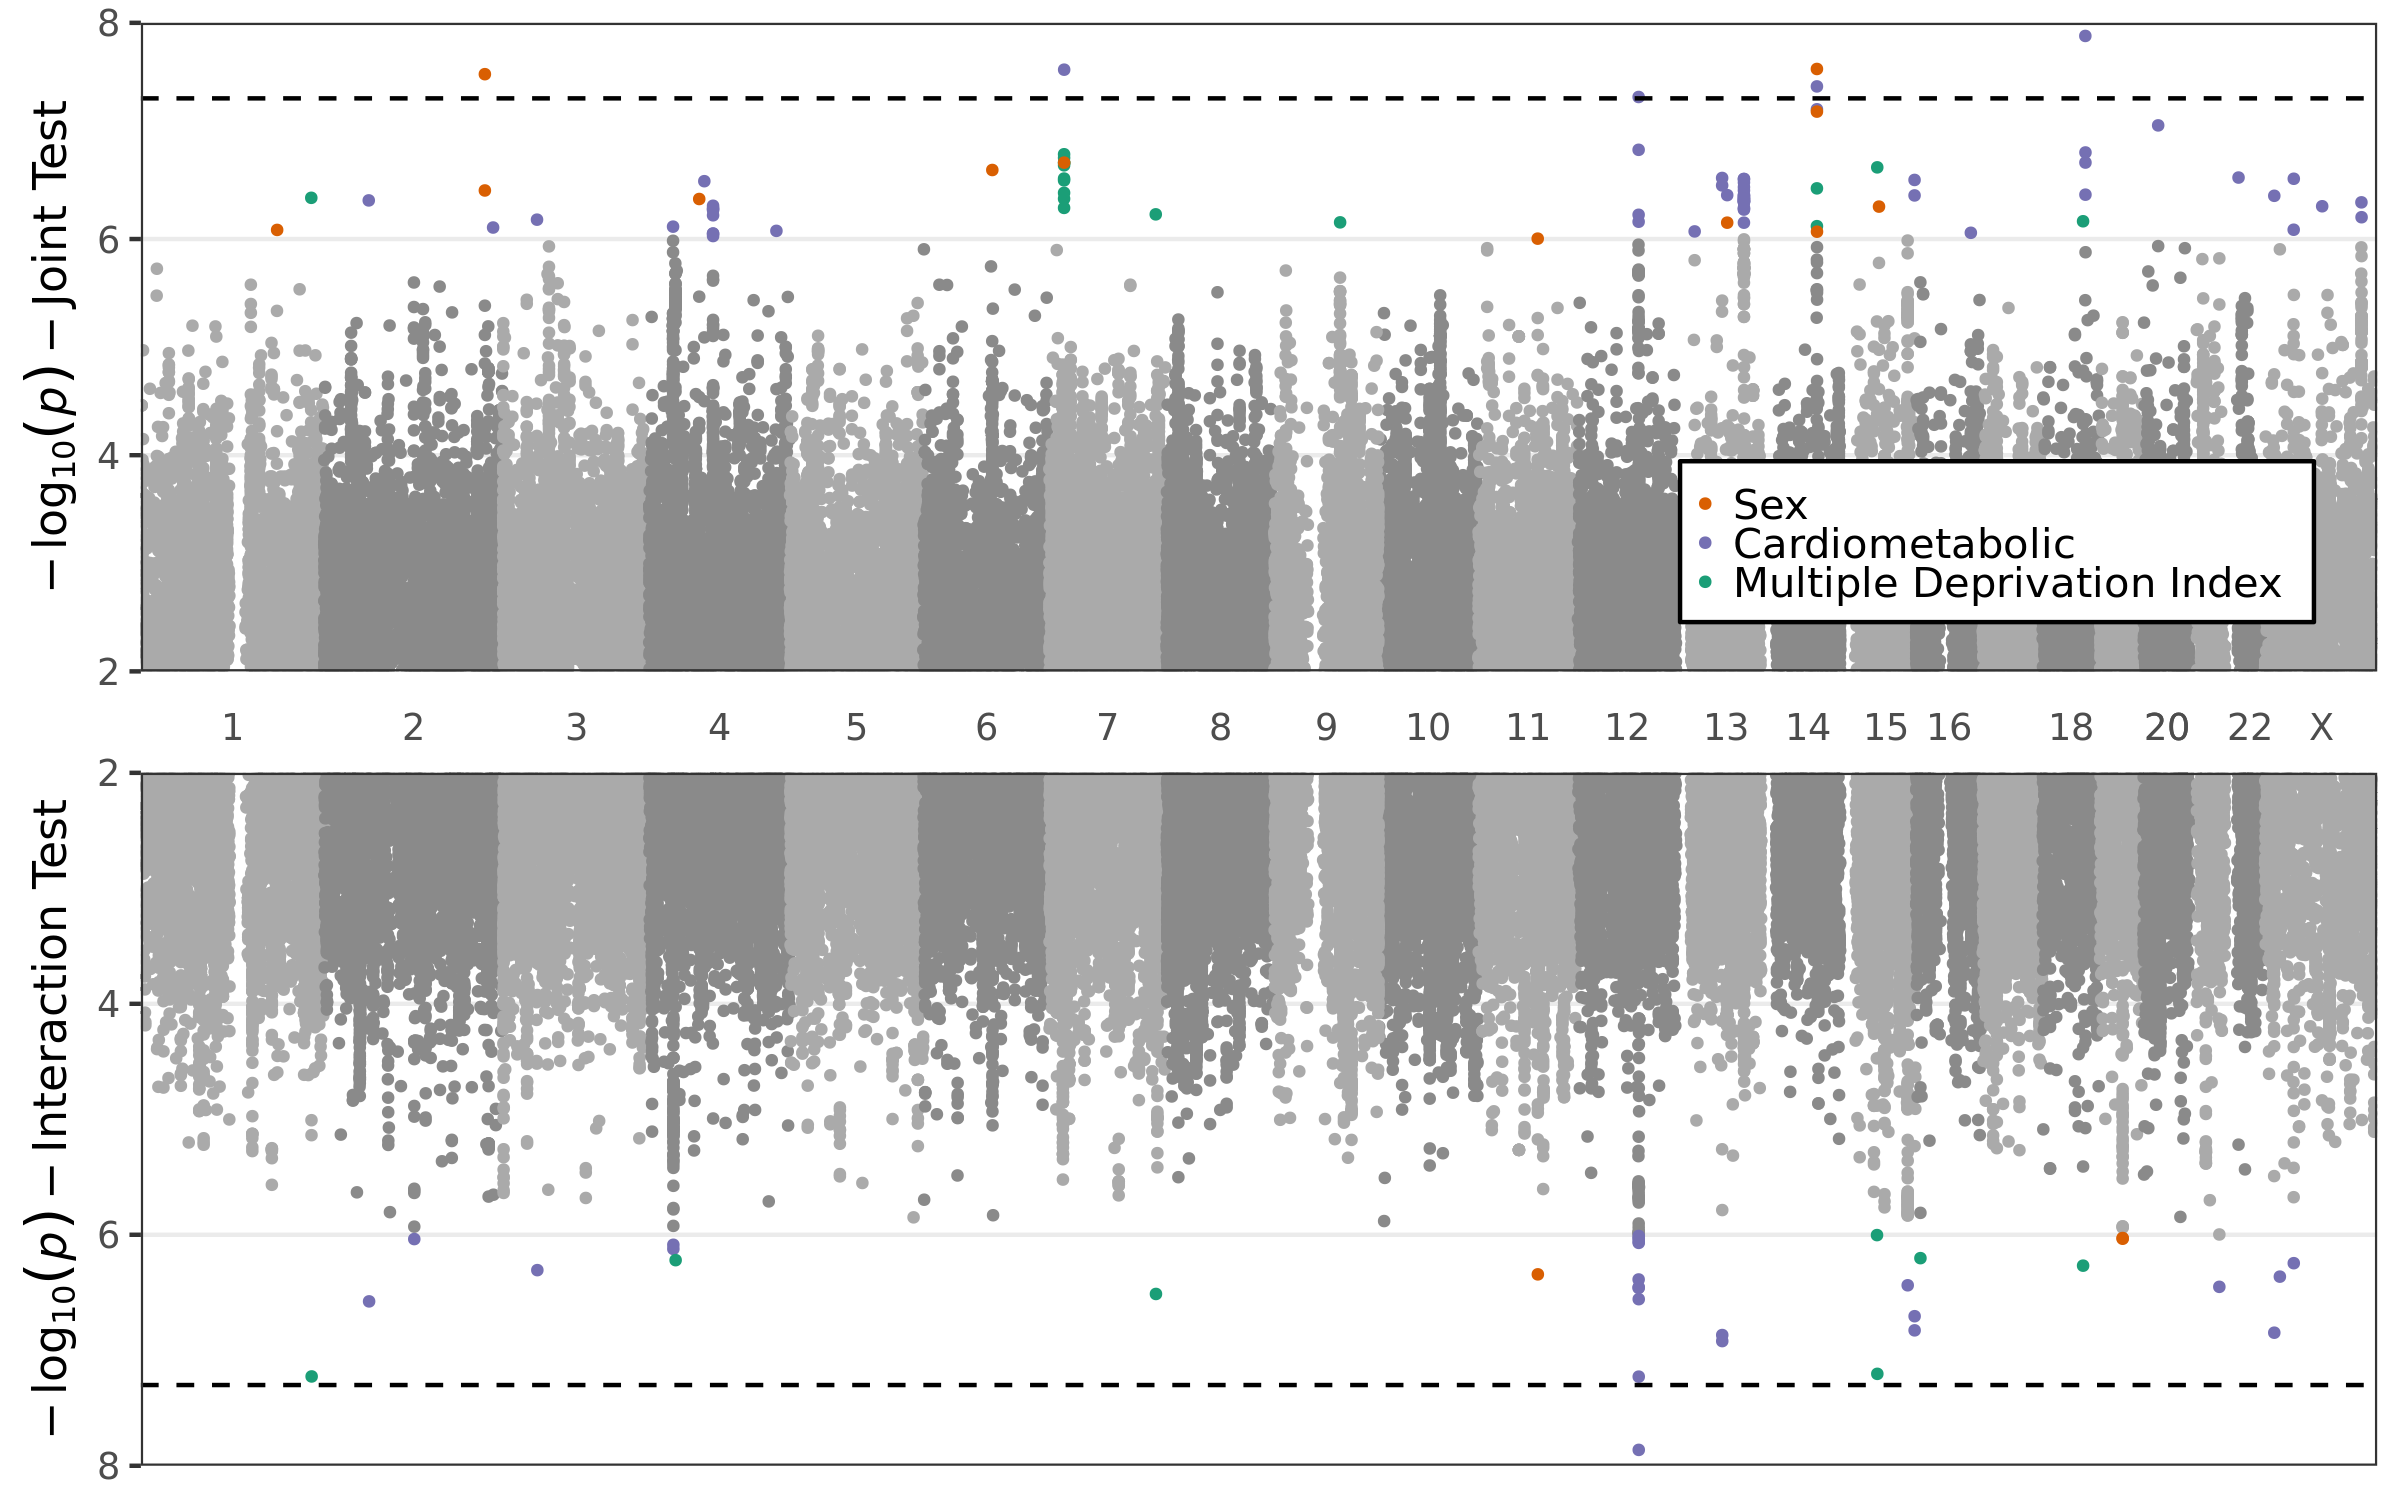

In [86]:
options(repr.plot.width=8, repr.plot.height=5)

#TOP PLOT
p1 <- ggplot() + geom_point(data=d_order[d_order$Location=="Top", ],
                            aes(x=x_coord, y=pvalue, color=factor(Color)),
                            size=0.75, alpha=1) + geom_hline(yintercept=-log10(5e-8), linetype="dashed", color="black") +
  scale_x_continuous(breaks=lims$av[c(1:16, 18, 20, 20, 22, 23)],
                     labels=c(1:16, 18, 20, 20, 22, "X"),
                     expand=c(0,0)) +
  scale_y_continuous(limits=c(2, 8), breaks = seq(2, 8, 2), expand=c(0,0),
                     name=expression(-log[10](italic(p)) - "Joint Test")) +
  scale_colour_manual(name = "Color", values = newcols, breaks=c("sex", "cm", "mdi"), 
                      labels=c("Sex", "Cardiometabolic", "Multiple Deprivation Index")) +
  #scale_fill_manual(name = "Color", values = newcols) +
  theme_bw() + 
  theme(axis.title.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.text.x = element_text(vjust = -1.5),
        panel.grid.minor = element_blank(),
        panel.grid.major.x = element_blank(),
        legend.title=element_blank(),
        legend.background=element_rect(color="black", size=rel(1)),
        legend.key.size=unit(0.1, "lines"),
        legend.text=element_text(size=10),
        legend.position = c(.83, .2),
        legend.margin = margin(0,25,5,5))
  
#BOTTOM PLOT
p2 <- ggplot() + geom_point(data=d_order[d_order$Location== "Bottom",],
                            aes(x=x_coord, y=pvalue, color=factor(Color)), size=0.75, alpha=1) +
  geom_hline(yintercept=-log10(5e-8), linetype="dashed", color="black") +
  scale_x_continuous(breaks=lims$av[c(1:16, 18, 20, 20, 22, 23)],
                     labels=c(1:16, 18, 20, 20, 22, "X"),
                     expand=c(0,0)) +
  scale_y_continuous(limits=c(2, 8), breaks = seq(2, 8, 2), expand=c(0,0),
                     name=expression(-log[10](italic(p)) - "Interaction Test")) +
  scale_colour_manual(name = "Color", values = newcols, breaks=c("sex", "cm", "mdi"), 
                      labels=c("Sex", "Cardiometabolic", "Multiple Deprivation Index")
                      # breaks=c(30, 31),
                      # labels=c("Genome-wide significant joint test, no genome-wide significant marginal test",
                      #          "Genome-wide significant interaction test")
  ) +
 #scale_fill_manual(name = "Color", values = newcols_bot) +
  #ylab(expression(-log[10](p) - Joint)) +
 theme_bw()+
   theme(axis.text.x = element_blank(),
         axis.ticks.x=element_blank(),
         axis.title.x = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major.x = element_blank()) +
  scale_y_reverse(limits=c(8,2), breaks = seq(8, 2, -2), expand=c(0,0),
                  name=expression(-log[10](italic(p)) - "Interaction Test"))


cowplot::plot_grid(p1, p2 + guides(color=F), ncol=1, rel_widths = c(1,1))

In [80]:
#COLOR LEGEND#
# color_legend <- cowplot::get_legend(
#   p2 + theme(
#       legend.title=element_blank(),
#       legend.background=element_rect(color="black", size=rel(1)),
#       legend.key.size=unit(0.1, "lines"),
#       legend.text=element_text(size=10),
#     )+
#     guides(color=guide_legend(override.aes=list(size=2.5)))
# )
# 
# left_plt <- cowplot::plot_grid(p1 + guides(color=F),
#                    p2 + guides(color=F),
#                    align='v',
#                    #color_legend,
#                    nrow=2, rel_heights=c(5, 5))

## Supplementary Miami plots

In [42]:
make_miami <- function(data, joint_pval_col, int_pval_col, main=""){
  # Make a Miami plot -- credit to RaMWAS package (pruning unneeded points)
  # and hudson package (basis for Miami plot functionality)
  data <- filter(data, data[[joint_pval_col]] > 0, data[[int_pval_col]] > 0)
  nlps1 <- -log10(data[[joint_pval_col]])
  nlps2 <- -log10(data[[int_pval_col]])
  # Trim points in crowded regions (credit to RaMWAS package for code snippet)
  yfac = as.integer(nlps1 * 100) + 1L
  yorder = sort.list(yfac)
  levels(yfac) = as.character(seq_len(max(yfac)))
  class(yfac) = "factor"
  ygroup = split(seq_along(yfac), yfac)
  for (i in seq_along(ygroup)) {
    if (length(ygroup[[i]]) > 300) {
      ygroup[[i]] = sample(ygroup[[i]], size=300, replace=FALSE)
    }
  }
  keep1 = unlist(ygroup, use.names=FALSE)
  yfac = as.integer(nlps2 * 100) + 1L
  yorder = sort.list(yfac)
  levels(yfac) = as.character(seq_len(max(yfac)))
  class(yfac) = "factor"
  ygroup = split(seq_along(yfac), yfac)
  for (i in seq_along(ygroup)) {
    if (length(ygroup[[i]]) > 300) {
      ygroup[[i]] = sample(ygroup[[i]], size=300, replace=FALSE)
    }
  }
  keep2 = unlist(ygroup, use.names=FALSE)
  top <- cbind(select(data, SNP=RSID, CHR, POS), pvalue=nlps1)[keep1, ]
  bottom=cbind(select(data, SNP=RSID, CHR, POS), pvalue=nlps2)[keep2, ]
  topn <- names(top)
  bottomn <- names(bottom)
  top$Location <- "Top"
  bottom$Location <- "Bottom"
  d <- rbind(top, bottom)
  d$POS <- as.numeric(as.character(d$POS))
  d$CHR <- factor(d$CHR, levels = c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "X"))
  d_order <- d[order(d$CHR, d$POS), ]
  d_order$pos_index <- seq.int(nrow(d_order))
  chr_lengths <- sapply(c(1:22, "X"), function(chr) max(d[d$CHR == chr, "POS"]))
  chr_start_pos <- cumsum(chr_lengths) - chr_lengths
  d_order$x_coord <- chr_start_pos[d_order$CHR] + d_order$POS
  d_order_sub <- d_order[, c("SNP", "CHR", "POS", "pvalue", "pos_index", "x_coord")]
  maxRows <- by(d_order_sub, d_order_sub$CHR, function(x) x[which.max(x$x_coord),])
  minRows <- by(d_order_sub, d_order_sub$CHR, function(x) x[which.min(x$x_coord),])
  milimits <- do.call(rbind, minRows)
  malimits <- do.call(rbind, maxRows)
  lims <- merge(milimits, malimits, by="CHR")
  names(lims) <- c("Color", 
                   "snpx", "posx", "px", "posidxx", "xcoordmin",
                   "snpy", "posy", "py", "posidxy", "xcoordmax")
  lims$av <- (lims$xcoordmin + lims$xcoordmax)/2
  lims <- lims[order(lims$Color),]

  d_order$Color <- as.character(d_order$CHR)
  newcols <- rep(x=c("#AAAAAA", "#8A8A8A"), length.out=23, each=1)  # Gray/dark gray for alternating chromosomes
  names(newcols) <- levels(factor(lims$Color))
  d_order <- arrange(d_order, as.integer(Color), desc(pvalue)) %>%
    distinct(SNP, Location, .keep_all=T)
                
  # TOP PLOT
  p1 <- ggplot() +
    geom_point(data=d_order[d_order$Location=="Top", ], 
               aes(x=x_coord, y=pvalue, color=factor(Color)), 
               size=0.75, alpha=1) +
    geom_hline(yintercept=-log10(5e-8), linetype="dashed", color="black") + 
    scale_x_continuous(breaks=lims$av[c(1:16, 18, 20, 20, 22, 23)], 
                       labels=lims$Color[c(1:16, 18, 20, 20, 22, 23)], 
                       expand=c(0,0)) +
    scale_y_continuous(limits=c(0, 8.5), expand=c(0,0),
                       name=expression(-log[10](italic(p)) - Joint)) +
    scale_colour_manual(name = "Color", values = newcols) +
    scale_fill_manual(name = "Color", values = newcols) +
    theme_bw() + 
    theme(axis.title.x=element_blank(),
          axis.text.x = element_text(vjust = -1.5),
          panel.grid.minor = element_blank(),
          panel.grid.major.x = element_blank())
                
  # BOTTOM PLOT
  p2 <- ggplot(data=filter(d_order, Location == "Bottom"),
               aes(x=x_coord, y=pvalue, color=factor(Color))) +
    geom_point(size=0.75, alpha=1) +
    geom_hline(yintercept=-log10(5e-8), linetype="dashed", color="black") + 
    scale_x_continuous(breaks=lims$av[c(1:16, 18, 20, 20, 22, 23)], 
                       labels=lims$Color[c(1:16, 18, 20, 20, 22, 23)], 
                       expand=c(0,0), position="top") +
    scale_colour_manual(name = "Color", values = newcols) +
    scale_fill_manual(name = "Color", values = newcols) +
    ylab(expression(-log[10](p) - Interaction)) +
    theme_bw() +
    theme(axis.text.x      = element_blank(),
          axis.title.x     = element_blank(),
          panel.grid.minor = element_blank(),
          panel.grid.major.x = element_blank()) +
    scale_y_reverse(limits=c(8.5, 0), expand=c(0,0),
                    name=expression(-log[10](italic(p)) - Interaction))

  cowplot::plot_grid(p1 + guides(color=F), 
                     p2 + guides(color=F), 
                     align='v', nrow=2, rel_heights=c(5, 5))
}

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


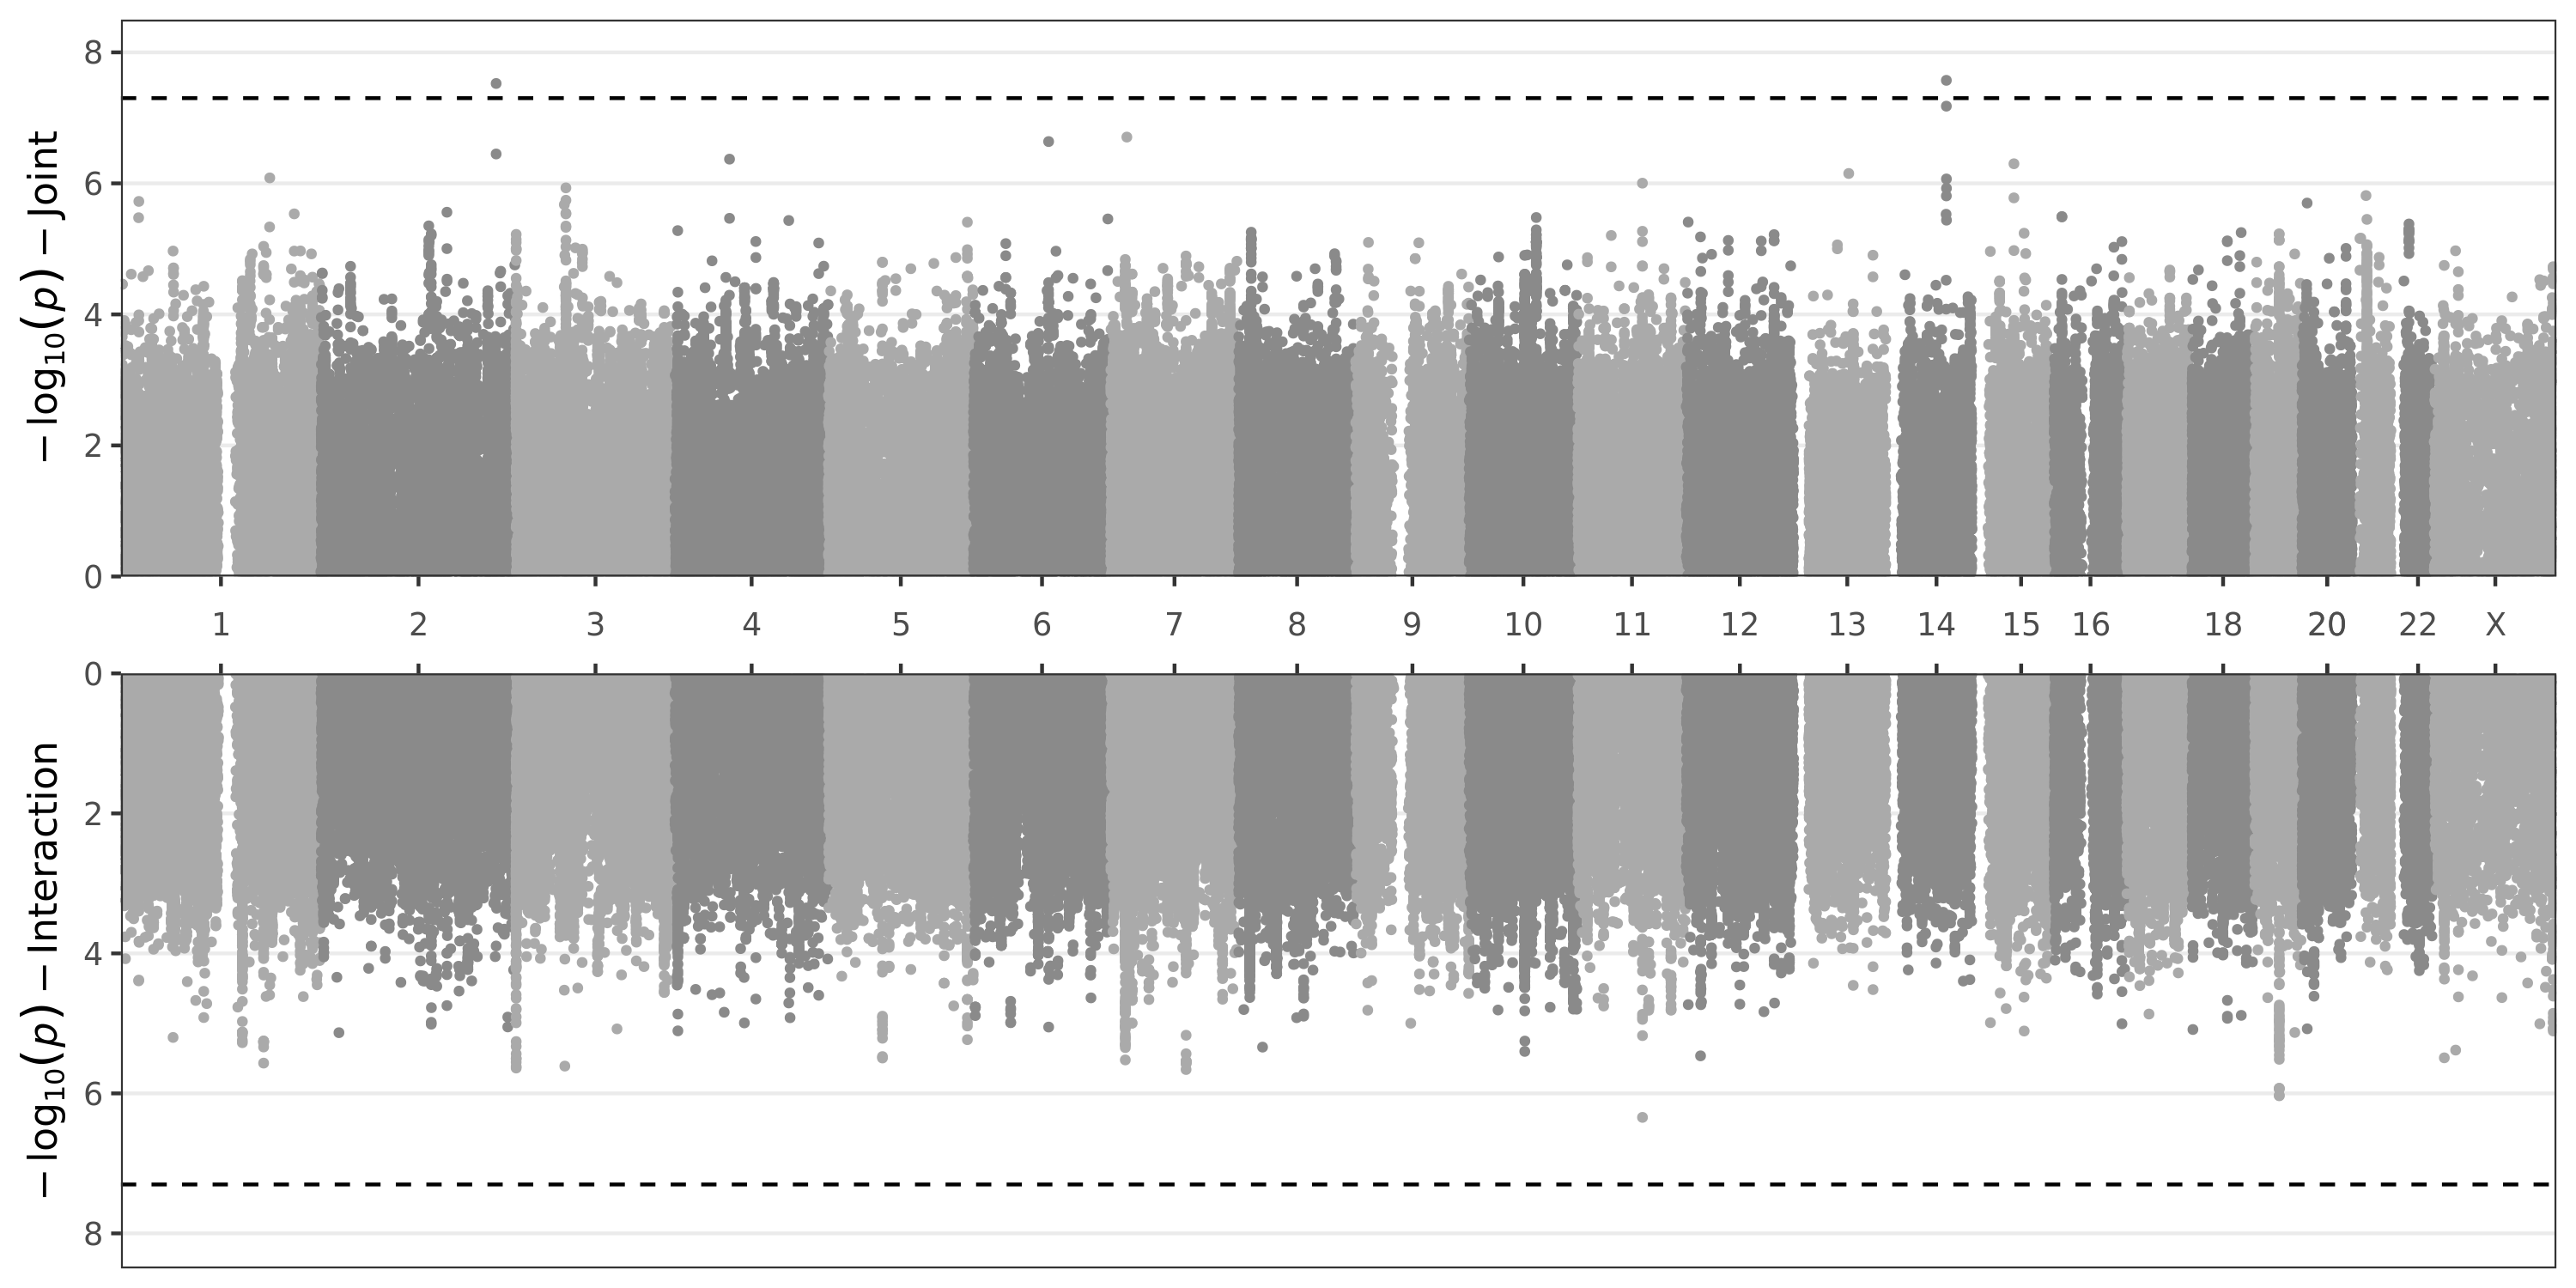

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


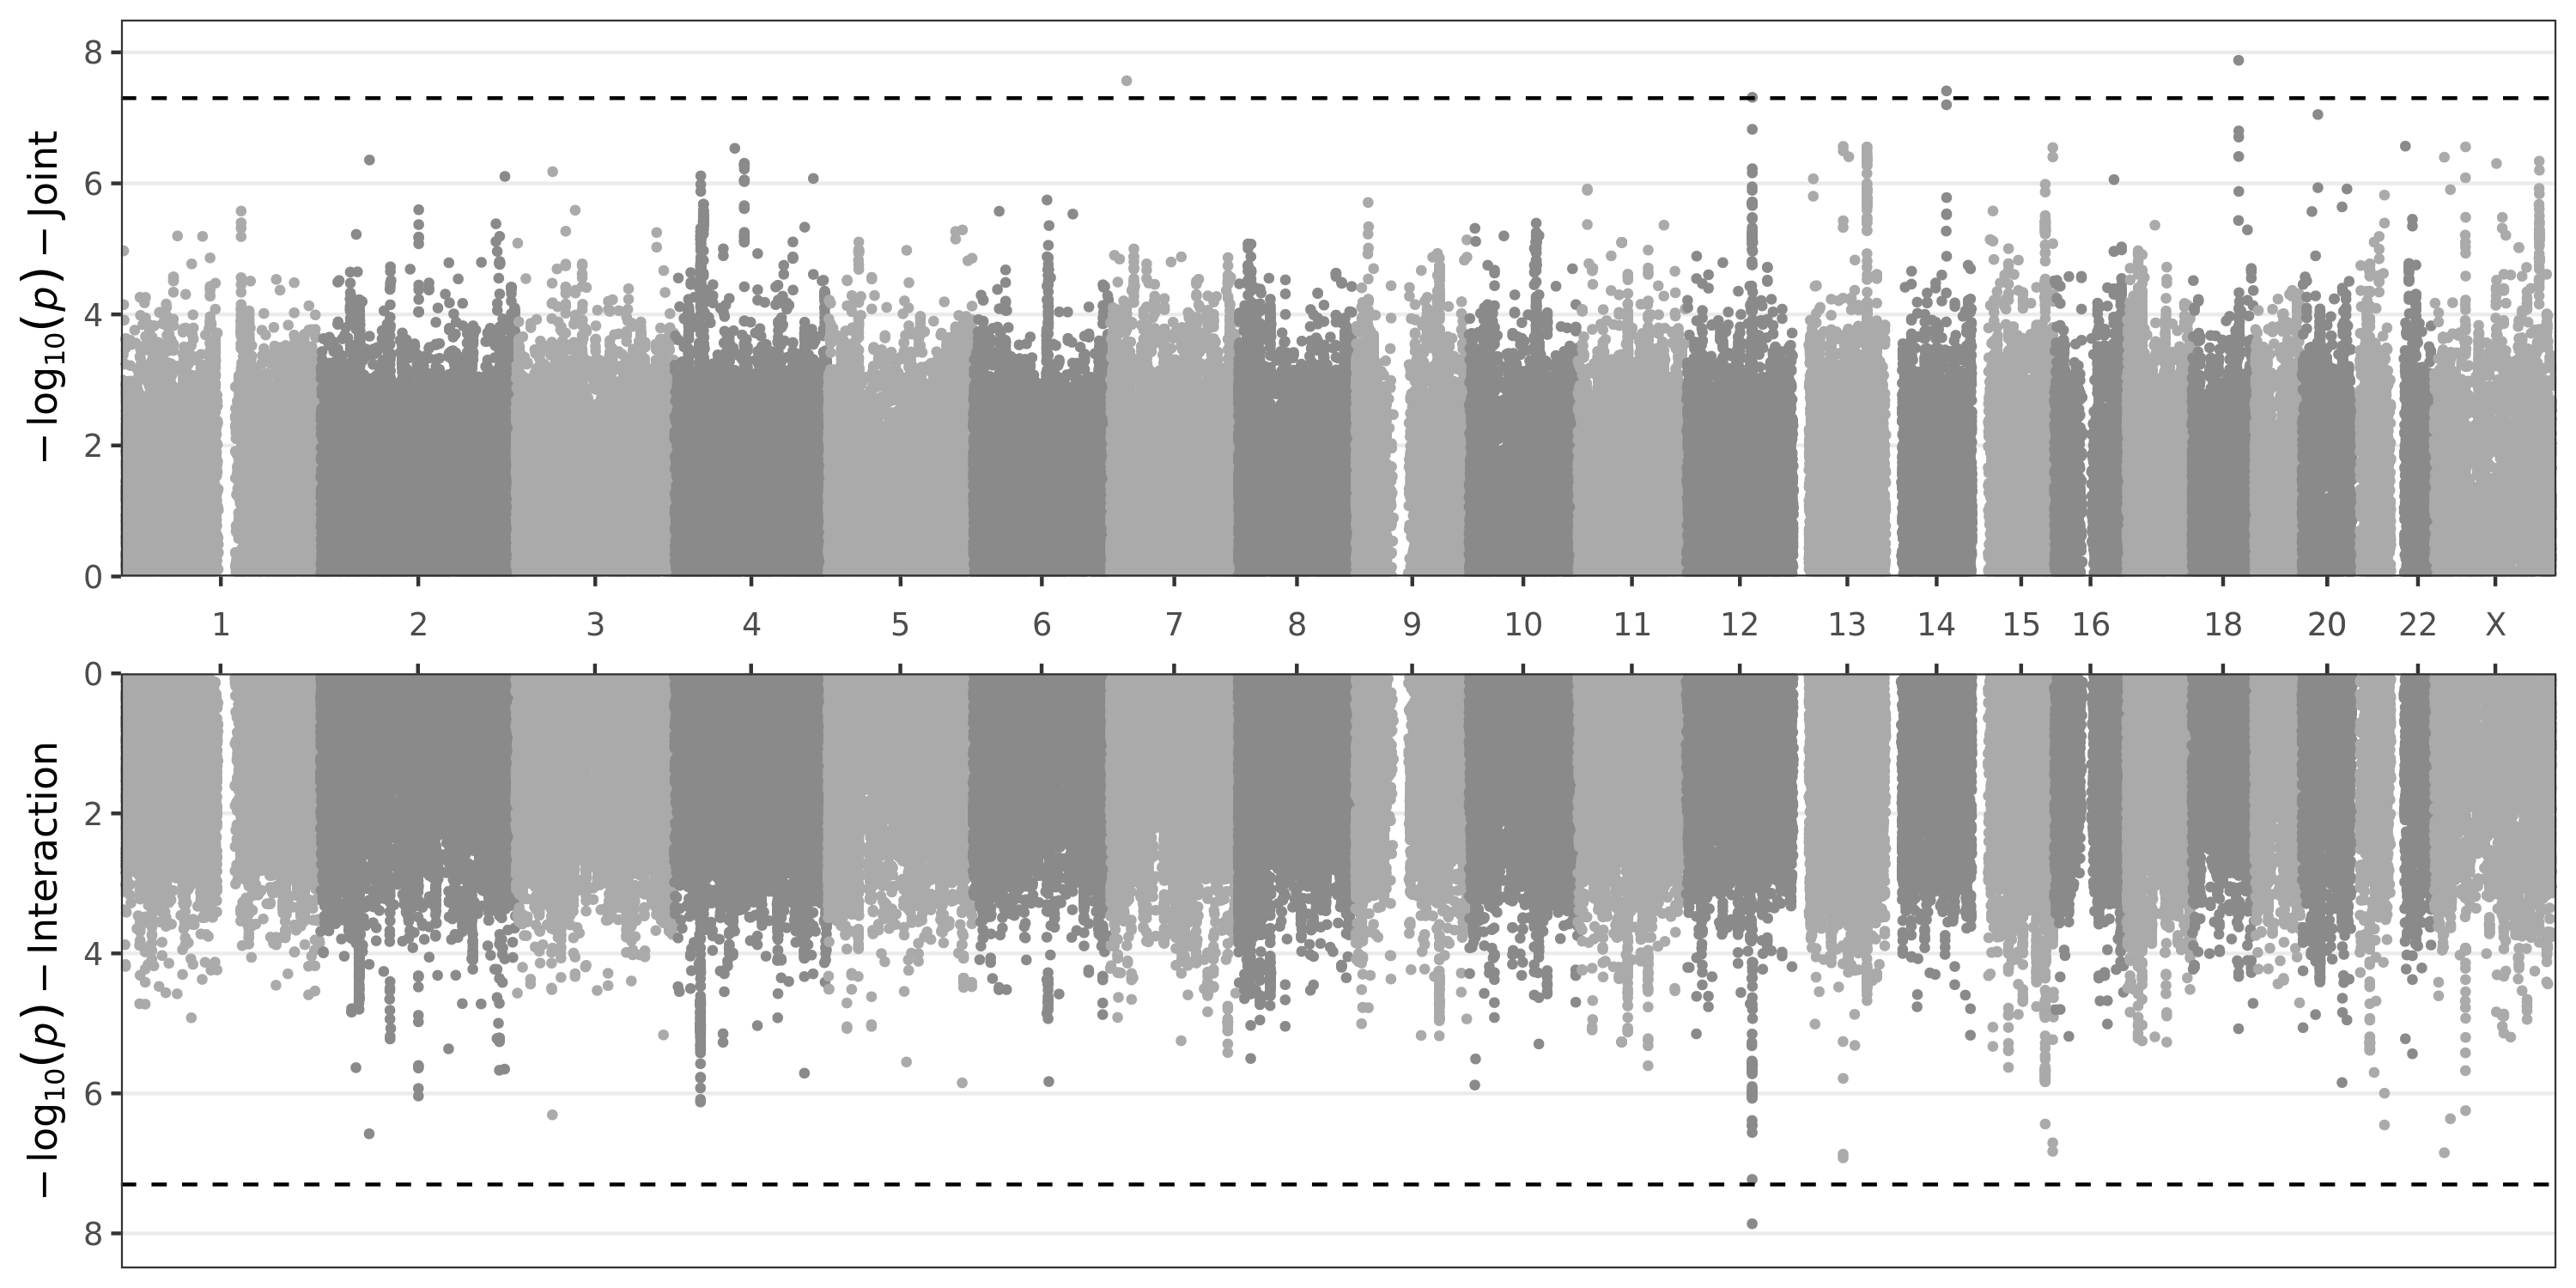

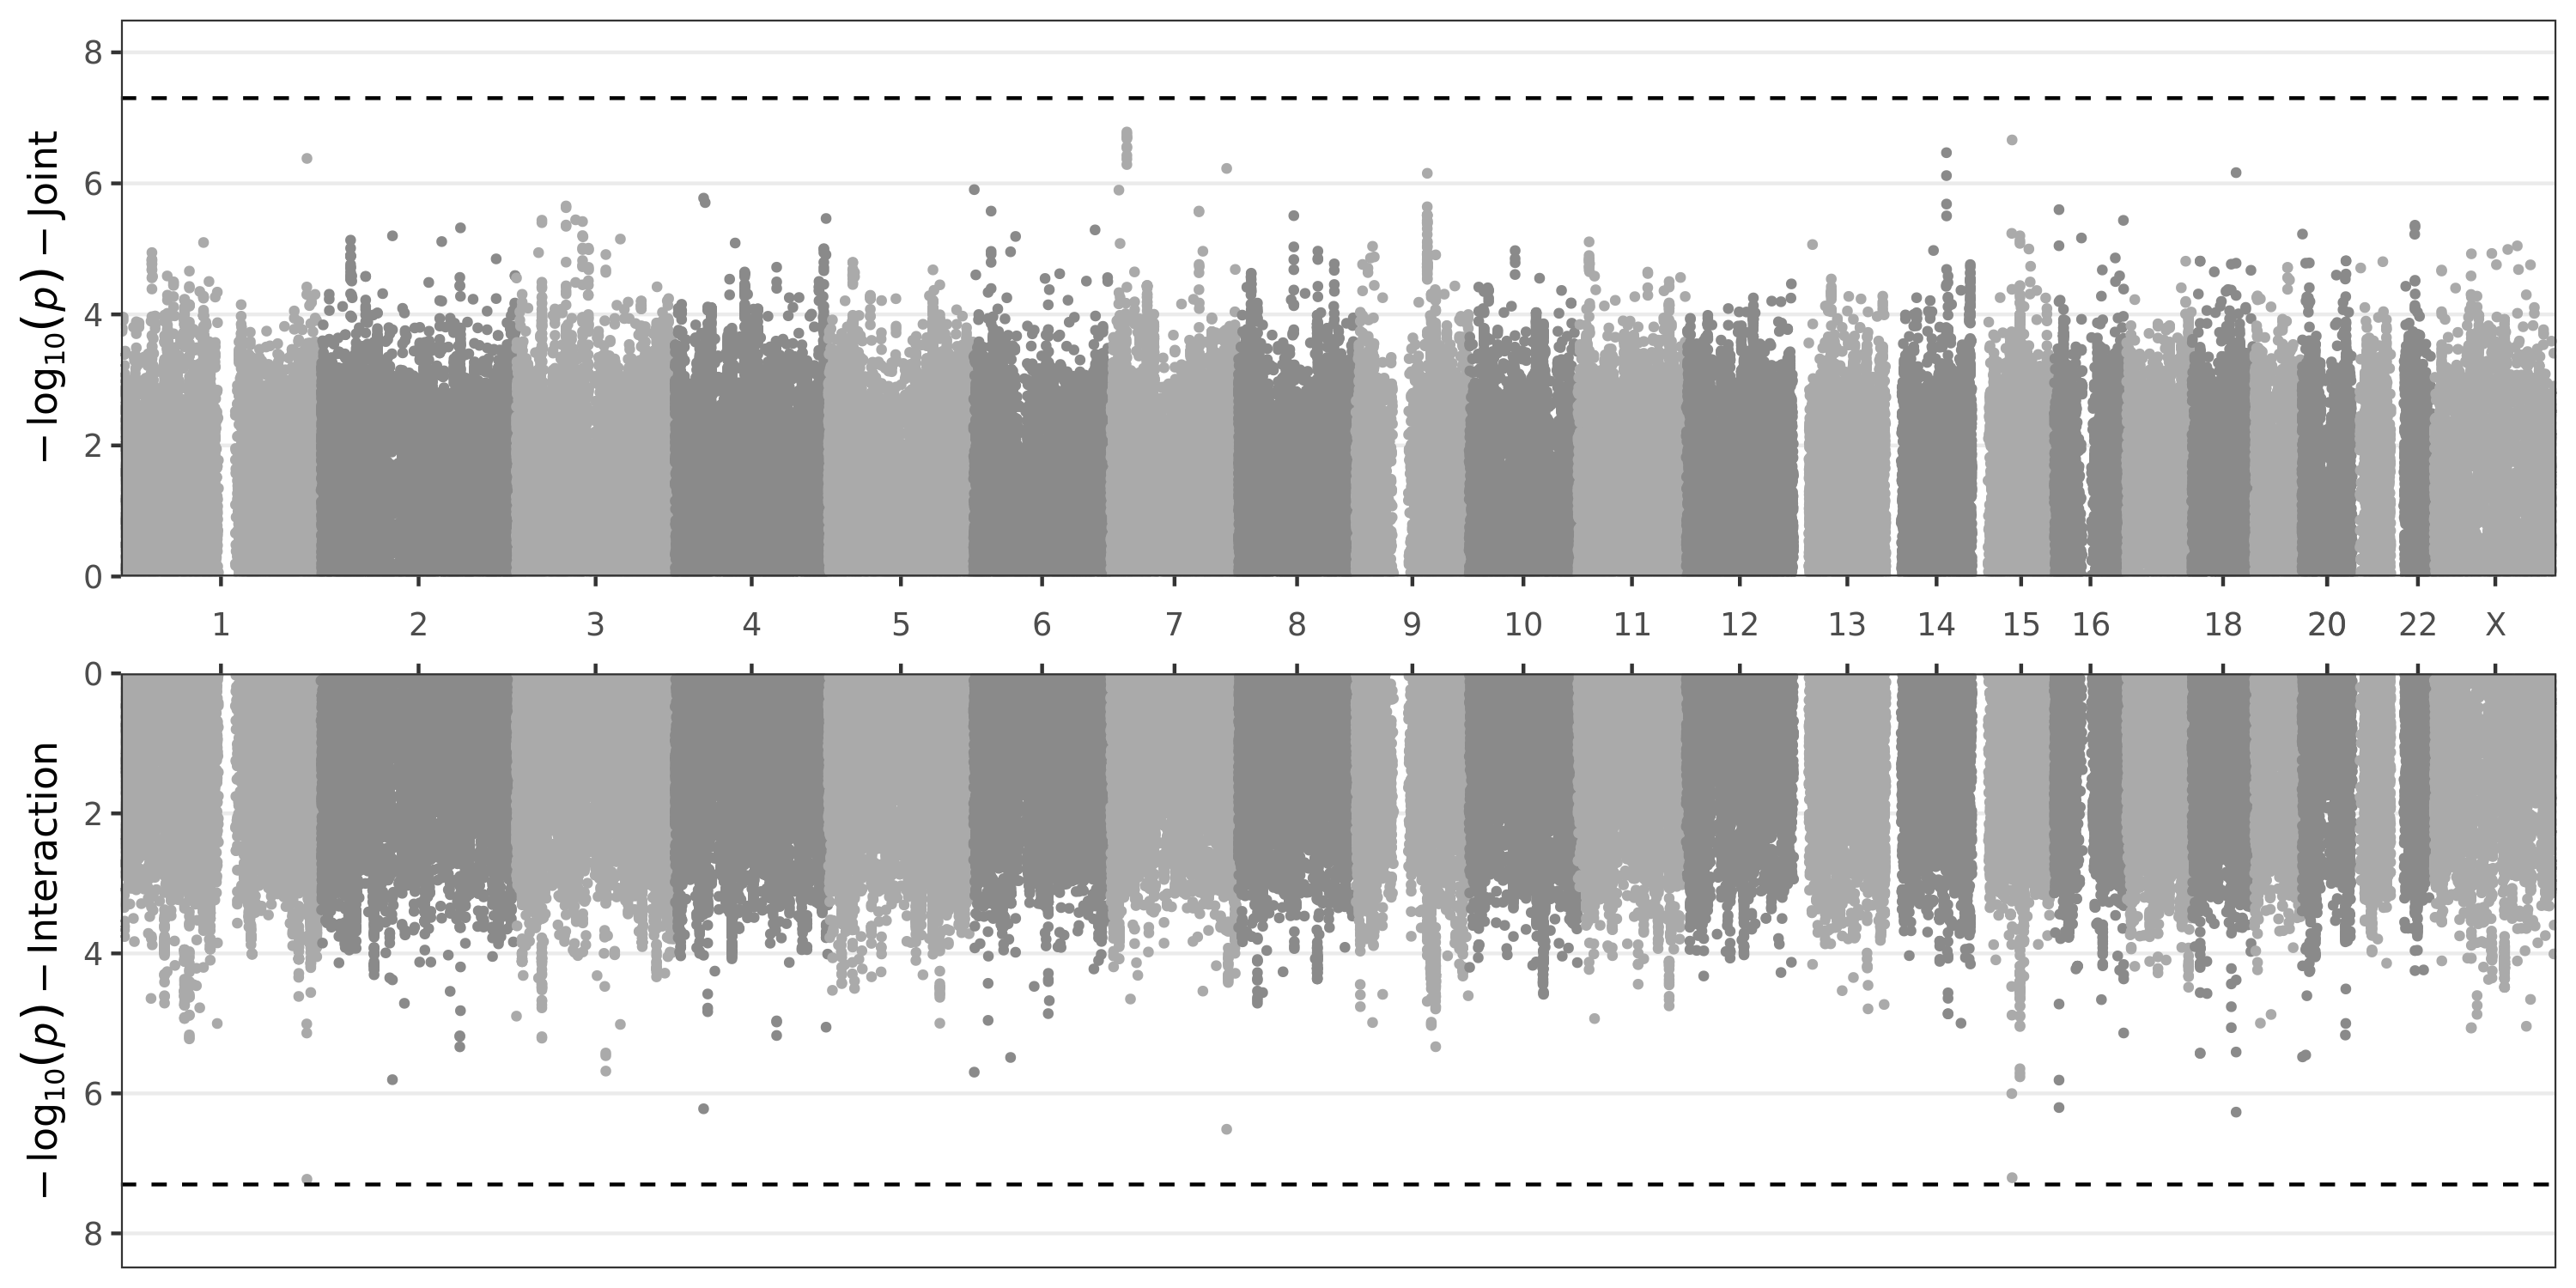

In [43]:
make_miami(sex_res, "P_Value_Joint", "P_Value_Interaction")
make_miami(cm_res, "P_Value_Joint", "P_Value_Interaction")
make_miami(mdi_res, "P_Value_Joint", "P_Value_Interaction")

## Variant-specific figures

### rs2268616

In [81]:
table(followup_df$rs2268616, followup_df$case_b2)

   
         0      1
  0 362339   2264
  1  13198    138
  2    112      0

In [82]:
pgf_strat_effects <- bind_rows(list(
    Female=run_main_effect_regression("rs2268616", filter(followup_df, sexMale == 0)),
    Male=run_main_effect_regression("rs2268616", filter(followup_df, sexMale == 1)),
    `No T2D`=run_main_effect_regression("rs2268616", filter(followup_df, t2d == 0)),
    T2D=run_main_effect_regression("rs2268616", filter(followup_df, t2d == 1)),
    `No obesity`=run_main_effect_regression("rs2268616", filter(followup_df, bmi < 30)),
    Obesity=run_main_effect_regression("rs2268616", filter(followup_df, bmi >= 30))
), .id="strat") %>%
    mutate(l95 = estimate - 1.96 * std.error,
           u95 = estimate + 1.96 * std.error) %>%
    mutate(across(c(estimate, l95, u95), exp))

geno0_lm <- glm(case_b2 ~ sexMale + age + PC1 + PC2 + PC3, family=binomial,
               data=filter(followup_df, rs2268616 == 0)) %>%
    broom::tidy()
geno1_lm <- glm(case_b2 ~ sexMale + age + PC1 + PC2 + PC3, family=binomial,
               data=filter(followup_df, rs2268616 == 1)) %>%
    broom::tidy()
# geno2_lm <- broom::tidy(glm(case_b2 ~ sexMale + age + PC1 + PC2 + PC3, family=binomial,
#                data=filter(followup_df, rs2268616 == 2)))
geno_strat_effects <- bind_rows(list(AA=geno0_lm, `AG/GG`=geno1_lm), .id="genotype") %>%
    filter(term == "sexMale") %>%
    mutate(l95 = estimate - 1.96 * std.error,
           u95 = estimate + 1.96 * std.error) %>%
    mutate(across(c(estimate, l95, u95), exp))
## A/G snp

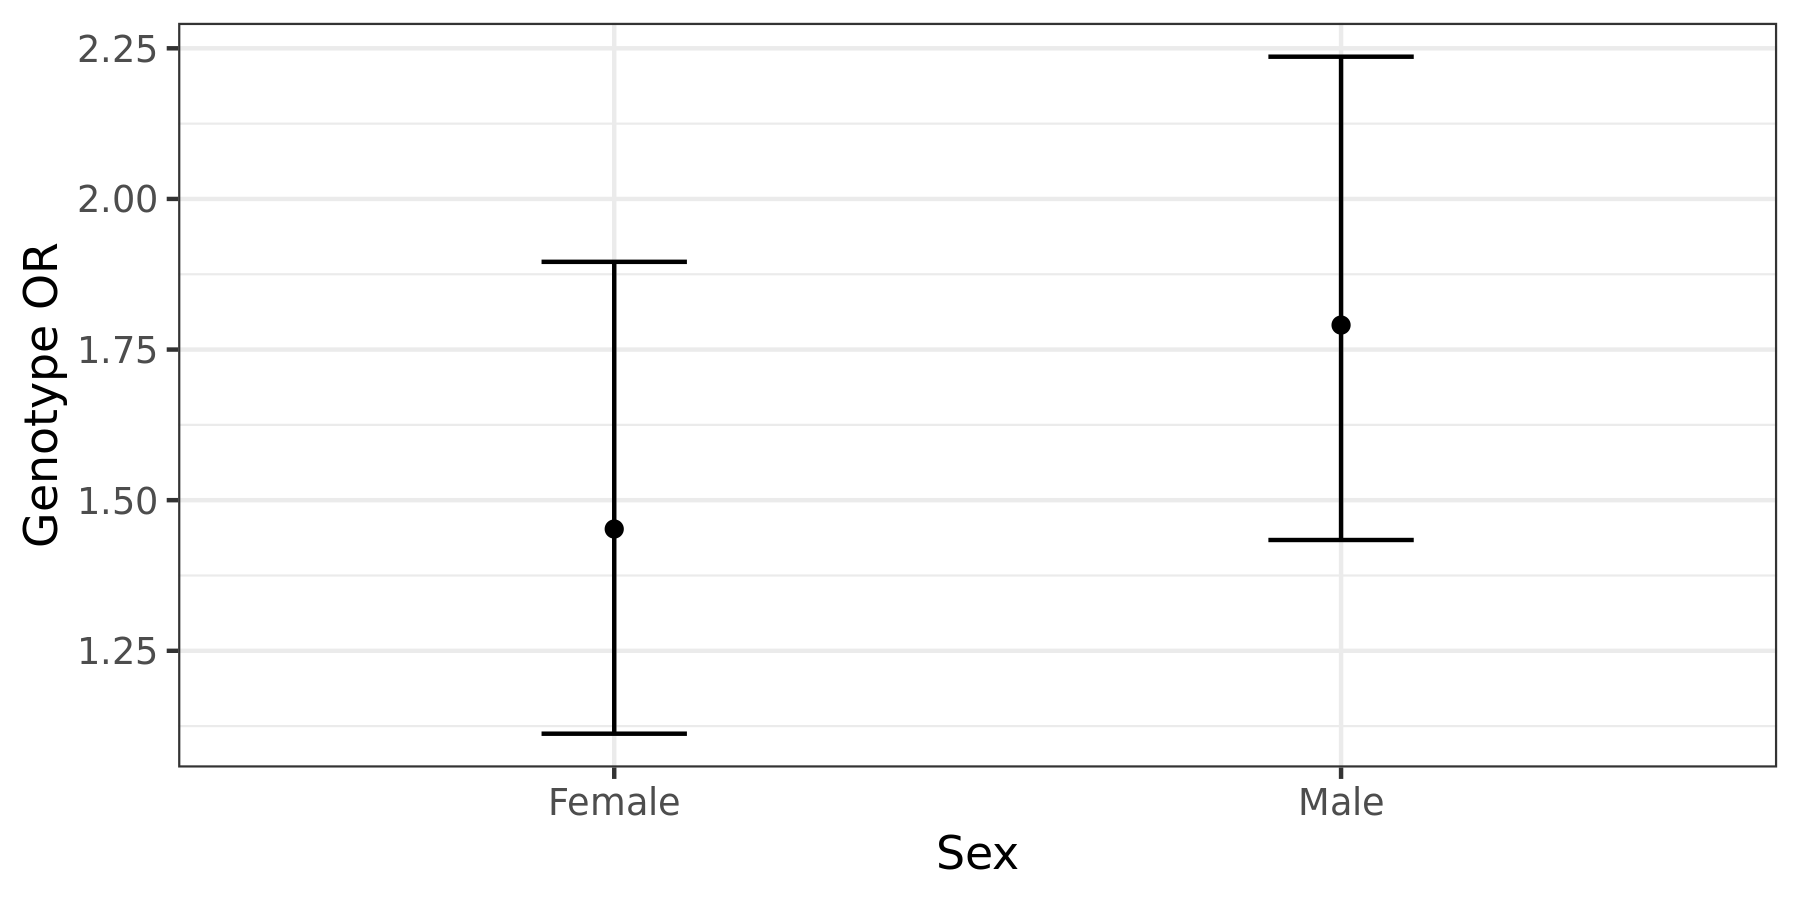

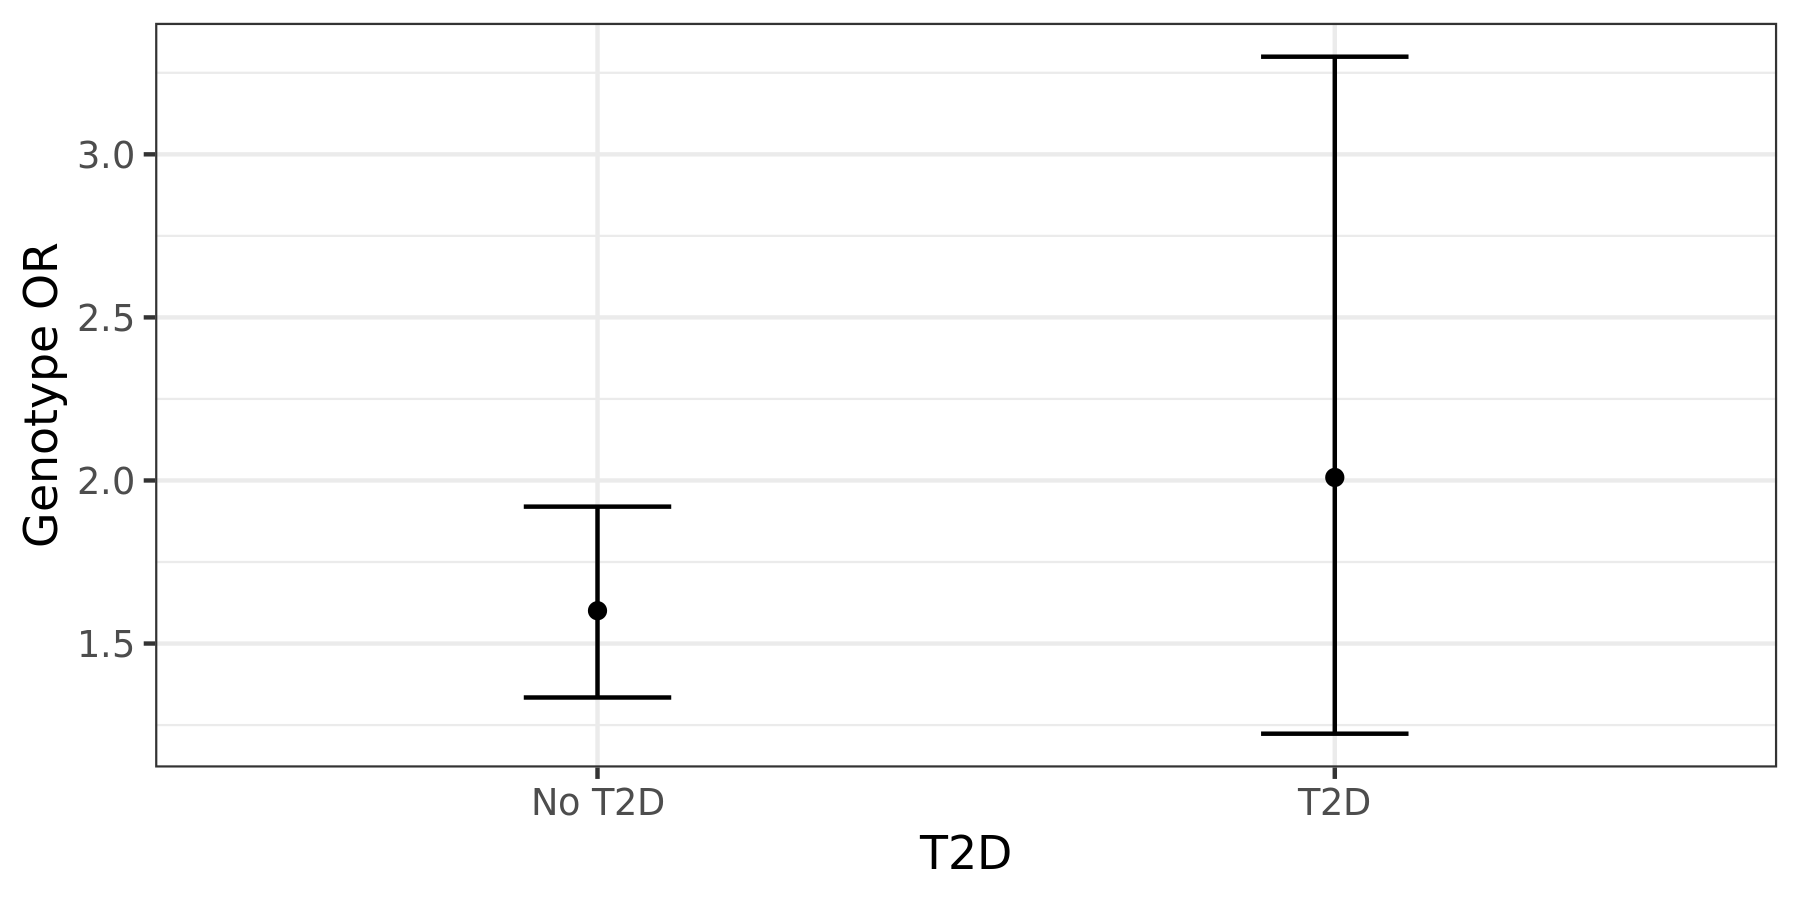

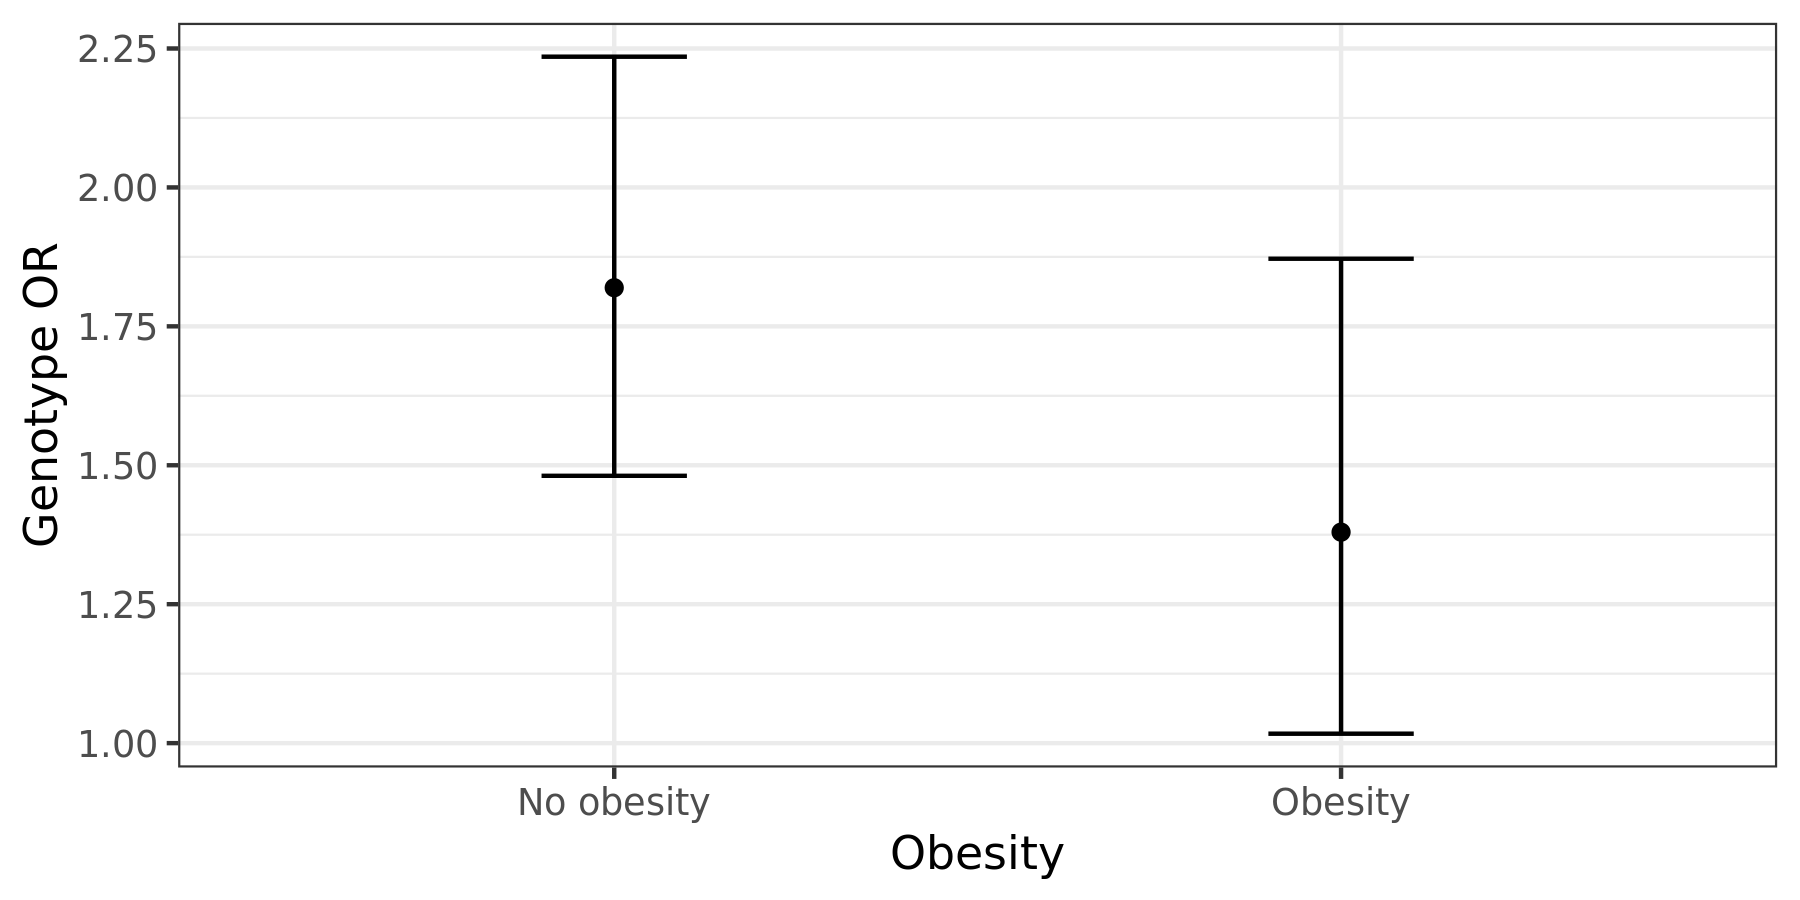

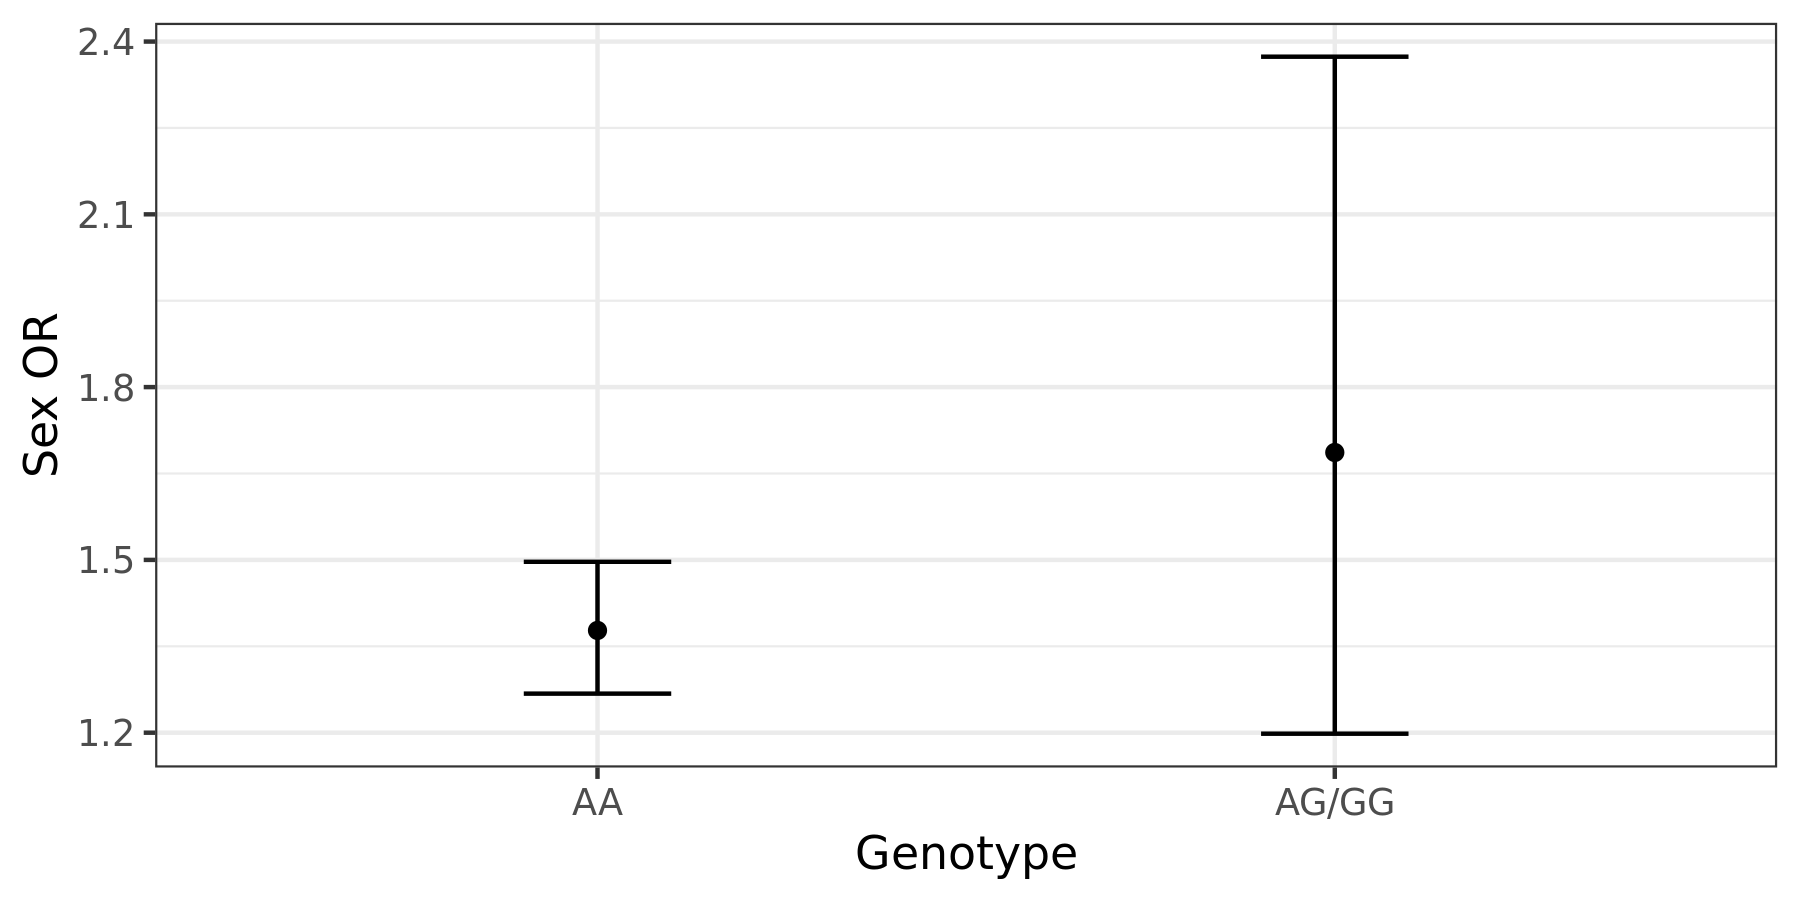

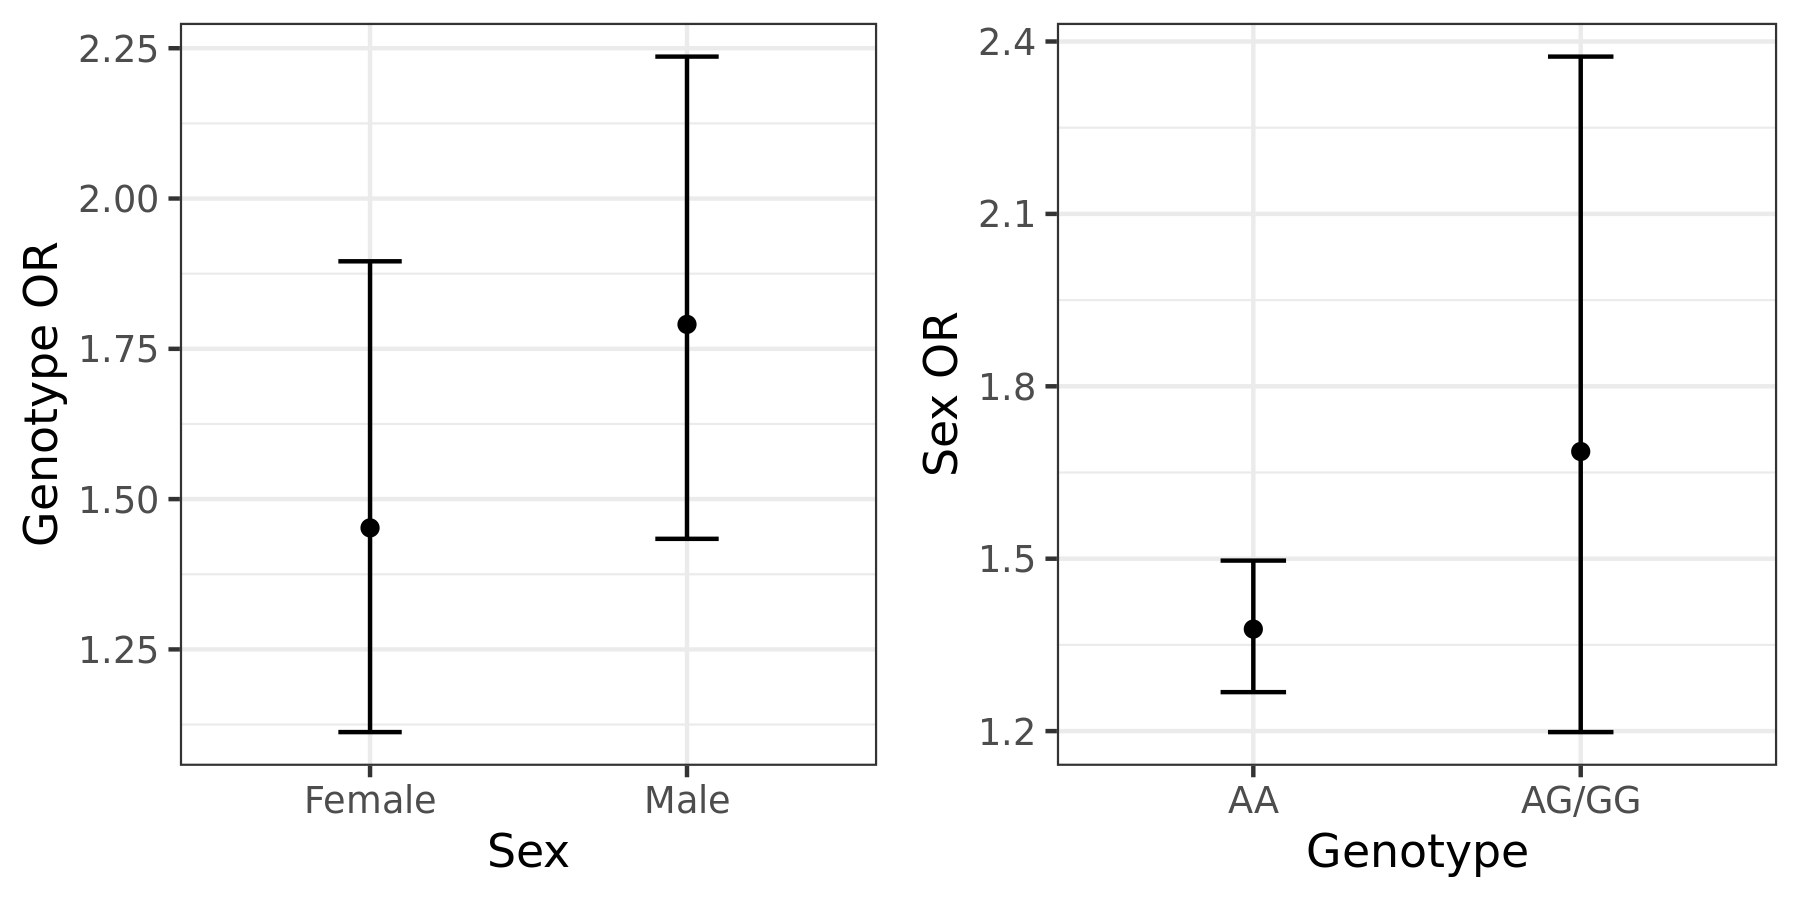

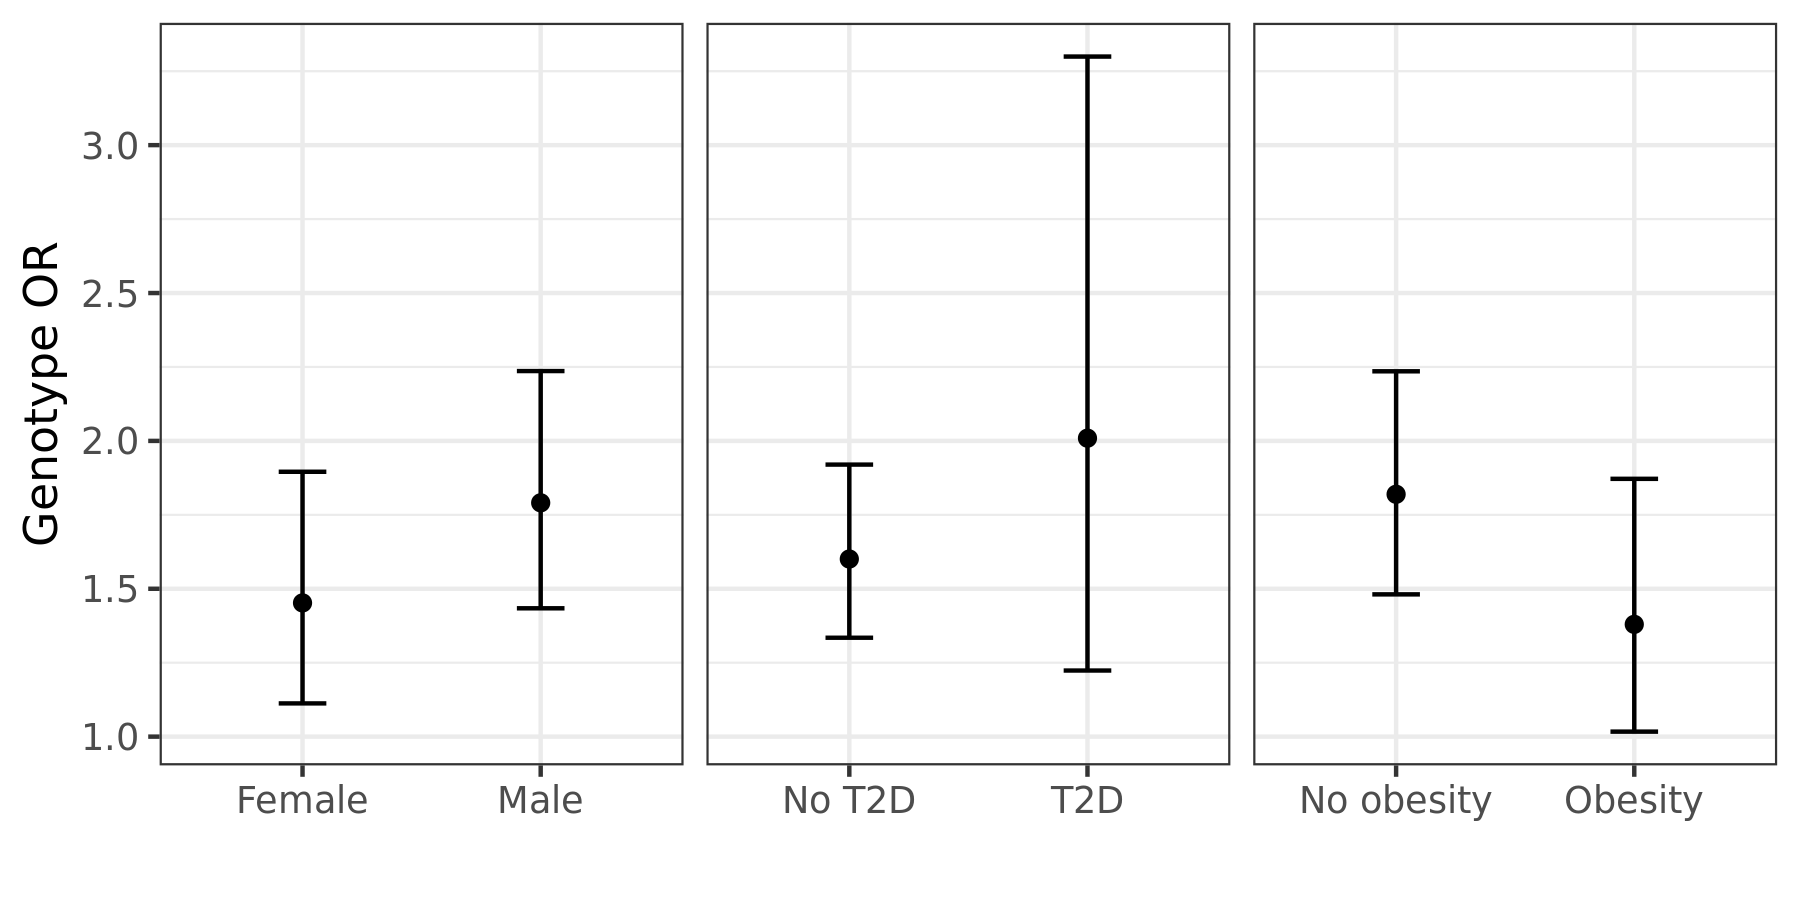

In [87]:
options(repr.plot.width=6, repr.plot.height=3)

pgf_sex_strat_g_plt <- pgf_strat_effects %>%
    filter(strat %in% c("Male", "Female")) %>%
    ggplot(aes(x=strat, y=estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin=l95, ymax=u95), width=0.2) +
    labs(x="Sex", y="Genotype OR") +
    theme_bw()
pgf_sex_strat_g_plt

pgf_t2d_strat_g_plt <- pgf_strat_effects %>%
    filter(strat %in% c("No T2D", "T2D")) %>%
    ggplot(aes(x=strat, y=estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin=l95, ymax=u95), width=0.2) +
    labs(x="T2D", y="Genotype OR") +
    theme_bw()
pgf_t2d_strat_g_plt

pgf_obesity_strat_g_plt <- pgf_strat_effects %>%
    filter(strat %in% c("No obesity", "Obesity")) %>%
    ggplot(aes(x=strat, y=estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin=l95, ymax=u95), width=0.2) +
    labs(x="Obesity", y="Genotype OR") +
    theme_bw()
pgf_obesity_strat_g_plt

pgf_g_strat_sex_plt <- geno_strat_effects %>%
    ggplot(aes(x=genotype, y=estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin=l95, ymax=u95), width=0.2) +
    labs(x="Genotype", y="Sex OR") +
    theme_bw()
pgf_g_strat_sex_plt

plot_grid(pgf_sex_strat_g_plt, pgf_g_strat_sex_plt, nrow=1)

pgf_strat_effects %>%
    mutate(group = case_when(
        strat %in% c("Male", "Female") ~ "Sex",
        strat %in% c("T2D", "No T2D") ~ "T2D",
        strat %in% c("No obesity", "Obesity") ~ "Obesity",
    )) %>%
    mutate(group = factor(group, levels=c("Sex", "T2D", "Obesity"))) %>%
    ggplot(aes(x=strat, y=estimate)) +
    geom_point() +
    geom_errorbar(aes(ymin=l95, ymax=u95), width=0.2) +
    labs(x="", y="Genotype OR") +
    facet_wrap(~group, scales="free_x") +
    theme_bw() +
    theme(strip.background=element_blank(),
          strip.text=element_blank())
    

# plot_grid(pgf_sex_strat_g_plt, pgf_t2d_strat_g_plt, pgf_obesity_strat_g_plt, nrow=1)

### ACE2 investigation

In [ ]:
options(repr.plot.width=6, repr.plot.height=5)
sex_ace2_df <- filter(sex_res, CHR == "X", POS > (15536320 - 10000), POS < (15620281 + 10000))
make_qq(sex_ace2_df, "P_Value_Interaction")
make_qq(sex_ace2_df, "P_Value_Joint")
qplot(x=POS, y=-log10(P_Value_Joint), data=sex_ace2_df)
head(arrange(sex_ace2_df, P_Value_Joint))

options(repr.plot.width=6, repr.plot.height=5)
CM_ace2_df <- filter(cm_res, CHR == "X", POS > (15536320 - 10000), POS < (15620281 + 10000))
make_qq(CM_ace2_df, "P_Value_Joint")

options(repr.plot.width=6, repr.plot.height=5)
mdi_ace2_df <- filter(mdi_res, CHR == "X", POS > (15536320 - 10000), POS < (15620281 + 10000))
make_qq(mdi_ace2_df, "P_Value_Interaction")
make_qq(mdi_ace2_df, "P_Value_Joint")